In [1]:
!git clone https://github.com/xuhongzuo/DeepOD.git
%cd DeepOD
!git checkout 84c60206956a6db5b8b0c98b4a508f00d4890b3c
!pip install . --force-reinstall --no-deps

Cloning into 'DeepOD'...
remote: Enumerating objects: 1993, done.
remote: Counting objects: 100% (629/629), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 1993 (delta 545), reused 494 (delta 494), pack-reused 1364 (from 1)
Receiving objects: 100% (1993/1993), 3.50 MiB | 27.37 MiB/s, done.
Resolving deltas: 100% (1315/1315), done.
/content/DeepOD
Note: switching to '84c60206956a6db5b8b0c98b4a508f00d4890b3c'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 84c6020 update configs.yaml
Proce

In [2]:
import pandas as pd
import numpy as np
import json
import torch
import pickle
from math import sqrt
import os
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Generator
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
from sklearn.manifold import TSNE
import torch, glob, os
import torch
import os


import torch.nn as nn

In [3]:
c = 299792458  # Speed of light in meters per second
fs_cir=184.32*10**6
bin_duration_s=1/fs_cir
delay_ts=1/fs_cir
fs=100

In [4]:
lamda=c/fs_cir
lamda

1.6264781792534722

In [70]:
dataset_path="/content/drive/MyDrive/5G_NLOS_Project/dataset/tensor_chunks_train"
Load_DIR=Path(dataset_path)
dataset_path_test="/content/drive/MyDrive/5G_NLOS_Project/dataset/tensor_chunks_test"
Load_DIR_test=Path(dataset_path_test)
C_LIGHT = 299_792_458.0  # m s⁻¹
df = pd.read_csv("/content/drive/MyDrive/5G_NLOS_Project/dataset/traj_1.csv")

trajectory_test=1

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
anchors_np = np.loadtxt(Load_DIR / "anchor_positions.txt", delimiter=",", skiprows=1, usecols=(1, 2, 3))
anchors = torch.as_tensor(anchors_np, dtype=torch.float32, device='cpu')  # (8,3)
anchors[1]

tensor([10.0957, 29.8520,  3.4952])

In [9]:
def load_chunks(
    chunk_dir: str,
    pattern: str = "chunk_*.pt",
    anchors_path=Load_DIR / "anchor_positions.txt",
    device: str = "cpu",
) -> Dict[str, torch.Tensor]:
    """
    Load every tensor chunk in *chunk_dir* matching *pattern* and
    concatenate them along the first dimension.

    Parameters
    ----------
    chunk_dir : str
        Directory that contains the chunk files.
    pattern : str, optional
        Glob pattern for the files (default: ``"chunk_*.pt"``).
    device : str, optional
        Device for loading tensors (default: ``"cpu"``).

    Returns
    -------
    Dict[str, torch.Tensor]
        A dictionary where each key corresponds to the concatenated tensor.

    Raises
    ------
    FileNotFoundError
        If no matching files are found in *chunk_dir*.
    """
    chunk_paths = sorted(glob.glob(os.path.join(chunk_dir, pattern)))
    if not chunk_paths:
        raise FileNotFoundError(
            f"No files matching '{pattern}' found in '{chunk_dir}'."
        )

    # Load first chunk to initialise containers
    first = torch.load(chunk_paths[0], map_location=device)
    tensors: Dict[str, list[torch.Tensor]] = {k: [first[k]] for k in first}

    # Accumulate remaining chunks
    for path in chunk_paths[1:]:
        chunk = torch.load(path, map_location=device)
        for k in tensors:
            tensors[k].append(chunk[k])

    # Concatenate along batch dimension (dim=0)
    for k, v in tensors.items():
        tensors[k] = torch.cat(v, dim=0)

    tensors = enrich_tensors_with_ranges(tensors,
                                     anchors_path=anchors_path,
                                     tag_z_fix=1.5,
                                     device=device)
    return tensors

In [10]:

def enrich_tensors_with_ranges(
    tensors: Dict[str, torch.Tensor],
    *,
    anchors_path: str | Path = Load_DIR / "anchor_positions.txt",
    tag_z_fix: float = 1.5,
    device: str | torch.device = "cpu",
) -> Dict[str, torch.Tensor]:
    """Add true distance(s) and single‑column ranging error to *tensors*.

    Keys written / overwritten
    --------------------------
    tau             : (B,)  TOA propagation time (s)
    d_estimate_toa  : (B,)  range estimate from TOA (m)
    d_true_serving  : (B,)  true distance tag ↔ chosen anchor (see below)
    ranging_error   : (B,)  |d_estimate_toa − d_true_serving|

    Anchor choice   –––––––––––––––––––––––––––––––––––––––
    • If ``tensors`` has ``anchor_id`` → use that anchor per sample.
    • Else → choose the **nearest** anchor (min Euclidean distance).
    """

    # 1) anchor table -----------------------------------------------------
    anchors_np = np.loadtxt(anchors_path, delimiter=",", skiprows=1, usecols=(1, 2, 3))
    anchors = torch.as_tensor(anchors_np, dtype=torch.float32, device=device)  # (8,3)

    # 2) tag xyz ----------------------------------------------------------
    tag_xy = tensors["ref_xy"].to(device)                       # (B,2)
    B = tag_xy.size(0)
    tag_z = torch.full((B, 1), tag_z_fix, device=device)
    tag_xyz = torch.cat([tag_xy, tag_z], dim=1)                 # (B,3)

    # 3) TOA estimate -----------------------------------------------------
    tau = (tensors["TOA"].to(device) - tensors["window_start_time"].to(device))  # (B,)
    d_est = C_LIGHT * tau
    tensors["tau"] = tau
    tensors["d_estimate_toa"] = d_est


    anchor_id = tensors["anch_id"].long().to(device)-1       # (B,)
                                     # (B,)

    # 5) true range to chosen anchor -------------------------------------
    d_true_serv = torch.norm(anchors[anchor_id] - tag_xyz, dim=1)  # (B,)
    tensors["d_true_serving"] = d_true_serv

    # 6) ranging error ----------------------------------------------------
    tensors["ranging_error"] = torch.abs(d_est - d_true_serv)       # (B,)

    return tensors

In [11]:

def prepare_pdp_data(tensors: Dict[str, torch.Tensor]) -> torch.Tensor:
    """Build a **normalised** PDP magnitude‑squared tensor for the autoencoder.

    Processing pipeline::
        csi_complex   = csi_real + j·csi_imag
        pdp_power     = |csi_complex|²          # (B,128)
        pdp_norm      = pdp_power / Σ |·|²       # per‑sample normalisation
        pdp_tensor    = pdp_norm.unsqueeze(1)    # (B,1,128)

    Parameters
    ----------
    tensors : dict
        Must contain ``"csi_real"`` and ``"csi_imag"`` with shape *(B,128)*.

    Returns
    -------
    torch.Tensor
        PDP tensor shaped *(B, 1, 128)* ready for Conv1D input.
    """
    if "csi_real" not in tensors or "csi_imag" not in tensors:
        raise KeyError("'csi_real' and 'csi_imag' are required in tensors dict")

    cir_complex = torch.complex(tensors["csi_real"], tensors["csi_imag"])  # (B,128)
    pdp_power = torch.abs(cir_complex) ** 2
    pdp_norm = pdp_power / pdp_power.sum(dim=1, keepdim=True).clamp(min=1e-12)
    return pdp_norm.unsqueeze(1)  # (B,1,128)

In [12]:
from __future__ import annotations
from typing import Sequence, Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt

try:
    import torch
    _HAS_TORCH = True
except Exception:
    _HAS_TORCH = False


def d_gt_integrated(
    d_true: "np.ndarray | Sequence[float]" if not _HAS_TORCH else "np.ndarray | torch.Tensor | Sequence[float]",
    sampling_rate_hz: float = 100.0,
    diff_threshold_m: Optional[float] = None,
    max_speed_mps: Optional[float] = 2.0,
) -> "np.ndarray" if not _HAS_TORCH else "np.ndarray | torch.Tensor":
    """
    Return d_gt_int computed from d_true:
      1) optionally interpolate range spikes: |Δd| > diff_threshold_m,
      2) differentiate to velocity v = Δd / Δt,
      3) optionally interpolate velocity spikes: |v| > max_speed_mps,
      4) integrate v back to distance, starting at d_true[0].
    """
    inp_is_torch = _HAS_TORCH and isinstance(d_true, torch.Tensor)
    if inp_is_torch:
        device, dtype = d_true.device, d_true.dtype
        d_np = d_true.detach().cpu().numpy().astype(np.float64, copy=False)
    else:
        d_np = np.asarray(d_true, dtype=np.float64)

    if d_np.ndim != 1:
        raise ValueError("d_true must be 1-D.")
    n = d_np.size
    if n == 0:
        raise ValueError("d_true is empty.")
    if n == 1:
        out = d_np.copy()
        return (torch.as_tensor(out, device=device, dtype=dtype) if inp_is_torch else out)

    # --- optional range spike fix ---
    d_clean = d_np.copy()
    if diff_threshold_m is not None and np.isfinite(diff_threshold_m) and diff_threshold_m > 0:
        step = np.diff(d_clean, prepend=d_clean[0])
        out_idx = np.flatnonzero(np.abs(step) > diff_threshold_m)
        if out_idx.size:
            d_clean[out_idx] = np.nan
            # guard endpoints
            if np.isnan(d_clean[0]):
                first_valid = np.flatnonzero(~np.isnan(d_clean))
                if first_valid.size:
                    d_clean[0] = d_clean[first_valid[0]]
            if np.isnan(d_clean[-1]):
                last_valid = np.flatnonzero(~np.isnan(d_clean))
                if last_valid.size:
                    d_clean[-1] = d_clean[last_valid[-1]]
            # interpolate NaNs
            x = np.arange(n)
            m = np.isnan(d_clean)
            if m.any():
                d_clean[m] = np.interp(x[m], x[~m], d_clean[~m])

    # --- velocity from range ---
    dt = 1.0 / float(sampling_rate_hz)
    v = np.empty_like(d_clean)
    v[0] = 0.0
    v[1:] = np.diff(d_clean) / dt

    # --- optional velocity spike fix ---
    if max_speed_mps is not None and np.isfinite(max_speed_mps) and max_speed_mps > 0:
        bad = np.abs(v) > max_speed_mps
        bad[0] = False
        if bad.any():
            v_tmp = v.copy()
            v_tmp[bad] = np.nan
            idx = np.arange(n)
            good = ~np.isnan(v_tmp) # Corrected line
            if good.any():
                first = np.argmax(good)
                last = n - 1 - np.argmax(good[::-1])
                v_tmp[:first] = v_tmp[first]
                v_tmp[last + 1:] = v_tmp[last]
                # interpolate NaNs
                nan_mask = ~good
                v_tmp[nan_mask] = np.interp(idx[nan_mask], idx[good], v_tmp[good])
                v = v_tmp
            else:
                v = np.clip(v, -max_speed_mps, max_speed_mps)

    d_gt_int_np = d_clean[0] + np.cumsum(v) * dt
    if inp_is_torch:
        return torch.as_tensor(d_gt_int_np, device=device, dtype=dtype)
    return d_gt_int_np


def _raw_velocity_and_integral(
    d_true: np.ndarray,
    sampling_rate_hz: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Utility: compute raw v (no filtering) and its integral.
    Returns: (t, v_raw, d_int_raw)
    """
    d = np.asarray(d_true, dtype=np.float64)
    n = d.size
    dt = 1.0 / float(sampling_rate_hz)
    t = np.arange(n, dtype=np.float64) * dt
    v_raw = np.empty_like(d)
    v_raw[0] = 0.0
    v_raw[1:] = np.diff(d) / dt
    d_int_raw = d[0] + np.cumsum(v_raw) * dt
    return t, v_raw, d_int_raw


def plot_before_after(
    d_true: "np.ndarray | Sequence[float]" if not _HAS_TORCH else "np.ndarray | torch.Tensor | Sequence[float]",
    sampling_rate_hz: float = 100.0,
    diff_threshold_m: Optional[float] = None,
    max_speed_mps: Optional[float] = 2.0,
    show: bool = True,
) -> "np.ndarray" if not _HAS_TORCH else "np.ndarray | torch.Tensor":
    """
    Plot velocity and distance BEFORE vs AFTER filtering.
    Returns the filtered d_gt_int (same type as input to d_gt_integrated).
    """
    # Convert to numpy for plotting
    inp_is_torch = _HAS_TORCH and isinstance(d_true, torch.Tensor)
    d_np = d_true.detach().cpu().numpy() if inp_is_torch else np.asarray(d_true, dtype=np.float64)

    # Raw (no filtering)
    t, v_raw, d_int_raw = _raw_velocity_and_integral(d_np, sampling_rate_hz)

    # Filtered integral via main function
    d_int_filt = d_gt_integrated(
        d_true=d_true,
        sampling_rate_hz=sampling_rate_hz,
        diff_threshold_m=diff_threshold_m,
        max_speed_mps=max_speed_mps,
    )

    # For plotting filtered velocity, recompute inside (duplicated logic but clear)
    # Rebuild clean series and filtered v for visualization
    dt = 1.0 / float(sampling_rate_hz)
    d_clean = d_np.copy()
    if diff_threshold_m is not None and np.isfinite(diff_threshold_m) and diff_threshold_m > 0:
        step = np.diff(d_clean, prepend=d_clean[0])
        out_idx = np.flatnonzero(np.abs(step) > diff_threshold_m)
        if out_idx.size:
            d_clean[out_idx] = np.nan
            if np.isnan(d_clean[0]):
                first_valid = np.flatnonzero(~np.isnan(d_clean))
                if first_valid.size:
                    d_clean[0] = d_clean[first_valid[0]]
            if np.isnan(d_clean[-1]):
                last_valid = np.flatnonzero(~np.isnan(d_clean))
                if last_valid.size:
                    d_clean[-1] = d_clean[last_valid[-1]]
            m = np.isnan(d_clean)
            if m.any():
                x = np.arange(d_clean.size)
                d_clean[m] = np.interp(x[m], x[~m], d_clean[~m])

    v_filt = np.empty_like(d_clean)
    v_filt[0] = 0.0
    v_filt[1:] = np.diff(d_clean) / dt
    if max_speed_mps is not None and np.isfinite(max_speed_mps) and max_speed_mps > 0:
        bad = np.abs(v_filt) > max_speed_mps
        bad[0] = False
        if bad.any():
            v_tmp = v_filt.copy()
            v_tmp[bad] = np.nan
            idx = np.arange(v_tmp.size)
            good = ~np.isnan(v_tmp)
            if good.any():
                first = np.argmax(good)
                last = v_tmp.size - 1 - np.argmax(good[::-1])
                v_tmp[:first] = v_tmp[first]
                v_tmp[last + 1:] = v_tmp[last]
                nan_mask = ~good
                v_tmp[nan_mask] = np.interp(idx[nan_mask], idx[good], v_tmp[good])
                v_filt = v_tmp
            else:
                v_filt = np.clip(v_filt, -max_speed_mps, max_speed_mps)



    # --- Stacked & aligned plots ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,10), sharex=True, constrained_layout=True)

    # Top: Velocity (raw vs filtered)
    ax1.plot(t, v_raw,  label="Velocity (raw)")
    ax1.plot(t, v_filt, label="Velocity (filtered)")
    ax1.set_ylabel("Velocity (m/s)")
    ax1.set_ylim(-20, 20)
    ax1.set_title("Velocity before vs after filtering")
    ax1.grid(True, linestyle=":")
    ax1.legend()

    # Bot8tom: Distance (raw integral vs filtered integral)
    ax2.plot(t, d_int_raw,     label="Distance (∫ raw v)")
    d_int_filt_np = d_int_filt.detach().cpu().numpy() if (_HAS_TORCH and isinstance(d_int_filt, torch.Tensor)) else np.asarray(d_int_filt)

    ax2.plot(t, d_int_filt_np, label="Distance (∫ filtered v)")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Distance (m)")
    ax2.set_title("Distance before vs after filtering")
    ax2.grid(True, linestyle=":")
    ax2.legend()

    ax1.set_xlim(t[0], t[-1])

    if show:
        plt.show()


    return d_int_filt

In [13]:
def prepare_phase_data(tensors: Dict[str, torch.Tensor]) -> torch.Tensor:
    """Build a **normalised** phase tensor for the autoencoder.
    Processing pipeline::
        csi_complex   = csi_real + j·csi_imag
        phase         = arg(csi_complex)
        phase_norm    = phase / (2·π)
        phase_tensor  = phase_norm.unsqueeze(1)  # (B,1,128)
    Parameters
    ----------
    tensors : dict
        Must contain ``"csi_real"`` and ``"csi_imag"`` with shape *(B,128)*.
        Returns
    -------
    torch.Tensor
        Phase tensor shaped *(B, 1, 128)* ready for Conv1D input.
    """
    if "csi_real" not in tensors or "csi_imag" not in tensors:
        raise KeyError("'csi_real' and 'csi_imag' are required in tensors dict")

    cir_complex = torch.complex(tensors["csi_real"], tensors["csi_imag"])  # (B,128)
    phase = torch.angle(cir_complex)  # (B,128)
    phase_norm = (phase*180) / ( np.pi)
    return phase_norm.unsqueeze(1)  # (B,1,128)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, freqz
from scipy.signal import butter, sosfiltfilt

def filter_iir(signal,fc=1.2,order=4,fs=100):
    sos = butter(order, fc, 'low', fs=fs, output='sos')
    signal_filtered = sosfiltfilt(sos, signal)   # same signature as filtfilt
    return signal_filtered

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

c = 299_792_458.0  # m/s

def next_pow2(n):
    return 1 << (int(np.ceil(np.log2(max(1, n)))))

def doppler_spectrogram(cir_complex, fs, win_dur=0.3, topk=8, mode='max'):
    """
    cir_complex: array (T, B) complex CIR: time x delay-bin
    fs:          CIR update rate [Hz] (snapshots per second)
    win_dur:     STFT window length in seconds (here: 0.3 s)
    topk:        evaluate only the K strongest delay bins (by average power)
    mode:        'max' for delay-max (recommended), 'sum' to incoherently sum magnitudes
    returns:     f (Hz), t (s), S (magnitude), ridge_f (Hz)
    """
    T, B = cir_complex.shape
    nperseg = max(8, int(round(win_dur * fs)))
    noverlap = nperseg // 2
    nfft = next_pow2(nperseg)

    # pick strongest delay bins by average power to save time
    pow_per_bin = (np.abs(cir_complex)**2).mean(axis=0)
    idx = np.argsort(pow_per_bin)[-topk:]

    f = t = None
    S = None
    for k in idx:
        f_k, t_k, Z = signal.stft(
            cir_complex[:, k],
            fs=fs,
            window='hann',
            nperseg=nperseg,
            noverlap=noverlap,
            nfft=nfft,
            return_onesided=False,
            boundary=None,
            padded=False
        )
        mag = np.abs(Z)
        if S is None:
            f, t = f_k, t_k
            S = mag
        else:
            if mode == 'max':
                S = np.maximum(S, mag)
            else:  # 'sum'
                S = S + mag

    # center zero Doppler
    S = np.fft.fftshift(S, axes=0)
    f = np.fft.fftshift(f)   # 1-D, no axes kw needed
    # ridge (dominant Doppler per time frame)
    ridge_f = f[np.argmax(S, axis=0)]
    return f, t, S, ridge_f

def plot_doppler_spectrogram(f, t, S, ridge_f=None, fc=None, monostatic=False):
    """
    fc: carrier frequency in Hz. If provided, draws a right y-axis for radial speed.
        For comms one-way: v = f_d * c / fc
        For monostatic radar: v = f_d * c / (2*fc)
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    # dB for clarity
    S_db = 20*np.log10(np.maximum(S, 1e-12))
    pcm = ax.pcolormesh(t, f, S_db, shading='auto')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Doppler [Hz]')
    ax.set_title(f'Delay-max Doppler Spectrogram (window ≈ {int(round(1000*(t[1]-t[0])*S.shape[1])) if len(t)>1 else 300} ms)')
    fig.colorbar(pcm, ax=ax, label='Magnitude [dB]')

    if ridge_f is not None:
        ax.plot(t, ridge_f, linewidth=1)  # overlay ridge

    if fc is not None:
        lam = c / fc
        scale = 0.5 if monostatic else 1.0
        def hz_to_v(hz): return hz * lam * scale
        # right y-axis with matching ticks
        ax2 = ax.twinx()
        yt = ax.get_yticks()
        ax2.set_ylim(ax.get_ylim())
        ax2.set_yticks(yt)
        ax2.set_yticklabels([f'{hz_to_v(v):.2f}' for v in yt])
        ax2.set_ylabel('Radial speed [m/s]')

    plt.tight_layout()
    plt.show()

# ==== YOUR DATA PREP (from your snippet) ====
# assumes you already have: batch, fs, and optionally fc
# pdp = batch['pdp'][:]
# phase = batch['phase'][:]

# if len(pdp.shape) == 3:
#     if pdp.shape[2] > pdp.shape[0]:
#         pdp = pdp.squeeze(1).T
#         phase = phase.squeeze(1).T
#     else:
#         pdp = pdp.squeeze(1)
#         phase = phase.squeeze(1)

# build complex CIR: (time, delaybin)
# magnitude = np.sqrt(pdp)
# cir_complex = magnitude * np.exp(1j * phase)  # shape (T, 128)

# ==== SPECTROGRAM WITH 300 ms WINDOW ====
# fs must be your CIR rate (e.g., 100 Hz). Set fc if you want speed axis.
# f, tt, S, ridge = doppler_spectrogram(cir_complex[0:3000], fs=fs, win_dur=0.3, topk=8, mode='max')
# plot_doppler_spectrogram(f, tt, S, ridge_f=ridge, fc=3.75e9, monostatic=False)  # change fc or set to None


Given a power–delay profile (PDP):

- Let `p[k]` be the power at delay bin `k`.

- Peak value:
    p_max = max_k p[k]

- Index of the peak:
    k_max = argmax_k p[k]

- Background (excluding the peak bin):
    B = { p[k] | k ≠ k_max }

- Noise standard deviation:
    σ_B = std(B)

- Peak-to-background ratio (SNR-like):
    SNR = 10 · log10( p_max / σ_B )


In [16]:
import numpy as np

def compute_peak_snr(pdp_tensor):
    """
    Compute peak SNR = max power / std(noise floor without the max).
    Works for 2D (N, L) or 3D (N, M, L) PDP arrays.
    """
    # Peak values and indices along last axis (delay bins)
    peak_vals = np.max(pdp_tensor, axis=-1)
    peak_idx  = np.argmax(pdp_tensor, axis=-1)

    # Build mask to exclude the peak bin
    mask = np.ones_like(pdp_tensor, dtype=bool)

    if pdp_tensor.ndim == 2:
        # PDP shape: (N, L)
        rows = np.arange(pdp_tensor.shape[0])
        mask[rows, peak_idx] = False
    elif pdp_tensor.ndim == 3:
        # PDP shape: (N, M, L)
        rows = np.arange(pdp_tensor.shape[0])[:, None]
        cols = np.arange(pdp_tensor.shape[1])
        mask[rows, cols, peak_idx] = False
    else:
        raise ValueError("pdp_tensor must be 2D or 3D")

    # Compute noise std (ignoring the peak bin)
    background = np.where(mask, pdp_tensor, np.nan)
    noise_std = np.nanstd(background, axis=-1)

    # Ratio in dB
    snr = 10 * np.log10(peak_vals / (noise_std + 1e-12))
    return snr.squeeze()


Given a PDP {p[k]}:

- Total energy:
    E_total = Σ_k p[k]

- First path index (threshold-crossing):
    k_fp = min { k | p[k] > γ · max_j p[j] }

- First path energy:
    E_first = Σ_{m ∈ W(k_fp)} p[m]   (window around k_fp)

- First Path Energy Ratio:
    FPER = E_first / E_total


In [17]:
def compute_fper(pdp_tensor, threshold_db=-6, window=1):
    """
    Compute First Path Energy Ratio (FPER).

    pdp_tensor: 2D (N, L) or 3D (N, M, L) PDP array.
    threshold_db: threshold relative to max peak in dB for first path detection.
    window: number of bins to include around first path index.
    """
    # Work along last axis
    max_vals = np.max(pdp_tensor, axis=-1, keepdims=True)
    threshold = max_vals * (10 ** (threshold_db / 10))

    # Find first bin above threshold
    above_thr = pdp_tensor > threshold
    # argmax on boolean gives first True
    k_fp = np.argmax(above_thr, axis=-1)

    # Total energy
    E_total = np.sum(pdp_tensor, axis=-1)

    # Gather first path energy in a window around k_fp
    E_first = []
    for i in range(pdp_tensor.shape[0]):
        if pdp_tensor.ndim == 2:  # (N, L)
            idx = k_fp[i]
            lo, hi = max(0, idx - window), min(pdp_tensor.shape[1], idx + window + 1)
            E_first.append(np.sum(pdp_tensor[i, lo:hi]))
        elif pdp_tensor.ndim == 3:  # (N, M, L)
            row = []
            for j in range(pdp_tensor.shape[1]):
                idx = k_fp[i, j]
                lo, hi = max(0, idx - window), min(pdp_tensor.shape[2], idx + window + 1)
                row.append(np.sum(pdp_tensor[i, j, lo:hi]))
            E_first.append(row)
    E_first = np.array(E_first)

    fper = E_first / (E_total + 1e-12)
    return fper.squeeze()


Given a PDP {p[k]}:

- Cumulative energy:
    C[n] = Σ_{k=0}^n p[k]

- Normalized cumulative energy:
    C_norm[n] = C[n] / C[L-1]

- Find indices:
    k_10 = min { n | C_norm[n] ≥ 0.10 }
    k_90 = min { n | C_norm[n] ≥ 0.90 }

- Rise time (in bins):
    T_rise_bins = k_90 - k_10

- If Δτ is the bin resolution (seconds):
    T_rise = (k_90 - k_10) · Δτ


In [18]:
def compute_rise_time(pdp_tensor, bin_resolution=1.0):
    """
    Compute rise time (10% → 90% cumulative energy) for PDP.

    pdp_tensor: 2D (N, L) or 3D (N, M, L)
    bin_resolution: delay bin resolution in seconds (e.g., 1e-9 for ns)
    """
    # Work along last axis
    cumsum = np.cumsum(pdp_tensor, axis=-1)
    total = cumsum[..., -1][..., None]
    cdf = cumsum / (total + 1e-12)

    # Find 10% and 90% indices
    k_10 = np.argmax(cdf >= 0.1, axis=-1)
    k_90 = np.argmax(cdf >= 0.9, axis=-1)

    rise_bins = k_90 - k_10
    rise_time = rise_bins * bin_resolution
    return rise_time.squeeze()


Given PDP p[k] at delay τ_k:

- Normalize power:
    P[k] = p[k] / Σ_j p[j]

- Mean delay:
    μ_τ = Σ_k τ_k · P[k]

- RMS delay spread:
    σ_τ = sqrt( Σ_k (τ_k - μ_τ)² · P[k] )


In [19]:
def compute_rms_delay_spread(pdp_tensor, bin_resolution=1.0):
    """
    Compute RMS delay spread from PDP.

    pdp_tensor: ndarray, shape (N, L) or (N, M, L)
    bin_resolution: delay bin resolution (e.g., 1e-9 for ns if bins are 1 ns apart)
    """
    # Delay axis
    delay_bins = np.arange(pdp_tensor.shape[-1]) * bin_resolution

    # Normalize PDP along last axis
    power_sum = np.sum(pdp_tensor, axis=-1, keepdims=True) + 1e-12
    P = pdp_tensor / power_sum

    # Mean delay
    mu_tau = np.sum(delay_bins * P, axis=-1)

    # RMS spread
    sigma_tau = np.sqrt(np.sum(((delay_bins - mu_tau[..., None])**2) * P, axis=-1))

    return sigma_tau.squeeze()


Given PDP {p[k]} at delay bins τ_k:

- Normalize power:
    P[k] = p[k] / Σ_j p[j]

- Mean delay:
    μ = Σ_k τ_k · P[k]

- Standard deviation:
    σ = sqrt( Σ_k (τ_k - μ)² · P[k] )

- Skewness (asymmetry):
    skew = ( Σ_k (τ_k - μ)³ · P[k] ) / σ³

- Kurtosis (tailedness):
    kurt = ( Σ_k (τ_k - μ)⁴ · P[k] ) / σ⁴


In [20]:
def compute_pdp_shape_stats(pdp_tensor, bin_resolution=1.0):
    """
    Compute skewness and kurtosis of PDP shape.

    pdp_tensor: ndarray, shape (N, L) or (N, M, L)
    bin_resolution: delay bin resolution (e.g., 1e-9 for ns)
    """
    # Delay axis
    delay_bins = np.arange(pdp_tensor.shape[-1]) * bin_resolution

    # Normalize PDP
    power_sum = np.sum(pdp_tensor, axis=-1, keepdims=True) + 1e-12
    P = pdp_tensor / power_sum

    # Mean delay
    mu = np.sum(delay_bins * P, axis=-1, keepdims=True)

    # Std
    sigma = np.sqrt(np.sum(((delay_bins - mu)**2) * P, axis=-1, keepdims=True)) + 1e-12

    # Skewness
    skew = np.sum(((delay_bins - mu)**3) * P, axis=-1) / (sigma.squeeze()**3)

    # Kurtosis
    kurt = np.sum(((delay_bins - mu)**4) * P, axis=-1) / (sigma.squeeze()**4)

    return skew.squeeze(), kurt.squeeze()


Given PDP {p[k]} at delay bins τ_k:

- Normalize power:
    P[k] = p[k] / Σ_j p[j]

- Mean delay:
    μ = Σ_k τ_k · P[k]

- Excess delay (relative to mean):
    τ_excess = μ - τ_0
    where τ_0 is the delay of the first significant path.

- Maximum excess delay:
    τ_max = τ_last - τ_0
    where τ_last is the last delay bin above a threshold
    (e.g., -20 dB relative to peak).


In [21]:
def compute_excess_delays(pdp_tensor, bin_resolution=1.0, threshold_db=-20):
    """
    Compute excess delay and maximum excess delay.

    pdp_tensor: ndarray, shape (N, L) or (N, M, L)
    bin_resolution: delay bin resolution in seconds
    threshold_db: relative threshold (dB) for significant paths
    """
    delays = np.arange(pdp_tensor.shape[-1]) * bin_resolution

    # Normalize PDP
    power_sum = np.sum(pdp_tensor, axis=-1, keepdims=True) + 1e-12
    P = pdp_tensor / power_sum

    # Mean delay
    mu = np.sum(delays * P, axis=-1)

    # Reference: first significant path
    peak_vals = np.max(pdp_tensor, axis=-1, keepdims=True)
    threshold = peak_vals * (10 ** (threshold_db / 10))
    mask = (pdp_tensor >= threshold)

    # First and last significant bins
    first_idx = np.argmax(mask, axis=-1)
    last_idx = pdp_tensor.shape[-1] - np.argmax(mask[..., ::-1], axis=-1) - 1

    tau_0 = delays[first_idx]
    tau_last = delays[last_idx]

    # Excess delay (mean - first)
    excess_delay = mu - tau_0

    # Maximum excess delay (last - first)
    max_excess_delay = tau_last - tau_0

    return excess_delay.squeeze(), max_excess_delay.squeeze()


In [22]:
import numpy as np

def compute_max_amplitude(pdp_tensor):
    """
    Compute maximum amplitude (peak power) of PDP.
    Works for (N, L) or (N, M, L).
    """
    return np.max(pdp_tensor, axis=-1).squeeze()

def compute_total_energy(pdp_tensor):
    """
    Compute total energy of PDP.
    """
    return np.sum(pdp_tensor, axis=-1).squeeze()


In [23]:
def compute_mc_idiff(pdp_tensor, threshold_db=-6):
    """
    Compute MC and Idiff for PDP arrays of shape
    (batch, 128), (batch, 1, 128), or (batch, 128, 1).
    """
    # Fix shape
    if pdp_tensor.ndim == 3:
        if pdp_tensor.shape[1] == 1:   # (N,1,128)
            pdp_tensor = pdp_tensor.squeeze(1)
        elif pdp_tensor.shape[2] == 1: # (N,128,1)
            pdp_tensor = pdp_tensor.squeeze(-1)
        else:
            raise ValueError(f"Unexpected PDP shape: {pdp_tensor.shape}")

    if pdp_tensor.ndim != 2:
        raise ValueError(f"Still unexpected PDP shape: {pdp_tensor.shape}")

    # Global peak
    A_peak = np.max(pdp_tensor, axis=1)
    k_peak = np.argmax(pdp_tensor, axis=1)

    # Threshold
    threshold = A_peak[:, None] * (10 ** (threshold_db / 10))
    above_thr = pdp_tensor >= threshold

    # First path index
    k_fp = np.zeros_like(k_peak)
    for i in range(pdp_tensor.shape[0]):
        idxs = np.where(above_thr[i])[0]
        k_fp[i] = idxs[0] if idxs.size > 0 else k_peak[i]

    A_fp = pdp_tensor[np.arange(pdp_tensor.shape[0]), k_fp]

    MC = A_peak - A_fp
    Idiff = k_peak - k_fp

    return MC, Idiff


In [24]:
import numpy as np

def feature_kurtosis(pdp_tensor, bin_resolution=1.0):
    """
    Compute kurtosis of the Power Delay Profile (PDP).

    Parameters
    ----------
    pdp_tensor : np.ndarray or torch.Tensor
        PDP array, shapes supported:
        (batch, delay_bins), (batch, 1, delay_bins), (batch, delay_bins, 1)
    bin_resolution : float
        Time resolution per bin (seconds). Defaults to 1.0 for relative units.

    Returns
    -------
    kurtosis : np.ndarray, shape (batch,)
    """
    # Convert torch → numpy
    if "torch" in str(type(pdp_tensor)):
        pdp_tensor = pdp_tensor.cpu().numpy()

    # Fix shape
    if pdp_tensor.ndim == 3:
        if pdp_tensor.shape[1] == 1:   # (N,1,L)
            pdp_tensor = pdp_tensor.squeeze(1)
        elif pdp_tensor.shape[2] == 1: # (N,L,1)
            pdp_tensor = pdp_tensor.squeeze(-1)
        else:
            raise ValueError(f"Unexpected PDP shape {pdp_tensor.shape}")

    if pdp_tensor.ndim != 2:
        raise ValueError(f"Input must be (batch, delay_bins), got {pdp_tensor.shape}")

    N, L = pdp_tensor.shape
    delays = np.arange(L) * bin_resolution

    # Normalize PDP per sample
    power_sum = np.sum(pdp_tensor, axis=1, keepdims=True) + 1e-12
    P = pdp_tensor / power_sum

    # Mean delay
    mu = np.sum(delays * P, axis=1, keepdims=True)

    # Std dev
    sigma = np.sqrt(np.sum(((delays - mu)**2) * P, axis=1, keepdims=True)) + 1e-12

    # Kurtosis
    kurt = np.sum(((delays - mu)**4) * P, axis=1) / (sigma.squeeze()**4)

    return kurt.squeeze()


In [25]:
import numpy as np

def feature_peak_index(pdp_tensor):
    """
    Return the index of the global peak (strongest path) for each PDP.

    Parameters
    ----------
    pdp_tensor : np.ndarray or torch.Tensor
        Shape supported:
        (batch, delay_bins), (batch, 1, delay_bins), (batch, delay_bins, 1)

    Returns
    -------
    peak_idx : np.ndarray, shape (batch,)
        Index of the global peak per sample.
    """
    # Convert torch → numpy
    if "torch" in str(type(pdp_tensor)):
        pdp_tensor = pdp_tensor.cpu().numpy()

    # Fix shape
    if pdp_tensor.ndim == 3:
        if pdp_tensor.shape[1] == 1:   # (N,1,L)
            pdp_tensor = pdp_tensor.squeeze(1)
        elif pdp_tensor.shape[2] == 1: # (N,L,1)
            pdp_tensor = pdp_tensor.squeeze(-1)
        else:
            raise ValueError(f"Unexpected PDP shape {pdp_tensor.shape}")

    if pdp_tensor.ndim != 2:
        raise ValueError(f"Input must be (batch, delay_bins), got {pdp_tensor.shape}")

    # Compute peak index
    peak_idx = np.argmax(pdp_tensor, axis=1)
    return peak_idx


In [26]:
import numpy as np

def feature_num_peaks_db(pdp_tensor, rel_thresh_db=-13.0):
    """
    Count peaks in PDP after converting to dB, using a relative threshold.

    Parameters
    ----------
    pdp_tensor : np.ndarray or torch.Tensor
        Shape (N,1,L) or (N,L,1) or (N,L).
    rel_thresh_db : float
        Threshold in dB relative to the global maximum of each PDP.
        Example: -13 means keep peaks >= (max - 13 dB).

    Returns
    -------
    num_peaks : np.ndarray, shape (N,)
        Peak counts per sample.
    """

    # Torch -> numpy
    if "torch" in str(type(pdp_tensor)):
        pdp_tensor = pdp_tensor.detach().cpu().numpy()

    # Squeeze singleton dims
    if pdp_tensor.ndim == 3:
        if pdp_tensor.shape[1] == 1:   # (N,1,L)
            pdp_tensor = pdp_tensor[:,0,:]
        elif pdp_tensor.shape[2] == 1: # (N,L,1)
            pdp_tensor = pdp_tensor[:,:,0]
        else:
            raise ValueError(f"Unexpected PDP shape {pdp_tensor.shape}")
    if pdp_tensor.ndim != 2:
        raise ValueError(f"Expected (N,L), got {pdp_tensor.shape}")

    N, L = pdp_tensor.shape

    # Convert to dB: avoid log(0) with epsilon
    eps = 1e-12
    pdp_db = 10 * np.log10(pdp_tensor + eps)

    # Relative threshold per PDP
    max_db = np.max(pdp_db, axis=1, keepdims=True)  # (N,1)
    thr = max_db + rel_thresh_db                    # (N,1), since rel_thresh_db is negative

    # Identify local maxima above threshold
    left  = pdp_db[:, :-2]
    mid   = pdp_db[:, 1:-1]
    right = pdp_db[:, 2:]

    peaks = (mid > left) & (mid >= right) & (mid >= thr[:,0:1])

    # Count peaks per row
    num_peaks = peaks.sum(axis=1)

    return num_peaks


In [27]:
def feature_k_factor_db(pdp_tensor):
    """
    Calculate the Ricean K-factor in dB for a given Power Delay Profile (PDP).

    The K-factor is defined as the ratio of the power of the dominant
    (Line-of-Sight) component to the power of the scattered components.
    It assumes the strongest path in the PDP is the dominant component.

    Parameters
    ----------
    pdp_tensor : np.ndarray or torch.Tensor
        Power Delay Profile (PDP).
        Shape (N,1,L) or (N,L,1) or (N,L).
        Assumed to be in linear power units (not dB).

    Returns
    -------
    k_factor_db : np.ndarray, shape (N,)
        K-factor in dB for each PDP sample.
        Returns -np.inf if total_scattered_power is zero.
    """

    # Torch -> numpy
    if "torch" in str(type(pdp_tensor)):
        pdp_tensor = pdp_tensor.detach().cpu().numpy()

    # Squeeze singleton dims
    if pdp_tensor.ndim == 3:
        if pdp_tensor.shape[1] == 1:   # (N,1,L)
            pdp_tensor = pdp_tensor[:,0,:]
        elif pdp_tensor.shape[2] == 1: # (N,L,1)
            pdp_tensor = pdp_tensor[:,:,0]
        else:
            raise ValueError(f"Unexpected PDP shape {pdp_tensor.shape}")
    if pdp_tensor.ndim != 2:
        raise ValueError(f"Expected (N,L), got {pdp_tensor.shape}")

    N, L = pdp_tensor.shape

    # Ensure PDP values are non-negative for power calculations
    # Small epsilon to avoid issues with zero power in later calculations
    eps = 1e-12
    pdp = pdp_tensor + eps

    k_factor_db = np.zeros(N)

    for i in range(N):
        current_pdp = pdp[i, :]

        # Find the index and power of the strongest path
        max_power_idx = np.argmax(current_pdp)
        dominant_power = current_pdp[max_power_idx]

        # Calculate the sum of power of all other paths (scattered power)
        # We temporarily set the dominant path power to zero to sum the rest
        temp_pdp = np.copy(current_pdp)
        temp_pdp[max_power_idx] = 0
        total_scattered_power = np.sum(temp_pdp)

        # Calculate K-factor in linear scale
        if total_scattered_power > 0:
            k_factor_linear = dominant_power / total_scattered_power
            k_factor_db[i] = 10 * np.log10(k_factor_linear)
        else:
            # If no scattered power, K-factor is theoretically infinite.
            # Represent as a very large number or inf in dB.
            k_factor_db[i] = np.inf # Or you can use a large finite number like 100 dB

    return k_factor_db

In [28]:
def feature_first_path_angle(pdp_tensor, angle_tensor):
    """
    Extract the Angle of Arrival (AoA) or Angle of Departure (AoD)
    corresponding to the strongest path in the Power Delay Profile (PDP).

    Parameters
    ----------
    pdp_tensor : np.ndarray or torch.Tensor
        Power Delay Profile (PDP).
        Shape (N,1,L) or (N,L,1) or (N,L).
        Assumed to be in linear power units (not dB).
    angle_tensor : np.ndarray or torch.Tensor
        Angle profile (e.g., AoA or AoD) corresponding to the PDP.
        Shape (N,1,L) or (N,L,1) or (N,L).
        Each element angle_tensor[n, l] is the angle (in degrees or radians)
        for the path at delay bin 'l' of PDP 'n'.

    Returns
    -------
    first_path_angle : np.ndarray, shape (N,)
        Angle (in degrees or radians, matching input) of the strongest path
        for each PDP sample. Returns NaN if a PDP is all zeros (no dominant path).
    """

    # --- Convert to NumPy and Squeeze Dimensions ---
    if "torch" in str(type(pdp_tensor)):
        pdp_tensor = pdp_tensor.detach().cpu().numpy()
    if "torch" in str(type(angle_tensor)):
        angle_tensor = angle_tensor.detach().cpu().numpy()

    # Squeeze singleton dims for PDP
    if pdp_tensor.ndim == 3:
        if pdp_tensor.shape[1] == 1:   # (N,1,L)
            pdp_tensor = pdp_tensor[:,0,:]
        elif pdp_tensor.shape[2] == 1: # (N,L,1)
            pdp_tensor = pdp_tensor[:,:,0]
        else:
            raise ValueError(f"Unexpected PDP shape {pdp_tensor.shape}")
    if pdp_tensor.ndim != 2:
        raise ValueError(f"Expected (N,L) for PDP, got {pdp_tensor.shape}")

    # Squeeze singleton dims for Angle
    if angle_tensor.ndim == 3:
        if angle_tensor.shape[1] == 1:   # (N,1,L)
            angle_tensor = angle_tensor[:,0,:]
        elif angle_tensor.shape[2] == 1: # (N,L,1)
            angle_tensor = angle_tensor[:,:,0]
        else:
            raise ValueError(f"Unexpected Angle shape {angle_tensor.shape}")
    if angle_tensor.ndim != 2:
        raise ValueError(f"Expected (N,L) for Angle, got {angle_tensor.shape}")

    # --- Input Validation ---
    if pdp_tensor.shape != angle_tensor.shape:
        raise ValueError(f"PDP shape {pdp_tensor.shape} and Angle shape {angle_tensor.shape} must match.")

    N, L = pdp_tensor.shape

    # Initialize array for results
    first_path_angle = np.zeros(N)

    # --- Find Dominant Path Angle for Each Sample ---
    for i in range(N):
        current_pdp = pdp_tensor[i, :]
        current_angles = angle_tensor[i, :]

        # Find the index of the strongest path in the current PDP
        # Use np.max with a small epsilon to handle all-zero PDPs gracefully
        if np.max(current_pdp) > 1e-12: # Check if there's any power
            max_power_idx = np.argmax(current_pdp)
            # The angle corresponding to this strongest path
            first_path_angle[i] = current_angles[max_power_idx]
        else:
            # If PDP is all zeros (or negligible), there's no dominant path,
            # so the angle is undefined. Use NaN.
            first_path_angle[i] = np.nan

    return first_path_angle

In [29]:
import numpy as np

# ---------------- helpers (shape-safe) ----------------

def _to_numpy(x):
    if "torch" in str(type(x)):
        x = x.detach().cpu().numpy()
    return x

def _squeeze_2d(x):
    """Accept (N,1,L) / (N,L,1) / (N,L) -> return (N,L)."""
    x = np.asarray(x)
    if x.ndim == 3:
        if x.shape[1] == 1:
            x = x[:, 0, :]
        elif x.shape[2] == 1:
            x = x[:, :, 0]
        else:
            raise ValueError(f"Unexpected shape {x.shape}.")
    if x.ndim != 2:
        raise ValueError(f"Expected (N,L); got {x.shape}.")
    return x

def _pdp_phase_to_cir_complex(pdp, phase, eps=1e-12):
    """
    pdp:  (N,1,L)/(N,L,1)/(N,L)  power (>=0)
    phase:(N,1,L)/(N,L,1)/(N,L)  radians
    -> complex CIR (N,L)
    """
    P = _squeeze_2d(_to_numpy(pdp)).astype(float)
    PH = _squeeze_2d(_to_numpy(phase)).astype(float)
    if np.any(P < 0):
        raise ValueError("PDP must be non-negative.")
    A = np.sqrt(P + eps)
    return A * np.exp(1j * PH)

def _fft_H_from_cir(cir_complex, nfft=None):
    """FFT along L to get frequency response H: (N,Lf)."""
    return np.fft.fft(cir_complex, n=nfft, axis=1)

# ================== 1) Coherence bandwidth ==================

def feature_coherence_bandwidth_pdp(pdp_tensor, bin_duration_s, criterion="rho0.5",
                                    rel_thresh_db=None, eps=1e-12):
    """
    Estimate coherence bandwidth B_c (Hz) from PDP via RMS delay spread σ_τ.

    Parameters
    ----------
    pdp_tensor : array (N,1,L)/(N,L,1)/(N,L)  power
    bin_duration_s : float   # delay-bin duration Δτ in seconds
    criterion : {'rho0.5','rho0.9','2pi'}
        'rho0.5' ~ 1/(5 σ_τ), 'rho0.9' ~ 1/(50 σ_τ), '2pi' ~ 1/(2π σ_τ)
    rel_thresh_db : float or None
        If set (e.g., -20), zero bins below (max_dB + rel_thresh_db) per sample.

    Returns
    -------
    Bc_hz : (N,)
    """
    pdp = _squeeze_2d(_to_numpy(pdp_tensor)).astype(float)
    N, L = pdp.shape

    if rel_thresh_db is not None:
        pdp_db = 10*np.log10(pdp + eps)
        thr = np.max(pdp_db, axis=1, keepdims=True) + rel_thresh_db
        pdp = np.where(pdp_db >= thr, pdp, 0.0)

    tau = np.arange(L, dtype=float) * float(bin_duration_s)       # (L,)
    Psum = np.sum(pdp, axis=1, keepdims=True) + eps
    w = pdp / Psum                                                # (N,L)

    tau_mean = np.sum(w * tau[None, :], axis=1)                   # (N,)
    tau_var  = np.sum(w * (tau[None, :] - tau_mean[:, None])**2, axis=1)
    sigma_tau = np.sqrt(np.maximum(tau_var, 0.0)) + 0.0

    if criterion == "rho0.5":
        Bc = 1.0 / (5.0 * (sigma_tau + eps))
    elif criterion == "rho0.9":
        Bc = 1.0 / (50.0 * (sigma_tau + eps))
    elif criterion == "2pi":
        Bc = 1.0 / (2.0 * np.pi * (sigma_tau + eps))
    else:
        raise ValueError("criterion must be {'rho0.5','rho0.9','2pi'}")
    return Bc

# ================== 2) Spectral flatness ====================

def feature_spectral_flatness_from_pdp_phase(pdp_tensor, phase_tensor, nfft=None,
                                             use_power=True, eps=1e-12):
    """
    Spectral flatness measure (SFM) from CIR:
        SFM = exp(mean(log(P))) / mean(P),   P = |H|^2 or |H|

    Parameters
    ----------
    pdp_tensor  : (N,1,L)/(N,L,1)/(N,L)  power
    phase_tensor: (N,1,L)/(N,L,1)/(N,L)  radians
    nfft : int or None   FFT size
    use_power : bool     True => P=|H|^2, False => P=|H|

    Returns
    -------
    sfm : (N,), in [0,1]
    """
    cir = _pdp_phase_to_cir_complex(pdp_tensor, phase_tensor, eps=eps)
    H = _fft_H_from_cir(cir, nfft=nfft)
    mag = np.abs(H)
    P = mag**2 if use_power else mag
    P = P + eps
    gm = np.exp(np.mean(np.log(P), axis=1))
    am = np.mean(P, axis=1) + eps
    return gm / am

# ============ 3) Subcarrier correlation (frequency) ===========

def feature_subcarrier_correlation_from_pdp_phase(pdp_tensor, phase_tensor, nfft=None,
                                                  max_lag=10, use_complex=True,
                                                  return_full=False, eps=1e-12):
    """
    Compute normalized correlation across subcarriers:
      ρ(Δ) = <H_k H*_{k+Δ}> / sqrt(<|H_k|^2><|H_{k+Δ}|^2>)
    If use_complex=False (or H real), uses magnitude correlation.

    Parameters
    ----------
    pdp_tensor, phase_tensor : shapes as above
    nfft : int or None
    max_lag : int >= 1
    use_complex : bool
    return_full : bool  True => return (N, max_lag) for Δ=1..max_lag; else (N,) at Δ=1

    Returns
    -------
    rho : (N,) or (N, max_lag)
    """
    cir = _pdp_phase_to_cir_complex(pdp_tensor, phase_tensor, eps=eps)
    H = _fft_H_from_cir(cir, nfft=nfft)  # (N,Lf)
    N, L = H.shape
    if max_lag < 1 or max_lag >= L:
        raise ValueError(f"max_lag must be in [1, L-1], got {max_lag} for L={L}.")

    if (not use_complex) or (not np.iscomplexobj(H)):
        A = np.abs(H)
        def _corr(l):
            x0, x1 = A[:, :-l], A[:, l:]
            num = np.sum(x0 * x1, axis=1)
            den = np.sqrt(np.sum(x0**2, axis=1) * np.sum(x1**2, axis=1)) + eps
            return num / den
    else:
        def _corr(l):
            x0, x1 = H[:, :-l], H[:, l:]
            num = np.sum(x0 * np.conj(x1), axis=1)
            den = np.sqrt(np.sum(np.abs(x0)**2, axis=1) * np.sum(np.abs(x1)**2, axis=1)) + eps
            return np.real(num / den)   # use np.abs(...) if you prefer magnitude

    if return_full:
        return np.stack([_corr(l) for l in range(1, max_lag+1)], axis=1)
    else:
        return _corr(1)


In [30]:
import numpy as np

# -------------------- helpers --------------------

def _to_numpy(x):
    if "torch" in str(type(x)):
        x = x.detach().cpu().numpy()
    return x

def _squeeze_TL(x):
    """
    Accept (T,1,L) / (T,L,1) / (T,L) -> return (T,L).
    """
    x = np.asarray(x)
    if x.ndim == 3:
        if x.shape[1] == 1:
            x = x[:, 0, :]
        elif x.shape[2] == 1:
            x = x[:, :, 0]
        else:
            raise ValueError(f"Unexpected shape {x.shape}.")
    if x.ndim != 2:
        raise ValueError(f"Expected (T,L); got {x.shape}.")
    return x

def _cir_complex_from_pdp_phase(pdp_seq, phase_seq, eps=1e-12):
    """
    PDP (power) + phase (radians) -> complex CIR: C(t,ℓ) = sqrt(P) * exp(j*φ).
    Inputs: (T,1,L)/(T,L,1)/(T,L). Returns (T,L) complex.
    """
    P = _squeeze_TL(_to_numpy(pdp_seq)).astype(float)
    PH = _squeeze_TL(_to_numpy(phase_seq)).astype(float)
    if np.any(P < 0):
        raise ValueError("PDP must be non-negative.")
    A = np.sqrt(P + eps)
    return A * np.exp(1j * PH)

def _H_from_cir(C, nfft=None):
    """Frequency response H(t,k) = FFT_ℓ{C(t,ℓ)} along delay bins. Returns (T,K)."""
    return np.fft.fft(C, n=nfft, axis=1)

def _window_len_from_sec(window_len, window_sec, fs):
    if window_len is None:
        if window_sec is None:
            raise ValueError("Provide window_len (samples) or window_sec.")
        window_len = max(3, int(round(window_sec * float(fs))))
    # force odd for symmetric centering
    if window_len % 2 == 0:
        window_len += 1
    return window_len

# ============================================================
# 1) Temporal ACF (per-sample) at a chosen lag
# ============================================================

def feature_temporal_acf_windowed_from_pdp_phase(
    pdp_seq, phase_seq, lag_samples=1, window_len=None, window_sec=None,
    sampling_rate_hz=None, mode="complex", nfft=None, eps=1e-12
):
    """
    Per-sample temporal correlation at time lag 'lag_samples', aggregated over subcarriers.
    Uses sliding windows centered at each t (edges shrink).

      ρ_t(lag) = sum_{i∈win_t} Re{ Σ_k H[i,k] H*[i+lag,k] } /
                 sqrt( sum_{i∈win_t} Σ_k |H[i,k]|^2 * sum_{i∈win_t} Σ_k |H[i+lag,k]|^2 )

    If mode='magnitude', replaces H by |H|.

    Returns
    -------
    rho : np.ndarray, shape (T,)
    """
    C = _cir_complex_from_pdp_phase(pdp_seq, phase_seq, eps=eps)   # (T,L)
    H = _H_from_cir(C, nfft=nfft)                                  # (T,K)
    T, K = H.shape

    if lag_samples < 1 or lag_samples >= T:
        raise ValueError(f"lag_samples must be in [1, T-1], got {lag_samples} for T={T}.")

    # Choose window length (in samples)
    fs = sampling_rate_hz if sampling_rate_hz is not None else 1.0
    W = _window_len_from_sec(window_len, window_sec, fs)
    half = W // 2

    # Precompute per-time total power across subcarriers
    if mode == "magnitude":
        M = np.abs(H).astype(float)                                # (T,K)
        A = np.sum(M**2, axis=1)                                   # (T,)
        # G[i] = Σ_k M[i,k] * M[i+lag,k]
        G = np.sum(M[:-lag_samples, :] * M[lag_samples:, :], axis=1)  # (T-lag,)
        # Numerator is sum G over window; Denominator uses sums of A at i and i+lag
    else:
        A = np.sum(np.abs(H)**2, axis=1)                           # (T,)
        G = np.sum(H[:-lag_samples, :] * np.conj(H[lag_samples:, :]), axis=1).real

    # Cumsums for fast sliding-window sums
    cA = np.concatenate(([0.0], np.cumsum(A)))                     # len T+1
    cG = np.concatenate(([0.0], np.cumsum(G)))                     # len (T-lag)+1

    rho = np.empty(T, dtype=float)
    for t in range(T):
        s = max(0, t - half)
        e = min(T - 1, t + half)
        # indices for pairs (i, i+lag) must satisfy i in [s, e-lag]
        i_start = s
        i_end   = e - lag_samples
        if i_end < i_start:
            rho[t] = 0.0
            continue
        # numerator: sum G[i_start:i_end+1]
        num = cG[i_end + 1] - cG[i_start]
        # denominator parts:
        den0 = cA[i_end + 1] - cA[i_start]                         # sum |H[i]|^2
        # sum |H[i+lag]|^2 over i=s..e-lag == sum A[j] over j=s+lag..e
        j_start = s + lag_samples
        j_end   = e
        den1 = cA[j_end + 1] - cA[j_start]
        den = np.sqrt(max(den0, 0.0) * max(den1, 0.0)) + eps
        rho[t] = float(num / den)
    return rho

# ============================================================
# 2) Doppler RMS (per-sample) via derivative/Parseval trick
# ============================================================

def feature_doppler_rms_windowed_from_pdp_phase(
    pdp_seq, phase_seq, sampling_rate_hz, window_len=None, window_sec=None,
    nfft=None, eps=1e-12
):
    """
    Per-sample Doppler RMS (Hz) using a sliding window, no time-FFT needed.

    Using Parseval:
        f_rms ≈ (fs / (2π)) * sqrt( sum_t Σ_k |ΔH(t,k)|^2  /  sum_t Σ_k |H(t,k)|^2 )
    where ΔH(t,k) = H(t+1,k) - H(t,k) inside the window.

    Returns
    -------
    doppler_rms_hz : np.ndarray, shape (T,)
    """
    fs = float(sampling_rate_hz)
    C = _cir_complex_from_pdp_phase(pdp_seq, phase_seq, eps=eps)   # (T,L)
    H = _H_from_cir(C, nfft=nfft)                                  # (T,K)
    T, K = H.shape

    W = _window_len_from_sec(window_len, window_sec, fs)
    half = W // 2

    # Power per time and derivative power per time (summed over subcarriers)
    A = np.sum(np.abs(H)**2, axis=1)                               # (T,)
    dH = np.diff(H, axis=0)
    D = np.sum(np.abs(dH)**2, axis=1)                              # (T-1,)

    cA = np.concatenate(([0.0], np.cumsum(A)))                     # (T+1,)
    cD = np.concatenate(([0.0], np.cumsum(D)))                     # (T,)

    out = np.empty(T, dtype=float)
    for t in range(T):
        s = max(0, t - half)
        e = min(T - 1, t + half)
        sum_A = cA[e + 1] - cA[s]
        if e > s:
            # derivative indices are s..e-1
            sum_D = cD[e] - cD[s]
        else:
            sum_D = 0.0
        val = (fs / (2.0 * np.pi)) * np.sqrt( max(sum_D, 0.0) / (sum_A + eps) )
        out[t] = float(val)
    return out

# ============================================================
# 3) Channel hardening (per-sample) as temporal variance
# ============================================================

def feature_channel_hardening_windowed_pdp(
    pdp_seq, window_len=None, window_sec=None, sampling_rate_hz=None,
    mode="total", normalized=True, tap_range=None, eps=1e-12
):
    """
    Per-sample channel-hardening metric via sliding-window temporal variance.

    mode='total':
        Use total received power P_tot(t) = Σ_ℓ P(t,ℓ).
        Metric(t) = Var_win[P_tot] / (Mean_win[P_tot]^2) if normalized else Var_win[P_tot].

    mode='tapwise_mean':
        For each tap ℓ in tap_range, compute Var_win[Pℓ]/Mean_win[Pℓ]^2, then average over taps.

    Returns
    -------
    metric : np.ndarray, shape (T,)
    """
    fs = sampling_rate_hz if sampling_rate_hz is not None else 1.0
    W = _window_len_from_sec(window_len, window_sec, fs)
    half = W // 2

    P = _squeeze_TL(_to_numpy(pdp_seq)).astype(float)              # (T,L)
    if np.any(P < 0):
        raise ValueError("PDP must be non-negative.")
    T, L = P.shape

    if mode == "total":
        Pt = np.sum(P, axis=1)                                     # (T,)
        c1 = np.concatenate(([0.0], np.cumsum(Pt)))
        c2 = np.concatenate(([0.0], np.cumsum(Pt**2)))
        out = np.empty(T, dtype=float)
        for t in range(T):
            s = max(0, t - half)
            e = min(T - 1, t + half)
            n = (e - s + 1)
            sum1 = c1[e + 1] - c1[s]
            sum2 = c2[e + 1] - c2[s]
            mean = sum1 / n
            var = max(sum2 / n - mean*mean, 0.0)
            out[t] = float(var / (mean*mean + eps) if normalized else var)
        return out

    elif mode == "tapwise_mean":
        # Optional tap subset
        if tap_range is None:
            sL, eL = 0, L
        else:
            sL, eL = max(0, int(tap_range[0])), min(L, int(tap_range[1]))
            if sL >= eL:
                raise ValueError("Invalid tap_range.")
        Psel = P[:, sL:eL]                                         # (T, Ls)
        # cumulative sums along time for each tap
        c1 = np.concatenate((np.zeros((1, Psel.shape[1])), np.cumsum(Psel, axis=0)), axis=0)      # (T+1,Ls)
        c2 = np.concatenate((np.zeros((1, Psel.shape[1])), np.cumsum(Psel**2, axis=0)), axis=0)   # (T+1,Ls)

        out = np.empty(T, dtype=float)
        for t in range(T):
            s = max(0, t - half)
            e = min(T - 1, t + half)
            n = (e - s + 1)
            sum1 = c1[e + 1, :] - c1[s, :]                         # (Ls,)
            sum2 = c2[e + 1, :] - c2[s, :]
            mean = sum1 / n
            var  = np.maximum(sum2 / n - mean*mean, 0.0)
            per_tap = var / (mean*mean + eps) if normalized else var
            out[t] = float(np.mean(per_tap))
        return out

    else:
        raise ValueError("mode must be 'total' or 'tapwise_mean'.")


In [31]:
import numpy as np

# -------------------- helpers --------------------

def _to_numpy(x):
    if "torch" in str(type(x)):
        x = x.detach().cpu().numpy()
    return x

def _squeeze_NL(x):
    """Accept (N,1,L)/(N,L,1)/(N,L) -> (N,L)."""
    x = np.asarray(x)
    if x.ndim == 3:
        if x.shape[1] == 1:
            x = x[:, 0, :]
        elif x.shape[2] == 1:
            x = x[:, :, 0]
        else:
            raise ValueError(f"Unexpected shape {x.shape}.")
    if x.ndim != 2:
        raise ValueError(f"Expected (N,L); got {x.shape}.")
    return x

def _cir_from_pdp_phase(pdp, phase, eps=1e-12):
    """CIR = sqrt(P) * exp(j*φ), returns complex (N,L)."""
    P = _squeeze_NL(_to_numpy(pdp)).astype(float)
    PH = _squeeze_NL(_to_numpy(phase)).astype(float)
    if np.any(P < 0): raise ValueError("PDP must be non-negative.")
    A = np.sqrt(P + eps)
    return A * np.exp(1j * PH)

def _fft_H(C, nfft=None):
    """H = FFT(C along delay), shape (N,K)."""
    return np.fft.fft(C, n=nfft, axis=1)

def _window_len_from_sec(window_len, window_sec, fs):
    if window_len is None:
        if window_sec is None:
            raise ValueError("Provide window_len (samples) or window_sec.")
        window_len = max(3, int(round(window_sec * float(fs))))
    return window_len + (window_len % 2 == 0)  # force odd

# -------------------- 1) Phase variance (early taps) --------------------

def feature_phase_variance_early(pdp, phase, mode="first_bins", early_bins=8,
                                 rel_thresh_db=None, around_peak=False,
                                 pre_bins=2, post_bins=5, eps=1e-12):
    """
    Linear (unwrapped) phase variance over early taps, per sample -> (N,).
    mode:
      - 'first_bins': use first `early_bins` taps.
      - 'threshold':  keep taps with P(dB) >= max_dB + rel_thresh_db.
    If around_peak=True, use a window [peak-pre_bins .. peak+post_bins].
    """
    P = _squeeze_NL(_to_numpy(pdp)).astype(float)
    PH = _squeeze_NL(_to_numpy(phase)).astype(float)
    N, L = P.shape
    out = np.zeros(N, dtype=float)

    # Precompute dB if needed
    if mode == "threshold" or rel_thresh_db is not None:
        Pdb = 10*np.log10(P + eps)

    for n in range(N):
        if around_peak:
            pk = int(np.argmax(P[n]))
            s = max(0, pk - pre_bins)
            e = min(L, pk + post_bins + 1)
            idx = np.arange(s, e)
        elif mode == "threshold" and rel_thresh_db is not None:
            thr = np.max(Pdb[n]) + rel_thresh_db
            idx = np.flatnonzero(Pdb[n] >= thr)
            if idx.size == 0: idx = np.array([int(np.argmax(P[n]))])
        else:
            idx = np.arange(0, min(early_bins, L))

        ph = PH[n, idx].astype(float)
        ph = np.unwrap(ph)                      # unwrap locally
        ph = ph - np.mean(ph)                   # center
        out[n] = float(np.var(ph))
    return out

# -------------------- 2) Circular variance of phase (early taps) --------------------

def feature_phase_circ_variance_early(pdp, phase, mode="first_bins", early_bins=8,
                                      rel_thresh_db=None, around_peak=False,
                                      pre_bins=2, post_bins=5, eps=1e-12):
    """
    Circular variance v = 1 - |(1/M) Σ e^{jφ}| over selected early taps, per sample -> (N,).
    """
    P = _squeeze_NL(_to_numpy(pdp)).astype(float)
    PH = _squeeze_NL(_to_numpy(phase)).astype(float)
    N, L = P.shape
    out = np.zeros(N, dtype=float)
    if mode == "threshold" or rel_thresh_db is not None:
        Pdb = 10*np.log10(P + eps)

    for n in range(N):
        if around_peak:
            pk = int(np.argmax(P[n]))
            s = max(0, pk - pre_bins)
            e = min(L, pk + post_bins + 1)
            idx = np.arange(s, e)
        elif mode == "threshold" and rel_thresh_db is not None:
            thr = np.max(Pdb[n]) + rel_thresh_db
            idx = np.flatnonzero(Pdb[n] >= thr)
            if idx.size == 0: idx = np.array([int(np.argmax(P[n]))])
        else:
            idx = np.arange(0, min(early_bins, L))

        ph = PH[n, idx]
        R = np.mean(np.exp(1j * ph))
        out[n] = float(1.0 - np.abs(R))
    return out

# -------------------- 3) Phase slope near strongest tap --------------------

def feature_phase_slope_near_peak(pdp, phase, window_bins=5, eps=1e-12):
    """
    Fit slope (rad/bin) of unwrapped phase around the strongest tap. Per sample -> (N,).
    Uses indices [pk - window_bins .. pk + window_bins] (clipped).
    """
    P = _squeeze_NL(_to_numpy(pdp)).astype(float)
    PH = _squeeze_NL(_to_numpy(phase)).astype(float)
    N, L = P.shape
    out = np.zeros(N, dtype=float)

    for n in range(N):
        pk = int(np.argmax(P[n]))
        s = max(0, pk - window_bins)
        e = min(L, pk + window_bins + 1)
        idx = np.arange(s, e)
        x = idx - pk
        y = np.unwrap(PH[n, idx])
        # Linear regression slope
        x_mean = np.mean(x); y_mean = np.mean(y)
        num = np.sum((x - x_mean) * (y - y_mean))
        den = np.sum((x - x_mean)**2) + eps
        out[n] = float(num / den)
    return out



In [32]:
import numpy as np

# ---------- shared helpers ----------
def _to_numpy(x):
    if "torch" in str(type(x)):
        x = x.detach().cpu().numpy()
    return x

def _squeeze_NL(x):
    x = np.asarray(x)
    if x.ndim == 3:
        if x.shape[1] == 1:
            x = x[:, 0, :]
        elif x.shape[2] == 1:
            x = x[:, :, 0]
        else:
            raise ValueError(f"Unexpected shape {x.shape}.")
    if x.ndim != 2:
        raise ValueError(f"Expected (N,L); got {x.shape}.")
    return x

def _cir_from_pdp_phase(pdp, phase, eps=1e-12):
    P  = _squeeze_NL(_to_numpy(pdp)).astype(float)
    PH = _squeeze_NL(_to_numpy(phase)).astype(float)
    if np.any(P < 0): raise ValueError("PDP must be non-negative.")
    A = np.sqrt(P + eps)
    return A * np.exp(1j * PH)   # (N,L) complex

def _fft_H(C, nfft=None):
    return np.fft.fft(C, n=nfft, axis=1)  # (N,K)

def _window_len_from_sec(window_len, window_sec, fs):
    if window_len is None:
        if window_sec is None:
            raise ValueError("Provide window_len or window_sec.")
        window_len = max(3, int(round(window_sec * float(fs))))
    return window_len + (window_len % 2 == 0)  # force odd

def _sliding_sum_axis0(X, W):
    """
    Centered sliding sum along time (axis 0).
    Returns array with same shape as X. Edge windows shrink.
    """
    T = X.shape[0]
    half = W // 2
    cs = np.concatenate([np.zeros((1,)+X.shape[1:], dtype=X.dtype), np.cumsum(X, axis=0)], axis=0)
    idx = np.arange(T)
    s = np.maximum(0, idx - half)
    e = np.minimum(T-1, idx + half)
    # Gather with broadcasting-friendly indexing
    out = cs[e + 1] - cs[s]
    return out

# ============================================================
# 4) FAST eigenvalue-spread proxy (windowed, per-sample)
#     Computes normalized variance of eigenvalues of the
#     subcarrier correlation matrix using Toeplitz/lag approx:
#     var_norm(t) ≈ (2/K) * Σ_{d=1..D} (K-d) * ρ_d(t)^2
#     where ρ_d is avg correlation at subcarrier lag d in the window.
#     Complexity: O(T·K·D)
# ============================================================

def feature_eig_spread_subcarrier_corr_windowed_fast(
    pdp, phase, sampling_rate_hz, window_len=None, window_sec=1.0,
    nfft=None, max_lag=8, use_complex=True, eps=1e-12
):
    """
    Per-sample 'eigenvalue spread (variance)' proxy from subcarrier-lag correlations.
    Much faster than per-window eigendecomposition.

    Returns
    -------
    var_norm : np.ndarray, shape (T,)
        Normalized variance of eigenvalues proxy (≥0). Larger => less 'hardened'.
    """
    fs = float(sampling_rate_hz)
    W = _window_len_from_sec(window_len, window_sec, fs)

    C = _cir_from_pdp_phase(pdp, phase)            # (T,L)
    H = _fft_H(C, nfft=nfft)                       # (T,K)
    if not use_complex:
        H = np.abs(H)

    T, K = H.shape
    # Precompute sliding energy per subcarrier: S(t,k) = sum_{i in win_t} |H(i,k)|^2
    E = np.abs(H)**2
    S = _sliding_sum_axis0(E, W).astype(float)     # (T,K)  windowed column energies

    # Accumulate weighted squared-correlations across lags
    out = np.zeros(T, dtype=float)
    for d in range(1, min(max_lag, K-1) + 1):
        # Per-time, per-k instantaneous cross-products
        if np.iscomplexobj(H):
            P = H[:, :-d] * np.conj(H[:, d:])      # (T, K-d)
        else:
            P = H[:, :-d] * H[:, d:]

        # Windowed sums of cross-products: N(t,k) = sum_{i in win_t} P(i,k)
        N = _sliding_sum_axis0(P, W)               # (T, K-d)

        # Denominator: sqrt(S(t,k) * S(t,k+d))
        D = np.sqrt(S[:, :-d] * S[:, d:]) + eps    # (T, K-d)

        # ρ_d(t,k): normalized per-(t,k); then average over k
        rho_d_t = np.real(N / D) if np.iscomplexobj(N) else (N / D)
        rho_d = np.mean(rho_d_t, axis=1)           # (T,)

        # Weighted contribution (Toeplitz count K-d)
        out += (2.0 / K) * (K - d) * (rho_d * rho_d)

    return out

# ============================================================
# 5) FAST entropy of |C| or |H| (per-sample), vectorized bins
# ============================================================

def feature_entropy_cir_magnitude_fast(
    pdp, phase=None, domain="delay", nfft=None, bins=32,
    normalized=True, use_global_bins=True, value_range=None, eps=1e-12
):
    """
    Shannon entropy per sample using shared (global) bin edges.
    No Python loop over samples; uses np.add.at accumulation.

    Parameters
    ----------
    use_global_bins : bool
        If True, all samples share [lo,hi] for bins -> big speedup.
    value_range : (lo,hi) or None
        If given, overrides min/max (useful for stability across batches).

    Returns
    -------
    H : np.ndarray, shape (N,)
    """
    # Build amplitude matrix A (N,L)
    if domain == "delay":
        if phase is None:
            A = np.sqrt(_squeeze_NL(_to_numpy(pdp)).astype(float) + eps)
        else:
            C = _cir_from_pdp_phase(pdp, phase)
            A = np.abs(C)
    elif domain == "freq":
        C = _cir_from_pdp_phase(pdp, phase)
        H = _fft_H(C, nfft=nfft)
        A = np.abs(H)
    else:
        raise ValueError("domain must be 'delay' or 'freq'.")

    N, L = A.shape
    # Global bin edges
    if value_range is not None:
        lo, hi = float(value_range[0]), float(value_range[1])
    elif use_global_bins:
        lo, hi = float(np.min(A)), float(np.max(A))
    else:
        # Fallback to per-sample bins (slower) – not recommended
        Hout = np.zeros(N, dtype=float)
        for n in range(N):
            x = A[n]
            lo_n, hi_n = float(np.min(x)), float(np.max(x))
            if hi_n <= lo_n + 1e-15: continue
            hist, _ = np.histogram(x, bins=bins, range=(lo_n, hi_n), density=False)
            p = hist.astype(float) + eps
            p = p / np.sum(p)
            h = -np.sum(p * np.log(p))
            Hout[n] = h / np.log(bins) if normalized else h
        return Hout

    if hi <= lo + 1e-15:
        return np.zeros(N, dtype=float)

    # Quantize to bin indices [0..bins-1]
    scale = (bins - 1) / (hi - lo + 1e-20)
    idx = np.floor((A - lo) * scale).astype(np.int64)
    np.clip(idx, 0, bins - 1, out=idx)

    # Accumulate counts with np.add.at into (N,bins)
    counts = np.zeros((N, bins), dtype=np.int64)
    rows = np.repeat(np.arange(N, dtype=np.int64), L)
    cols = idx.ravel()
    np.add.at(counts, (rows, cols), 1)

    # Probabilities and entropy
    p = counts.astype(float)
    p_sum = p.sum(axis=1, keepdims=True) + eps
    p /= p_sum
    H = -np.sum(p * np.log(p + 1e-300), axis=1)
    if normalized:
        H /= np.log(bins)
    return H

# ============================================================
# 6) FAST KL divergence (early vs late) with global bins
# ============================================================

def feature_kl_early_late_cir_mag_fast(
    pdp, phase=None, early_bins=8, gap_bins=0,
    domain="delay", nfft=None, bins=32,
    symmetrized=False, use_global_bins=True, value_range=None, eps=1e-12
):
    """
    Vectorized KL between early vs late magnitude distributions per sample.
    Uses shared bin edges for all rows + np.add.at accumulation.

    Returns
    -------
    KL : np.ndarray, shape (N,)
    """
    # Amplitudes A (N,L)
    if domain == "delay":
        if phase is None:
            A = np.sqrt(_squeeze_NL(_to_numpy(pdp)).astype(float) + eps)
        else:
            C = _cir_from_pdp_phase(pdp, phase)
            A = np.abs(C)
    elif domain == "freq":
        C = _cir_from_pdp_phase(pdp, phase)
        H = _fft_H(C, nfft=nfft)
        A = np.abs(H)
    else:
        raise ValueError("domain must be 'delay' or 'freq'.")

    N, L = A.shape
    e_end   = min(early_bins, L)
    l_start = min(e_end + gap_bins, L - 1)
    if l_start <= e_end - 1:  # ensure at least 1 late bin
        l_start = max(l_start, e_end)

    # Global edges for both early and late
    if value_range is not None:
        lo, hi = float(value_range[0]), float(value_range[1])
    elif use_global_bins:
        lo, hi = float(np.min(A)), float(np.max(A))
    else:
        # Per-row edges would reintroduce loops — avoid.
        lo, hi = float(np.min(A)), float(np.max(A))

    if hi <= lo + 1e-15:
        return np.zeros(N, dtype=float)

    scale = (bins - 1) / (hi - lo + 1e-20)

    # Early slice quantization
    Ae = A[:, :e_end]
    idx_e = np.floor((Ae - lo) * scale).astype(np.int64)
    np.clip(idx_e, 0, bins - 1, out=idx_e)
    counts_e = np.zeros((N, bins), dtype=np.int64)
    rows_e = np.repeat(np.arange(N, dtype=np.int64), Ae.shape[1])
    cols_e = idx_e.ravel()
    np.add.at(counts_e, (rows_e, cols_e), 1)

    # Late slice quantization
    Al = A[:, l_start:]
    idx_l = np.floor((Al - lo) * scale).astype(np.int64)
    np.clip(idx_l, 0, bins - 1, out=idx_l)
    counts_l = np.zeros((N, bins), dtype=np.int64)
    rows_l = np.repeat(np.arange(N, dtype=np.int64), Al.shape[1])
    cols_l = idx_l.ravel()
    np.add.at(counts_l, (rows_l, cols_l), 1)

    # Probabilities + smoothing
    pe = counts_e.astype(float) + eps
    pl = counts_l.astype(float) + eps
    pe /= pe.sum(axis=1, keepdims=True)
    pl /= pl.sum(axis=1, keepdims=True)

    KL_el = np.sum(pe * np.log(pe / pl), axis=1)
    if symmetrized:
        KL_le = np.sum(pl * np.log(pl / pe), axis=1)
        return 0.5 * (KL_el + KL_le)
    else:
        return KL_el


In [33]:
def process_anchors_batched(tensors_trian, pdp_tensor_training, phase_tensor_training):
    """
    Process all anchors (1-8) and split into batches: 0:60000 and 61000:end
    """

    device = pdp_tensor_training.device
    anchor_data = {}

    # Process anchors 1-8
    for anchor_id in range(1, 9):
        print(f"Processing anchor {anchor_id}...")

        # Create mask for current anchor
        anchor_mask = tensors_trian['anch_id'] == anchor_id
        anchor_mask_device = anchor_mask.to(device)

        # Extract data for current anchor
        anchor_id_data = tensors_trian['anch_id'][anchor_mask].cpu().numpy()
        pdp_tensor = pdp_tensor_training[anchor_mask_device].cpu().numpy()
        phase_tensor = phase_tensor_training[anchor_mask_device].cpu().numpy()
        d_measured = tensors_trian['d_estimate_toa'][anchor_mask].cpu().numpy()
        time_stamp = tensors_trian['timestamp'][anchor_mask].cpu().numpy()
        d_truth_anchor = tensors_trian['d_true_serving'][anchor_mask].cpu().numpy()
        trajectory = tensors_trian['ref_xy'][anchor_mask].cpu().numpy()
        # Calculate SNR for each sample
        # Calculate SNR for each sample
        snr_values = compute_peak_snr(pdp_tensor)       # Process d_truth with d_gt_integrated
        FPER= compute_fper(pdp_tensor)
        rise_time = compute_rise_time(pdp_tensor)
        rms_delay_spread = compute_rms_delay_spread(pdp_tensor, bin_resolution=1.0)  # adjust units
        # skewness, kurtosis = compute_pdp_shape_stats(pdp_tensor[:10000])
        excess_delay, max_excess_delay = compute_excess_delays(pdp_tensor, bin_resolution=1e-9)
        max_amplitude = compute_max_amplitude(pdp_tensor)
        total_energy = compute_total_energy(pdp_tensor)
        MC, Idiff = compute_mc_idiff(pdp_tensor, threshold_db=-13)
        kurt_vals = feature_kurtosis(pdp_tensor, bin_resolution=1e-9)  # ns resolution
        # snr_values = snr_values.squeeze()
        num_peaks = feature_num_peaks_db(pdp_tensor)
        peak_ind= feature_peak_index(pdp_tensor)
        K_factor = feature_k_factor_db(pdp_tensor)
        angle=feature_first_path_angle(pdp_tensor, phase_tensor)
        coh_bw = feature_coherence_bandwidth_pdp(pdp_tensor, bin_duration_s, criterion="rho0.5", rel_thresh_db=-20)
        # sfm = feature_spectral_flatness_from_pdp_phase(pdp_tensor, phase_tensor, nfft=None, use_power=True)
        # subc_corr_lag1 = feature_subcarrier_correlation_from_pdp_phase(pdp_tensor, phase_tensor,
        #                                                        nfft=None, max_lag=1,
        #                                                        use_complex=True, return_full=False)
        fs = 100.0                     # snapshots per second
        W_sec = 1.0                    # 1-second window (odd number of samples internally)
        lag = 1                        # 1-snapshot lag for ACF

        # acf_curve = feature_temporal_acf_windowed_from_pdp_phase(
        #     pdp_tensor, phase_tensor,
        #     lag_samples=lag, window_sec=W_sec, sampling_rate_hz=fs, mode="complex"
        # )                               # shape (T,)

        # doppler_rms = feature_doppler_rms_windowed_from_pdp_phase(
        #     pdp_tensor, phase_tensor,
        #     sampling_rate_hz=fs, window_sec=W_sec
        # )                               # shape (T,)

        # hardening = feature_channel_hardening_windowed_pdp(
        #     pdp_tensor, window_sec=W_sec, sampling_rate_hz=fs,
        #     mode="total", normalized=True
        # )                               # shape (T,)
        # phi_var_early   = feature_phase_variance_early(pdp_tensor, phase_tensor, mode="first_bins", early_bins=8)
        # phi_circvar     = feature_phase_circ_variance_early(pdp_tensor, phase_tensor, mode="first_bins", early_bins=8)
        # phi_slope_peak  = feature_phase_slope_near_peak(pdp_tensor, phase_tensor, window_bins=5)

        # # Eigenvalue spread across subcarriers (windowed, per-sample)
        entropy_cir = feature_entropy_cir_magnitude_fast(
            pdp_tensor, phase_tensor, domain="delay", bins=32, normalized=True,
            use_global_bins=True
        )
        kl_earlylate = feature_kl_early_late_cir_mag_fast(
            pdp_tensor, phase_tensor, early_bins=8, gap_bins=0, domain="delay",
            bins=32, symmetrized=True, use_global_bins=True
        )

        eig_spread = feature_eig_spread_subcarrier_corr_windowed_fast(
            pdp_tensor, phase_tensor, sampling_rate_hz=100.0, window_sec=1.0,
            nfft=None, max_lag=8, use_complex=True
        )


        d_gt_int_batch_1  = d_gt_integrated(d_truth_anchor[:60000], sampling_rate_hz=100.0,
                             diff_threshold_m=0.01, max_speed_mps=3)
        d_gt_int_batch_2  = d_gt_integrated(d_truth_anchor[61000:], sampling_rate_hz=100.0,
                             diff_threshold_m=0.01, max_speed_mps=3)

        d_estimate = d_measured
        mask = anchor_mask

        # Split into batches: 0:60000 and 61000:end
        total_samples = len(anchor_id_data)

        # Batch 1: 0:60000 (indices 0-59999)
        batch1_data = {
            'anchor_id': anchor_id_data[:60000],
            'pdp_tensor': pdp_tensor[:60000],
            'phase_tensor': phase_tensor[:60000],
            'd_measured': d_measured[:60000],
            'time_stamp': time_stamp[:60000],
            'd_truth': d_truth_anchor[:60000],
            'd_truth_processed': d_gt_int_batch_1,
            'trajectory': trajectory[:60000],
            'd_estimate': d_estimate[:60000],
            'snr': snr_values[:60000],  # Add SNR values to the batch data
            'FPER': FPER[:60000],  # Add SNR values to the batch data
            'rise_time': rise_time[:60000],  # Add SNR values to the batch data
            'rms_delay_spread': rms_delay_spread[:60000],
            'excess_delay': excess_delay[:60000],
            'max_amplitude': max_amplitude[:60000],
            'total_energy': total_energy[:60000],
            'max_excess_delay': max_excess_delay[:60000],
            'MC': MC[:60000],
            'Idiff': Idiff[:60000],
            'kurtosis': kurt_vals[:60000],
            'peak_index': peak_ind[:60000],
            'num_peaks': num_peaks[:60000],
            'K_factor': K_factor[:60000],
            'angle': angle[:60000],
            'coherence_bw': coh_bw[:60000],
            # 'spectral_flatness': sfm[:60000],
            # 'subcarrier_corr_lag1': subc_corr_lag1[:60000],
            # 'acf_curve': acf_curve[:60000],
            # 'doppler_rms': doppler_rms[:60000],
            # 'hardening': hardening[:60000],
            # 'phase_var_early':    phi_var_early[:60000],
            # 'phase_circvar':      phi_circvar[:60000],
            # 'phase_slope_peak':   phi_slope_peak[:60000],
            'eig_spread':         eig_spread[:60000],
            'entropy_cir':        entropy_cir[:60000],
            'kl_earlylate':       kl_earlylate[:60000],
            # 'skewness': skewness[:60000],
            # 'kurtosis': kurtosis[:60000],

            'mask': mask
        }

        # Batch 2: 61000:end (indices 61000 onwards)
        if total_samples > 61000:
          batch2_data = {
            'anchor_id': anchor_id_data[:61000],
            'pdp_tensor': pdp_tensor[:61000],
            'phase_tensor': phase_tensor[:61000],
            'd_measured': d_measured[:61000],
            'time_stamp': time_stamp[:61000],
            'd_truth': d_truth_anchor[:61000],
            'd_truth_processed': d_gt_int_batch_2,
            'trajectory': trajectory[:61000],
            'd_estimate': d_estimate[:61000],
            'snr': snr_values[:61000],  # Add SNR values to the batch data
            'FPER': FPER[:61000],  # Add SNR values to the batch data
            'rise_time': rise_time[:61000],  # Add SNR values to the batch data
            'rms_delay_spread': rms_delay_spread[:61000],
            'excess_delay': excess_delay[:61000],
            'max_amplitude': max_amplitude[:61000],
            'total_energy': total_energy[:61000],
            'max_excess_delay': max_excess_delay[:61000],
            'MC': MC[:61000],
            'Idiff': Idiff[:61000],
            'kurtosis': kurt_vals[:61000],
            'peak_index': peak_ind[:61000],
            'num_peaks': num_peaks[:61000],
            'K_factor': K_factor[:61000],
            'angle': angle[:61000],
            'coherence_bw': coh_bw[:61000],
            # 'spectral_flatness': sfm[:60000],
            # 'subcarrier_corr_lag1': subc_corr_lag1[:60000],
            # 'acf_curve': acf_curve[:60000],
            # 'doppler_rms': doppler_rms[:60000],
            # 'hardening': hardening[:60000],
            # 'phase_var_early':    phi_var_early[:60000],
            # 'phase_circvar':      phi_circvar[:60000],
            # 'phase_slope_peak':   phi_slope_peak[:60000],
            'eig_spread':         eig_spread[:61000],
            'entropy_cir':        entropy_cir[:61000],
            'kl_earlylate':       kl_earlylate[:61000],
            # 'skewness': skewness[:60000],
            # 'kurtosis': kurtosis[:60000],

            'mask': mask
        }
        else:
            # Empty batch if total_samples <= 61000
            batch2_data = {
                'anchor_id': np.array([]),
                'pdp_tensor': np.array([]),
                'phase_tensor': np.array([]),
                'd_measured': np.array([]),
                'time_stamp': np.array([]),
                'd_truth': np.array([]),
                'd_truth_processed': np.array([]),
                'trajectory': np.array([]),
                'd_estimate': np.array([]),
                # 'snr': np.array([]),  # Add SNR values to the batch data
                # 'FPER': np.array([]),  # Add SNR values to the batch data
                'rise_time': np.array([]),  # Add SNR values to the batch data
                'rms_delay_spread': np.array([]),
                'mask': mask
            }

        # Store batched data
        anchor_data[f'anchor_{anchor_id}'] = {
            'batch1': batch1_data,
            'batch2': batch2_data,
            'total_samples': total_samples,
            'batch1_size': len(batch1_data['anchor_id']),
            'batch2_size': len(batch2_data['anchor_id'])
        }

        # Display batch information
        print(f"  Batch 1: 0:60000 ({len(batch1_data['anchor_id'])} samples)")
        print(f"  Batch 2: 61000:end ({len(batch2_data['anchor_id'])} samples)")
        print()

    return anchor_data

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_anchors_batched(all_anchor_data, plot_type='plot', time_start=None, time_end=None, filter=False, plot_snr=False, plot_derivatives=False):
    """
    Plot all anchors (1-8) for both batches (batch1: 0:60000, batch2: 61000:end)

    Args:
        all_anchor_data: Data from process_anchors_batched
        plot_type: 'plot' for line plot or 'scatter' for scatter plot
        time_start: Start time in seconds (None for beginning)
        time_end: End time in seconds (None for end)
        filter: Use filtered estimates if True
        plot_snr: Plot SNR in separate subplot below each distance plot if True
        plot_derivatives: Plot 1st derivative (speed) and 2nd derivative (acceleration) if True
    """

    # Create subplots: 8 anchors x 2 batches, with optional SNR and derivative subplots
    n_plots = 1  # Distance plot
    if plot_snr:
        n_plots += 1
    if plot_derivatives:
        n_plots += 2  # Speed and acceleration

    fig, axes = plt.subplots(8 * n_plots, 2, figsize=(20, 8 * n_plots * 4))
    # fig.suptitle('Distance Comparison: Ground Truth vs Measured (All Anchors & Batches)', fontsize=16)

    for anchor_id in range(1, 9):
        anchor_key = f'anchor_{anchor_id}'

        if anchor_key not in all_anchor_data:
            continue

        anchor_data = all_anchor_data[anchor_key]
        plot_idx = 0
        dist_row_idx = (anchor_id - 1) * n_plots + plot_idx
        plot_idx += 1

        if plot_snr:
            snr_row_idx = (anchor_id - 1) * n_plots + plot_idx
            plot_idx += 1

        if plot_derivatives:
            speed_row_idx = (anchor_id - 1) * n_plots + plot_idx
            plot_idx += 1
            accel_row_idx = (anchor_id - 1) * n_plots + plot_idx

        # Plot Batch 1 (0:60000)
        batch1 = anchor_data['batch1']
        if len(batch1['d_truth_processed']) > 0:
            d_truth_plot = batch1['d_truth_processed'].copy()
            if filter:
                d_estimate_plot = batch1['d_estimate_filtered'].copy()
            else:
                d_estimate_plot = batch1['d_estimate'].copy()

            # Handle length mismatch
            if len(d_truth_plot) != len(d_estimate_plot):
                min_len = min(len(d_truth_plot), len(d_estimate_plot))
                d_truth_plot = d_truth_plot[:min_len]
                d_estimate_plot = d_estimate_plot[:min_len]

            # Create time axis with 0.01 second intervals
            time_axis = np.arange(len(d_truth_plot)) * 0.01

            # Apply time filtering if specified
            start_idx, end_idx = 0, len(time_axis)
            if time_start is not None or time_end is not None:
                start_idx = int(time_start / 0.01) if time_start is not None else 0
                end_idx = int(time_end / 0.01) if time_end is not None else len(time_axis)
                start_idx = max(0, min(start_idx, len(time_axis)))
                end_idx = max(start_idx, min(end_idx, len(time_axis)))

                if start_idx < end_idx:
                    time_axis = time_axis[start_idx:end_idx]
                    d_truth_plot = d_truth_plot[start_idx:end_idx]
                    d_estimate_plot = d_estimate_plot[start_idx:end_idx]

            # Plot distance on left column (batch1)
            if len(d_truth_plot) > 0:
                if plot_type == 'scatter':
                    axes[dist_row_idx, 0].scatter(time_axis, d_truth_plot, label='d_ground_truth', alpha=0.7, color='blue', s=1)
                    axes[dist_row_idx, 0].scatter(time_axis, d_estimate_plot, label='d_measured', alpha=0.7, color='red', s=1)
                else:  # line plot
                    axes[dist_row_idx, 0].plot(time_axis, d_truth_plot, label='d_ground_truth', alpha=0.7, color='blue')
                    axes[dist_row_idx, 0].plot(time_axis, d_estimate_plot, label='d_measured', alpha=0.7, color='red')

                axes[dist_row_idx, 0].set_xlabel('Time (s)')
                axes[dist_row_idx, 0].set_ylim([0,200])
                axes[dist_row_idx, 0].set_ylabel('Distance (m)')

                time_range = f"({time_start}s-{time_end}s)" if time_start is not None or time_end is not None else ""
                axes[dist_row_idx, 0].set_title(f'Anchor {anchor_id} - Batch 1 (0:60000) - {len(d_truth_plot)} samples {time_range}')
                axes[dist_row_idx, 0].legend(loc='upper right')
                axes[dist_row_idx, 0].grid(True)

                # Plot SNR below distance plot if requested
                if plot_snr and len(batch1['snr']) > 0:
                    snr_plot = batch1['snr'].copy()
                    # Apply same time filtering to SNR
                    if time_start is not None or time_end is not None:
                        snr_plot = snr_plot[start_idx:end_idx]

                    # Calculate 1-second window means (100 samples per second)
                    window_size = 100
                    snr_windowed_mean = []
                    time_windowed = []
                    for i in range(0, len(snr_plot), window_size):
                        window_end = min(i + window_size, len(snr_plot))
                        snr_windowed_mean.append(np.mean(snr_plot[i:window_end]))
                        time_windowed.append(time_axis[i])

                    axes[snr_row_idx, 0].scatter(time_axis, snr_plot, color='lightgreen', alpha=0.3, s=0.5, label='SNR')
                    axes[snr_row_idx, 0].plot(time_windowed, snr_windowed_mean, color='darkgreen', linewidth=2, label='1s Mean')
                    axes[snr_row_idx, 0].set_xlabel('Time (s)')
                    axes[snr_row_idx, 0].set_ylabel('SNR (dB)')
                    axes[snr_row_idx, 0].set_title(f'Anchor {anchor_id} - Batch 1 - SNR')
                    axes[snr_row_idx, 0].legend()
                    axes[snr_row_idx, 0].grid(True)

                # Plot derivatives if requested
                if plot_derivatives:
                    dt = 0.01  # Time step
                    # First derivative (speed)
                    speed = np.gradient(d_truth_plot, dt)
                    axes[speed_row_idx, 0].plot(time_axis, speed, color='orange', linewidth=1, label='Speed (m/s)')
                    axes[speed_row_idx, 0].set_xlabel('Time (s)')
                    axes[speed_row_idx, 0].set_ylabel('Speed (m/s)')
                    axes[speed_row_idx, 0].set_title(f'Anchor {anchor_id} - Batch 1 - Speed (1st Derivative)')
                    axes[speed_row_idx, 0].legend()
                    axes[speed_row_idx, 0].grid(True)

                    # Second derivative (acceleration)
                    acceleration = np.gradient(speed, dt)
                    axes[accel_row_idx, 0].plot(time_axis, acceleration, color='purple', linewidth=1, label='Acceleration (m/s²)')
                    axes[accel_row_idx, 0].set_xlabel('Time (s)')
                    axes[accel_row_idx, 0].set_ylabel('Acceleration (m/s²)')
                    axes[accel_row_idx, 0].set_title(f'Anchor {anchor_id} - Batch 1 - Acceleration (2nd Derivative)')
                    axes[accel_row_idx, 0].legend()
                    axes[accel_row_idx, 0].grid(True)
            else:
                axes[dist_row_idx, 0].text(0.5, 0.5, 'No Data in Time Range', ha='center', va='center', transform=axes[dist_row_idx, 0].transAxes)
                axes[dist_row_idx, 0].set_title(f'Anchor {anchor_id} - Batch 1 (No Data in Range)')
                if plot_snr:
                    axes[snr_row_idx, 0].text(0.5, 0.5, 'No SNR Data', ha='center', va='center', transform=axes[snr_row_idx, 0].transAxes)
                if plot_derivatives:
                    axes[speed_row_idx, 0].text(0.5, 0.5, 'No Speed Data', ha='center', va='center', transform=axes[speed_row_idx, 0].transAxes)
                    axes[accel_row_idx, 0].text(0.5, 0.5, 'No Accel Data', ha='center', va='center', transform=axes[accel_row_idx, 0].transAxes)
        else:
            axes[dist_row_idx, 0].text(0.5, 0.5, 'No Data', ha='center', va='center', transform=axes[dist_row_idx, 0].transAxes)
            axes[dist_row_idx, 0].set_title(f'Anchor {anchor_id} - Batch 1 (Empty)')
            if plot_snr:
                axes[snr_row_idx, 0].text(0.5, 0.5, 'No SNR Data', ha='center', va='center', transform=axes[snr_row_idx, 0].transAxes)
            if plot_derivatives:
                axes[speed_row_idx, 0].text(0.5, 0.5, 'No Speed Data', ha='center', va='center', transform=axes[speed_row_idx, 0].transAxes)
                axes[accel_row_idx, 0].text(0.5, 0.5, 'No Accel Data', ha='center', va='center', transform=axes[accel_row_idx, 0].transAxes)

        # Plot Batch 2 (61000:end)
        batch2 = anchor_data['batch2']
        if len(batch2['d_truth_processed']) > 0:
            d_truth_plot = batch2['d_truth_processed'].copy()
            if filter:
                d_estimate_plot = batch2['d_estimate_filtered'].copy()
            else:
                d_estimate_plot = batch2['d_estimate'].copy()

            # Handle length mismatch
            if len(d_truth_plot) != len(d_estimate_plot):
                min_len = min(len(d_truth_plot), len(d_estimate_plot))
                d_truth_plot = d_truth_plot[:min_len]
                d_estimate_plot = d_estimate_plot[:min_len]

            # Create time axis with 0.01 second intervals
            time_axis = np.arange(len(d_truth_plot)) * 0.01

            # Apply time filtering if specified
            start_idx, end_idx = 0, len(time_axis)
            if time_start is not None or time_end is not None:
                start_idx = int(time_start / 0.01) if time_start is not None else 0
                end_idx = int(time_end / 0.01) if time_end is not None else len(time_axis)
                start_idx = max(0, min(start_idx, len(time_axis)))
                end_idx = max(start_idx, min(end_idx, len(time_axis)))

                if start_idx < end_idx:
                    time_axis = time_axis[start_idx:end_idx]
                    d_truth_plot = d_truth_plot[start_idx:end_idx]
                    d_estimate_plot = d_estimate_plot[start_idx:end_idx]

            # Plot distance on right column (batch2)
            if len(d_truth_plot) > 0:
                if plot_type == 'scatter':
                    axes[dist_row_idx, 1].scatter(time_axis, d_truth_plot, label='d_ground_truth', alpha=0.7, color='blue', s=1)
                    axes[dist_row_idx, 1].scatter(time_axis, d_estimate_plot, label='d_measured', alpha=0.7, color='red', s=1)
                else:  # line plot
                    axes[dist_row_idx, 1].plot(time_axis, d_truth_plot, label='d_ground_truth', alpha=0.7, color='blue')
                    axes[dist_row_idx, 1].plot(time_axis, d_estimate_plot, label='d_measured', alpha=0.7, color='red')

                axes[dist_row_idx, 1].set_xlabel('Time (s)')
                axes[dist_row_idx, 1].set_ylabel('Distance (m)')
                axes[dist_row_idx, 1].set_ylim([0,200])

                time_range = f"({time_start}s-{time_end}s)" if time_start is not None or time_end is not None else ""
                axes[dist_row_idx, 1].set_title(f'Anchor {anchor_id} - Batch 2 (61000:end) - {len(d_truth_plot)} samples {time_range}')
                axes[dist_row_idx, 1].legend(loc='upper right')
                axes[dist_row_idx, 1].grid(True)

                # Plot SNR below distance plot if requested
                if plot_snr and len(batch2['snr']) > 0:
                    snr_plot = batch2['snr'].copy()
                    # Apply same time filtering to SNR
                    if time_start is not None or time_end is not None:
                        snr_plot = snr_plot[start_idx:end_idx]

                    # Calculate 1-second window means (100 samples per second)
                    window_size = 100
                    snr_windowed_mean = []
                    time_windowed = []
                    for i in range(0, len(snr_plot), window_size):
                        window_end = min(i + window_size, len(snr_plot))
                        snr_windowed_mean.append(np.mean(snr_plot[i:window_end]))
                        time_windowed.append(time_axis[i])

                    axes[snr_row_idx, 1].scatter(time_axis, snr_plot, color='lightgreen', alpha=0.3, s=0.5, label='SNR')
                    axes[snr_row_idx, 1].plot(time_windowed, snr_windowed_mean, color='darkgreen', linewidth=2, label='1s Mean')
                    axes[snr_row_idx, 1].set_xlabel('Time (s)')
                    axes[snr_row_idx, 1].set_ylabel('SNR (dB)')
                    axes[snr_row_idx, 1].set_title(f'Anchor {anchor_id} - Batch 2 - SNR')
                    axes[snr_row_idx, 1].legend()
                    axes[snr_row_idx, 1].grid(True)

                # Plot derivatives if requested
                if plot_derivatives:
                    dt = 0.01  # Time step
                    # First derivative (speed)
                    speed = np.gradient(d_truth_plot, dt)
                    axes[speed_row_idx, 1].plot(time_axis, speed, color='orange', linewidth=1, label='Speed (m/s)')
                    axes[speed_row_idx, 1].set_xlabel('Time (s)')
                    axes[speed_row_idx, 1].set_ylabel('Speed (m/s)')
                    axes[speed_row_idx, 1].set_title(f'Anchor {anchor_id} - Batch 2 - Speed (1st Derivative)')
                    axes[speed_row_idx, 1].legend()
                    axes[speed_row_idx, 1].grid(True)

                    # Second derivative (acceleration)
                    acceleration = np.gradient(speed, dt)
                    axes[accel_row_idx, 1].plot(time_axis, acceleration, color='purple', linewidth=1, label='Acceleration (m/s²)')
                    axes[accel_row_idx, 1].set_xlabel('Time (s)')
                    axes[accel_row_idx, 1].set_ylabel('Acceleration (m/s²)')
                    axes[accel_row_idx, 1].set_title(f'Anchor {anchor_id} - Batch 2 - Acceleration (2nd Derivative)')
                    axes[accel_row_idx, 1].legend()
                    axes[accel_row_idx, 1].grid(True)
            else:
                axes[dist_row_idx, 1].text(0.5, 0.5, 'No Data in Time Range', ha='center', va='center', transform=axes[dist_row_idx, 1].transAxes)
                axes[dist_row_idx, 1].set_title(f'Anchor {anchor_id} - Batch 2 (No Data in Range)')
                if plot_snr:
                    axes[snr_row_idx, 1].text(0.5, 0.5, 'No SNR Data', ha='center', va='center', transform=axes[snr_row_idx, 1].transAxes)
                if plot_derivatives:
                    axes[speed_row_idx, 1].text(0.5, 0.5, 'No Speed Data', ha='center', va='center', transform=axes[speed_row_idx, 1].transAxes)
                    axes[accel_row_idx, 1].text(0.5, 0.5, 'No Accel Data', ha='center', va='center', transform=axes[accel_row_idx, 1].transAxes)
        else:
            axes[dist_row_idx, 1].text(0.5, 0.5, 'No Data', ha='center', va='center', transform=axes[dist_row_idx, 1].transAxes)
            axes[dist_row_idx, 1].set_title(f'Anchor {anchor_id} - Batch 2 (Empty)')
            if plot_snr:
                axes[snr_row_idx, 1].text(0.5, 0.5, 'No SNR Data', ha='center', va='center', transform=axes[snr_row_idx, 1].transAxes)
            if plot_derivatives:
                axes[speed_row_idx, 1].text(0.5, 0.5, 'No Speed Data', ha='center', va='center', transform=axes[speed_row_idx, 1].transAxes)
                axes[accel_row_idx, 1].text(0.5, 0.5, 'No Accel Data', ha='center', va='center', transform=axes[accel_row_idx, 1].transAxes)

    plt.tight_layout()
    plt.show()

def plot_single_anchor_batch(all_anchor_data, anchor_id, batch_num=1, plot_type='plot', time_start=None, time_end=None, filter=False, plot_snr=False, plot_derivatives=False):
    """
    Plot a single anchor and batch combination

    Args:
        all_anchor_data: Output from process_anchors_batched
        anchor_id: Anchor ID (1-8)
        batch_num: Batch number (1 or 2)
        plot_type: 'plot' for line plot or 'scatter' for scatter plot
        time_start: Start time in seconds (None for beginning)
        time_end: End time in seconds (None for end)
        filter: Use filtered estimates if True
        plot_snr: Plot SNR in separate subplot below distance plot if True
        plot_derivatives: Plot 1st derivative (speed) and 2nd derivative (acceleration) if True
    """

    anchor_key = f'anchor_{anchor_id}'
    batch_key = f'batch{batch_num}'

    if anchor_key not in all_anchor_data:
        print(f"Anchor {anchor_id} not found")
        return

    if batch_key not in all_anchor_data[anchor_key]:
        print(f"Batch {batch_num} not found for anchor {anchor_id}")
        return

    batch_data = all_anchor_data[anchor_key][batch_key]

    if len(batch_data['d_truth_processed']) == 0:
        print(f"No data in anchor {anchor_id} batch {batch_num}")
        return

    d_truth_plot = batch_data['d_truth_processed'].copy()
    if filter:
        d_estimate_plot = batch_data['d_estimate_filtered'].copy()
    else:
        d_estimate_plot = batch_data['d_estimate'].copy()

    # Handle length mismatch
    if len(d_truth_plot) != len(d_estimate_plot):
        print("Warning: d_truth and d_estimate have different lengths")
        min_len = min(len(d_truth_plot), len(d_estimate_plot))
        d_truth_plot = d_truth_plot[:min_len]
        d_estimate_plot = d_estimate_plot[:min_len]

    # Create time axis with 0.01 second intervals
    time_axis = np.arange(len(d_truth_plot)) * 0.01

    # Apply time filtering if specified
    start_idx, end_idx = 0, len(time_axis)
    if time_start is not None or time_end is not None:
        start_idx = int(time_start / 0.01) if time_start is not None else 0
        end_idx = int(time_end / 0.01) if time_end is not None else len(time_axis)
        start_idx = max(0, min(start_idx, len(time_axis)))
        end_idx = max(start_idx, min(end_idx, len(time_axis)))

        if start_idx >= end_idx:
            print(f"No data in specified time range ({time_start}s - {time_end}s)")
            return

        time_axis = time_axis[start_idx:end_idx]
        d_truth_plot = d_truth_plot[start_idx:end_idx]
        d_estimate_plot = d_estimate_plot[start_idx:end_idx]

    # Create the plot(s)
    n_plots = 1  # Distance plot
    if plot_snr:
        n_plots += 1
    if plot_derivatives:
        n_plots += 2  # Speed and acceleration

    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 6 * n_plots))
    if n_plots == 1:
        axes = [axes]  # Make it a list for consistent indexing

    # Plot distance
    ax_idx = 0
    if plot_type == 'scatter':
        axes[ax_idx].scatter(time_axis, d_estimate_plot, label='z_measured', alpha=0.7, s=1)

        axes[ax_idx].scatter(time_axis, d_truth_plot, label='d_ground_truth', alpha=0.7, s=1)
    else:  # line plot
        axes[ax_idx].plot(time_axis, d_estimate_plot, label='z_measured', alpha=0.7)
        axes[ax_idx].plot(time_axis, d_truth_plot, label='d_ground_truth', alpha=0.7)


    # Add labels and title for distance plot
    axes[ax_idx].set_xlabel('Time (s)')
    axes[ax_idx].set_ylabel('Distance (m)')
    axes[ax_idx].set_ylim([0, 200])

    batch_range = "0:60000" if batch_num == 1 else "61000:end"
    time_range = f" ({time_start}s-{time_end}s)" if time_start is not None or time_end is not None else ""
    plot_title = f'Anchor {anchor_id} Batch {batch_num} ({batch_range}){time_range}'

    axes[ax_idx].set_title(plot_title)
    axes[ax_idx].legend(loc='upper right')
    axes[ax_idx].grid(True)
    ax_idx += 1

    # Plot SNR if requested
    if plot_snr and len(batch_data['snr']) > 0:
        snr_plot = batch_data['snr'].copy()
        # Apply same time filtering to SNR
        if time_start is not None or time_end is not None:
            snr_plot = snr_plot[start_idx:end_idx]

        # Calculate 1-second window means (100 samples per second)
        window_size = 100
        snr_windowed_mean = []
        time_windowed = []
        for i in range(0, len(snr_plot), window_size):
            window_end = min(i + window_size, len(snr_plot))
            snr_windowed_mean.append(np.mean(snr_plot[i:window_end]))
            time_windowed.append(time_axis[i])

        axes[ax_idx].scatter(time_axis, snr_plot, color='lightgreen', alpha=0.3, s=0.5, label='SNR')
        axes[ax_idx].plot(time_windowed, snr_windowed_mean, color='darkgreen', linewidth=2, label='1s Mean')
        axes[ax_idx].set_xlabel('Time (s)')
        axes[ax_idx].set_ylabel('SNR (dB)')
        axes[ax_idx].set_title(f'Anchor {anchor_id} Batch {batch_num} - SNR')
        axes[ax_idx].legend()
        axes[ax_idx].grid(True)
        ax_idx += 1

    # Plot derivatives if requested
    if plot_derivatives:
        dt = 0.01  # Time step

        # First derivative (speed)
        speed = np.gradient(d_truth_plot, dt)
        axes[ax_idx].plot(time_axis, speed, color='orange', linewidth=1, label='Speed (m/s)')
        axes[ax_idx].set_xlabel('Time (s)')
        axes[ax_idx].set_ylabel('Speed (m/s)')
        axes[ax_idx].set_title(f'Anchor {anchor_id} Batch {batch_num} - Speed (1st Derivative)')
        axes[ax_idx].legend()
        axes[ax_idx].grid(True)
        ax_idx += 1

        # Second derivative (acceleration)
        acceleration = np.gradient(speed, dt)
        axes[ax_idx].plot(time_axis, acceleration, color='purple', linewidth=1, label='Acceleration (m/s²)')
        axes[ax_idx].set_xlabel('Time (s)')
        axes[ax_idx].set_ylabel('Acceleration (m/s²)')
        axes[ax_idx].set_title(f'Anchor {anchor_id} Batch {batch_num} - Acceleration (2nd Derivative)')
        axes[ax_idx].legend()
        axes[ax_idx].grid(True)

    plt.tight_layout()
    plt.show()

# Usage examples:

# Plot all anchors and batches with SNR and derivatives in separate subplots (default: line plot, full time range)
# plot_all_anchors_batched(all_anchor_data, plot_snr=True, plot_derivatives=True)

# Plot all anchors with scatter plots, SNR and derivatives
# plot_all_anchors_batched(all_anchor_data, plot_type='scatter', plot_snr=True, plot_derivatives=True)

# Plot all anchors for specific time period (50-150 seconds) with SNR and derivatives
# plot_all_anchors_batched(all_anchor_data, time_start=50, time_end=150, plot_snr=True, plot_derivatives=True)

# Plot specific anchor and batch with SNR and derivatives (default: line plot, full range)
# plot_single_anchor_batch(all_anchor_data, anchor_id=4, batch_num=1, plot_snr=True, plot_derivatives=True)

# Plot specific anchor with scatter for time period 200-300s with SNR and derivatives
# plot_single_anchor_batch(all_anchor_data, anchor_id=2, batch_num=2, plot_type='scatter', time_start=200, time_end=300, plot_snr=True, plot_derivatives=True)

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

def plot_anchor_cross_correlation(all_anchor_data, metric='d_truth_processed', batch_num=1, time_start=None, time_end=None, method='pearson'):
    """
    Plot cross-correlation matrix between all anchors for a given metric

    Args:
        all_anchor_data: Data from process_anchors_batched
        metric: Which metric to correlate ('d_truth_processed', 'd_estimate', 'snr')
        batch_num: Batch number (1 or 2)
        time_start: Start time in seconds (None for beginning)
        time_end: End time in seconds (None for end)
        method: 'pearson' for Pearson correlation or 'signal' for signal cross-correlation
    """

    # Collect data from all anchors
    anchor_data = {}
    valid_anchors = []

    for anchor_id in range(1, 9):
        anchor_key = f'anchor_{anchor_id}'
        batch_key = f'batch{batch_num}'

        if anchor_key in all_anchor_data and batch_key in all_anchor_data[anchor_key]:
            batch_data = all_anchor_data[anchor_key][batch_key]

            if len(batch_data[metric]) > 0:
                data = batch_data[metric].copy()

                # Apply time filtering if specified
                if time_start is not None or time_end is not None:
                    start_idx = int(time_start * 100) if time_start is not None else 0
                    end_idx = int(time_end * 100) if time_end is not None else len(data)
                    start_idx = max(0, min(start_idx, len(data)))
                    end_idx = max(start_idx, min(end_idx, len(data)))
                    data = data[start_idx:end_idx]

                if len(data) > 0:
                    anchor_data[anchor_id] = data
                    valid_anchors.append(anchor_id)

    if len(valid_anchors) < 2:
        print(f"Need at least 2 anchors with data. Found: {valid_anchors}")
        return

    n_anchors = len(valid_anchors)

    if method == 'pearson':
        # Pearson correlation matrix
        corr_matrix = np.zeros((n_anchors, n_anchors))

        # Find minimum length to align all signals
        min_len = min(len(anchor_data[aid]) for aid in valid_anchors)

        for i, anchor_i in enumerate(valid_anchors):
            for j, anchor_j in enumerate(valid_anchors):
                data_i = anchor_data[anchor_i][:min_len]
                data_j = anchor_data[anchor_j][:min_len]

                # Pearson correlation coefficient
                corr_matrix[i, j] = np.corrcoef(data_i, data_j)[0, 1]

        # Plot correlation matrix
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Pearson Correlation Coefficient')

        # Set ticks and labels
        ax.set_xticks(range(n_anchors))
        ax.set_yticks(range(n_anchors))
        ax.set_xticklabels([f'Anchor {aid}' for aid in valid_anchors])
        ax.set_yticklabels([f'Anchor {aid}' for aid in valid_anchors])

        # Add correlation values to cells
        for i in range(n_anchors):
            for j in range(n_anchors):
                text = ax.text(j, i, f'{corr_matrix[i, j]:.3f}',
                             ha="center", va="center", color="black", fontweight='bold')

        time_range = f" ({time_start}s-{time_end}s)" if time_start is not None or time_end is not None else ""
        ax.set_title(f'Cross-Correlation Matrix - {metric} - Batch {batch_num}{time_range}')
        plt.tight_layout()
        plt.show()

    elif method == 'signal':
        # Signal cross-correlation plots
        fig, axes = plt.subplots(n_anchors, n_anchors, figsize=(4*n_anchors, 4*n_anchors))
        if n_anchors == 1:
            axes = np.array([[axes]])
        elif n_anchors == 2:
            axes = axes.reshape(2, 2)

        for i, anchor_i in enumerate(valid_anchors):
            for j, anchor_j in enumerate(valid_anchors):
                ax = axes[i, j]

                data_i = anchor_data[anchor_i]
                data_j = anchor_data[anchor_j]

                if i == j:
                    # Auto-correlation (diagonal)
                    correlation = signal.correlate(data_i, data_i, mode='full')
                    lags = signal.correlation_lags(len(data_i), len(data_i), mode='full')
                    ax.plot(lags, correlation, 'b-', linewidth=1)
                    ax.set_title(f'Auto-correlation\nAnchor {anchor_i}')
                else:
                    # Cross-correlation
                    correlation = signal.correlate(data_i, data_j, mode='full')
                    lags = signal.correlation_lags(len(data_i), len(data_j), mode='full')
                    ax.plot(lags, correlation, 'r-', linewidth=1)
                    ax.set_title(f'Cross-correlation\nAnchor {anchor_i} vs {anchor_j}')

                ax.set_xlabel('Lag (samples)')
                ax.set_ylabel('Correlation')
                ax.grid(True)

                # Highlight peak
                peak_idx = np.argmax(np.abs(correlation))
                ax.plot(lags[peak_idx], correlation[peak_idx], 'go', markersize=6)

                # Add peak lag text
                peak_lag = lags[peak_idx]
                ax.text(0.05, 0.95, f'Peak lag: {peak_lag}', transform=ax.transAxes,
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        time_range = f" ({time_start}s-{time_end}s)" if time_start is not None or time_end is not None else ""
        fig.suptitle(f'Signal Cross-Correlation - {metric} - Batch {batch_num}{time_range}', fontsize=16)
        plt.tight_layout()
        plt.show()

def plot_anchor_time_comparison(all_anchor_data, metric='d_truth_processed', batch_num=1, time_start=None, time_end=None, anchor_list=None):
    """
    Plot time series of multiple anchors on the same plot for comparison

    Args:
        all_anchor_data: Data from process_anchors_batched
        metric: Which metric to plot ('d_truth_processed', 'd_estimate', 'snr')
        batch_num: Batch number (1 or 2)
        time_start: Start time in seconds (None for beginning)
        time_end: End time in seconds (None for end)
        anchor_list: List of anchor IDs to plot (None for all available)
    """

    if anchor_list is None:
        anchor_list = range(1, 9)

    plt.figure(figsize=(15, 8))

    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

    for i, anchor_id in enumerate(anchor_list):
        anchor_key = f'anchor_{anchor_id}'
        batch_key = f'batch{batch_num}'

        if anchor_key in all_anchor_data and batch_key in all_anchor_data[anchor_key]:
            batch_data = all_anchor_data[anchor_key][batch_key]

            if len(batch_data[metric]) > 0:
                data = batch_data[metric].copy()

                # Create time axis
                time_axis = np.arange(len(data)) * 0.01

                # Apply time filtering if specified
                if time_start is not None or time_end is not None:
                    start_idx = int(time_start * 100) if time_start is not None else 0
                    end_idx = int(time_end * 100) if time_end is not None else len(data)
                    start_idx = max(0, min(start_idx, len(data)))
                    end_idx = max(start_idx, min(end_idx, len(data)))

                    time_axis = time_axis[start_idx:end_idx]
                    data = data[start_idx:end_idx]

                if len(data) > 0:
                    color = colors[i % len(colors)]
                    plt.plot(time_axis, data, label=f'Anchor {anchor_id}',
                            color=color, alpha=0.7, linewidth=1)

    plt.xlabel('Time (s)')

    if metric == 'snr':
        plt.ylabel('SNR (dB)')
    elif 'd_' in metric:
        plt.ylabel('Distance (m)')
    else:
        plt.ylabel(metric)

    time_range = f" ({time_start}s-{time_end}s)" if time_start is not None or time_end is not None else ""
    plt.title(f'Multi-Anchor Comparison - {metric} - Batch {batch_num}{time_range}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usage examples:

# Plot Pearson correlation matrix for distance measurements
# plot_anchor_cross_correlation(all_anchor_data, metric='d_truth_processed', batch_num=1, method='pearson')

# Plot signal cross-correlation for SNR between anchors
# plot_anchor_cross_correlation(all_anchor_data, metric='snr', batch_num=1, method='signal', time_start=100, time_end=200)

# Plot time comparison of distance measurements for specific anchors
# plot_anchor_time_comparison(all_anchor_data, metric='d_truth_processed', batch_num=1, time_start=50, time_end=150, anchor_list=[1, 2, 3, 4])

# Plot all anchors SNR comparison
# plot_anchor_time_comparison(all_anchor_data, metric='snr', batch_num=1, time_start=150, time_end=200)

In [36]:
import pandas as pd

# Load your CSV


# Anchors 1 through 8
anchors = range(1, 9)

# Dictionary to store per-anchor dataframes
anchor_nlos = {}

for a in anchors:
    nlos_col = f"A{a}_nlos"
    d_filt_col = f"A{a}_d_filtered_final"

    # Select the relevant columns
    anchor_df = df[["time_stamp", nlos_col, d_filt_col]].copy()
    anchor_df.rename(
        columns={
            nlos_col: "nlos",
            d_filt_col: "d_filtered_final"
        },
        inplace=True
    )

    anchor_nlos[f"anchor_{a}"] = anchor_df

# Example: print the first few rows for anchor 1
print(anchor_nlos["anchor_2"].head())


   time_stamp  nlos  d_filtered_final
0   41381.024     1         14.745257
1   41381.034     1         14.830196
2   41381.044     1         14.913945
3   41381.054     1         14.996176
4   41381.064     1         15.076570


In [37]:
import os
import joblib

cache_file = "/content/drive/MyDrive/5G_NLOS_Project/dataset/all_anchor_data.pkl"

if os.path.exists(cache_file):
    print("Loading cached all_anchor_data from disk...")
    all_anchor_data = joblib.load(cache_file)
else:
    print("Cache not found. Processing anchors...")
    all_anchor_data = process_anchors_batched(
        tensors_trian, pdp_tensor_training, phase_tensor_training
    )
    joblib.dump(all_anchor_data, cache_file)
    print("Saved all_anchor_data to cache.")


Loading cached all_anchor_data from disk...


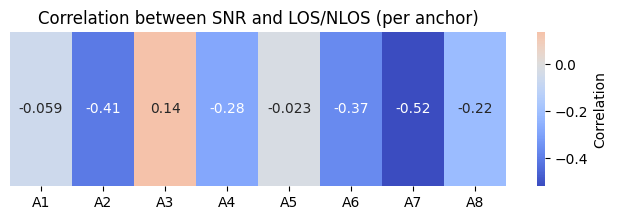

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = []

for a in range(1, 9):
    # Take SNR (batch1 only for simplicity, or concat batch1+batch2)
    snr_batch1 = all_anchor_data[f"anchor_{a}"]["batch1"]["eig_spread"][:]
    snr_batch1=filter_iir(snr_batch1, fc=0.5, order=16, fs=100)

    df_nlos = anchor_nlos[f"anchor_{a}"][:]

    nlos = df_nlos["nlos"].values  # 0=LOS, 1=NLOS

    # Align sizes (just in case lengths mismatch)
    L = min(len(snr_batch1), len(nlos))
    snr = snr_batch1[:L]
    nlos = nlos[:L]

    # Pearson correlation
    corr = np.corrcoef(snr, nlos)[0,1]
    corr_matrix.append(corr)

# Convert to DataFrame (1 row, 8 anchors)
df_corr = pd.DataFrame([corr_matrix], columns=[f"A{a}" for a in range(1,9)])

# Plot heatmap
plt.figure(figsize=(8,2))
sns.heatmap(df_corr, annot=True, cmap="coolwarm", center=0, cbar_kws={'label': 'Correlation'})
plt.title("Correlation between SNR and LOS/NLOS (per anchor)")
plt.yticks([])  # hide y-axis
plt.show()


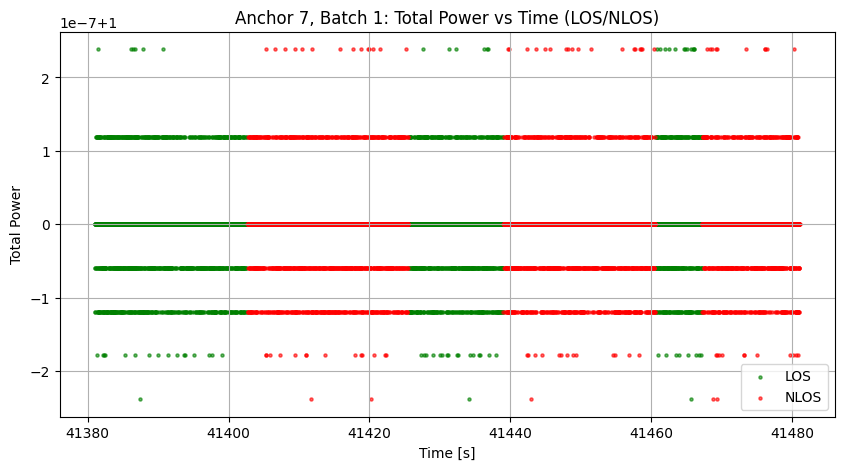

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Import pandas

# Grab the time stamps for anchor 7, batch 1, first 10000 samples
# This data is available in the all_anchor_data structure
anchor_id_to_plot = 7
batch_num_to_plot = 1
num_samples_to_plot = 10000

anchor_key = f"anchor_{anchor_id_to_plot}"
batch_key = f"batch{batch_num_to_plot}"

if anchor_key not in all_anchor_data or batch_key not in all_anchor_data[anchor_key]:
    print(f"Data for Anchor {anchor_id_to_plot}, Batch {batch_num_to_plot} not found.")
else:
    batch_data = all_anchor_data[anchor_key][batch_key]

    if 'time_stamp' in batch_data and 'total_energy' in batch_data: # Assuming total_energy is the power_series
        time_stamp_subset = batch_data["time_stamp"][:num_samples_to_plot]
        power_series_subset = batch_data["total_energy"][:num_samples_to_plot] # Use total_energy if power_series not stored

        # Get the corresponding nlos labels from the anchor_nlos dataframe
        if anchor_key in anchor_nlos:
            df_nlos_anchor = anchor_nlos[anchor_key].copy()

            # Ensure nlos_df is sorted by time_stamp for merge_asof
            df_nlos_anchor = df_nlos_anchor.sort_values('time_stamp').reset_index(drop=True)

            # Create a temporary DataFrame from the subset time stamps
            df_temp_time = pd.DataFrame({'time_stamp': time_stamp_subset})

            # Perform merge_asof for approximate time matching
            merged_nlos = pd.merge_asof(
                df_temp_time,
                df_nlos_anchor[['time_stamp', 'nlos']],
                on='time_stamp',
                direction='nearest',
                tolerance=10e-3 # Use float tolerance in seconds
            )
            nlos_subset = merged_nlos['nlos'].values

            # --- Filter for LOS/NLOS ---
            los_idx = (nlos_subset == 0)
            nlos_idx = (nlos_subset == 1)

            # Ensure the indices have the same length as the data subsets
            min_len_plot = min(len(time_stamp_subset), len(power_series_subset), len(nlos_subset))
            time_stamp_plot = time_stamp_subset[:min_len_plot]
            power_series_plot = power_series_subset[:min_len_plot]
            nlos_plot = nlos_subset[:min_len_plot]

            los_idx_plot = (nlos_plot == 0)
            nlos_idx_plot = (nlos_plot == 1)

            # --- Plot ---
            plt.figure(figsize=(10, 5))
            plt.scatter(time_stamp_plot[los_idx_plot], power_series_plot[los_idx_plot], color='g', s=5, label="LOS", alpha=0.6)
            plt.scatter(time_stamp_plot[nlos_idx_plot], power_series_plot[nlos_idx_plot], color='r', s=5, label="NLOS", alpha=0.6)

            plt.xlabel("Time [s]")
            plt.ylabel("Total Power")
            plt.title(f"Anchor {anchor_id_to_plot}, Batch {batch_num_to_plot}: Total Power vs Time (LOS/NLOS)")
            plt.legend()
            plt.grid(True)
            plt.show()

        else:
            print(f"LOS/NLOS data not found for {anchor_key}.")

    else:
        print(f"Required data ('time_stamp' or 'total_energy') not found in batch data for Anchor {anchor_id_to_plot}, Batch {batch_num_to_plot}.")

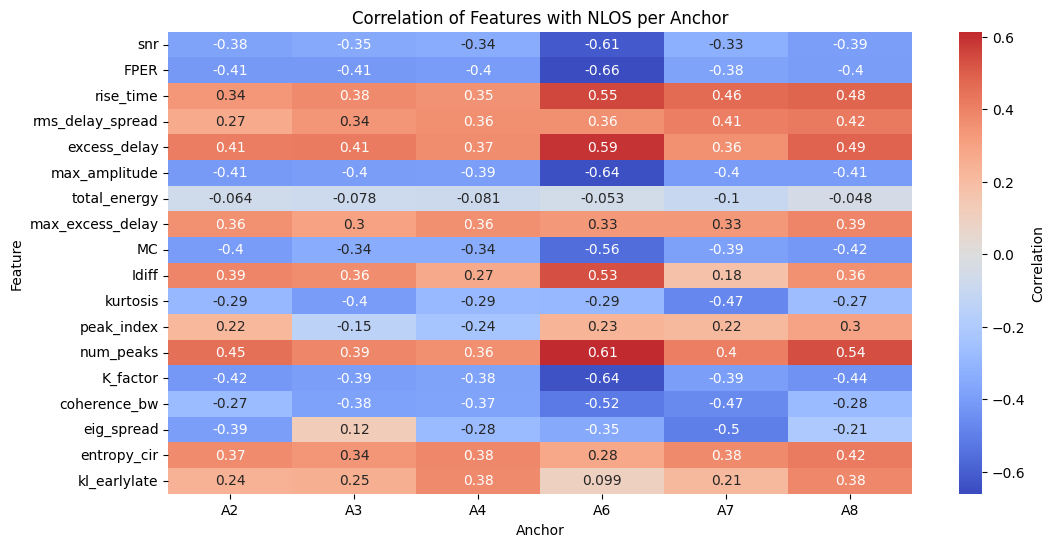

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



features = [
    "snr", "FPER", "rise_time", "rms_delay_spread",
    "excess_delay", "max_amplitude", "total_energy",
    "max_excess_delay", "MC", "Idiff", "kurtosis", "peak_index","num_peaks","K_factor","coherence_bw","eig_spread","entropy_cir","kl_earlylate"
]

corr_results = {}

for a in range(1, 9):  # 8 anchors
    corr_matrix = []
    if a==5 or a==1  :
        continue
    for feat in features:
        # Get feature values (batch1 only for simplicity)
        feat_batch1 = all_anchor_data[f"anchor_{a}"]["batch1"][feat][:]
        feat_batch1 = filter_iir(feat_batch1, fc=1.2, order=16, fs=100)

        df_nlos = anchor_nlos[f"anchor_{a}"][:]
        nlos = df_nlos["nlos"].values  # 0=LOS, 1=NLOS

        # Align sizes
        L = min(len(feat_batch1), len(nlos))
        feat_vals = feat_batch1[:L]
        nlos_vals = nlos[:L]

        # Pearson correlation
        corr = np.corrcoef(feat_vals, nlos_vals)[0, 1]
        corr_matrix.append(corr)

    corr_results[f"A{a}"] = corr_matrix

# Convert to DataFrame (rows=features, cols=anchors)
df_corr = pd.DataFrame(corr_results, index=features)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_corr, annot=True, cmap="coolwarm", center=0, cbar_kws={'label': 'Correlation'})
plt.title("Correlation of Features with NLOS per Anchor")
plt.xlabel("Anchor")
plt.ylabel("Feature")
plt.show()


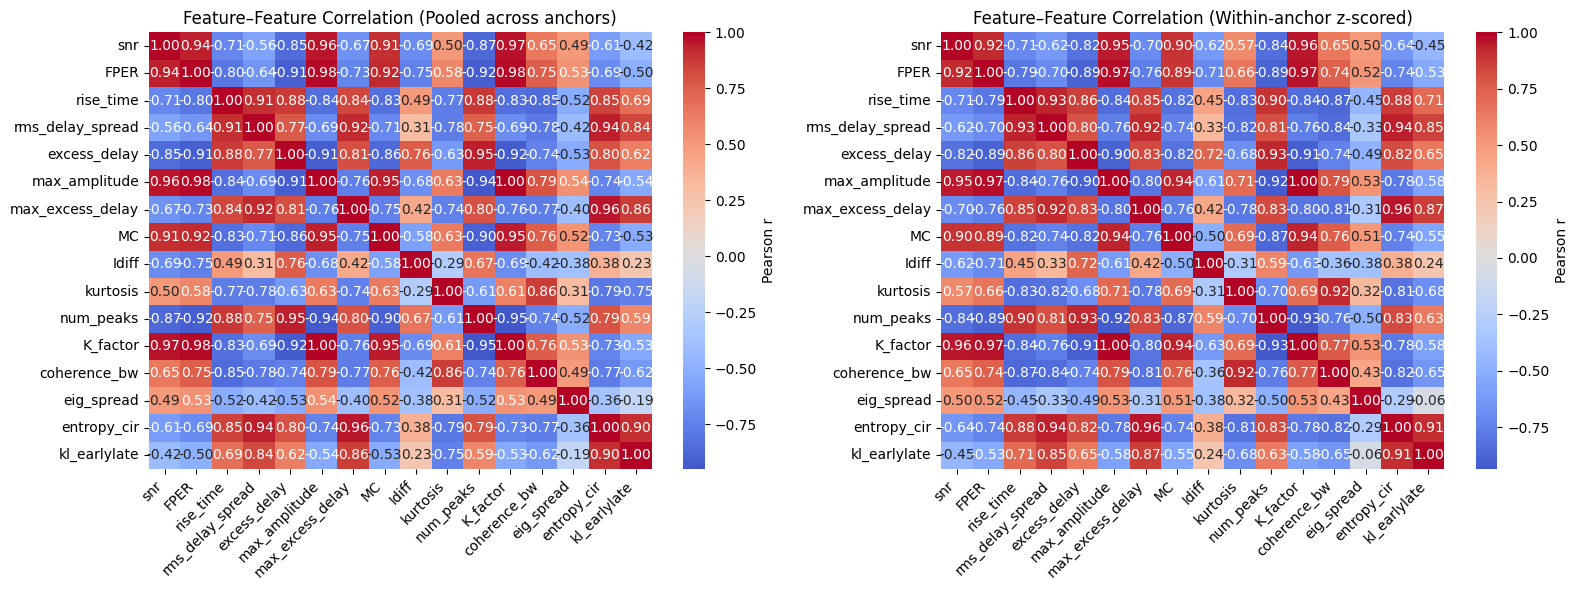

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------- settings --------
features = [
    "snr", "FPER", "rise_time", "rms_delay_spread",
    "excess_delay", "max_amplitude",
    "max_excess_delay", "MC", "Idiff", "kurtosis", "num_peaks","K_factor","coherence_bw","eig_spread","entropy_cir","kl_earlylate"
]
use_filter = True  # keep True to match your previous preprocessing
fc, order, fs = 1.2, 16, 100

# -------- helpers --------
def _safe_1d(x):
    x = np.asarray(x).astype(float).ravel()
    return x

def load_anchor_features(a):
    """Load and align all requested features for one anchor (Batch1), return a clean DataFrame."""
    data = {}
    lengths = []
    for feat in features:
        arr = _safe_1d(all_anchor_data[f"anchor_{a}"]["batch1"][feat][:])
        if use_filter:
            arr = _safe_1d(filter_iir(arr, fc=fc, order=order, fs=fs))
        data[feat] = arr
        lengths.append(len(arr))
    L = min(lengths)
    for feat in features:
        data[feat] = data[feat][:L]
    df = pd.DataFrame(data)
    df["anchor"] = a
    # clean NaN/Inf rows
    df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")
    return df

# -------- build pooled dataset --------
dfs = [load_anchor_features(a) for a in range(1, 9)]
raw_df = pd.concat(dfs, ignore_index=True)

# -------- correlations --------
# 1) Pooled (across anchors)
corr_pooled = raw_df[features].corr(method="pearson")

# 2) Within-anchor (z-score inside each anchor to remove anchor offsets/scales)
Z = raw_df.groupby("anchor")[features].apply(
    lambda g: (g - g.mean()) / g.std(ddof=0)
).reset_index(level=0, drop=True)
corr_within = Z.corr(method="pearson")

# (Optional) Spearman variants (uncomment if useful)
# corr_pooled_spearman = raw_df[features].corr(method="spearman")
# corr_within_spearman = Z.corr(method="spearman")

# -------- visualize --------
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(corr_pooled, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            cbar_kws={'label': 'Pearson r'})
plt.title("Feature–Feature Correlation (Pooled across anchors)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.subplot(1, 2, 2)
sns.heatmap(corr_within, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            cbar_kws={'label': 'Pearson r'})
plt.title("Feature–Feature Correlation (Within-anchor z-scored)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# -------- (Optional) per-anchor matrices --------
# per_anchor_corr = {
#     f"A{a}": load_anchor_features(a)[features].corr(method="pearson") for a in range(1, 9)
# }
# Example to inspect one:
# print(per_anchor_corr["A1"])


In [42]:
import numpy as np
import pandas as pd

# --- Step 1: compute feature–NLOS correlation (using within-anchor z-scored features) ---
nlos_all = []
feat_all = {f: [] for f in features}

for a in range(1, 9):
    # feature data
    df_feat = load_anchor_features(a)  # from the previous code
    # align nlos vector
    df_nlos = anchor_nlos[f"anchor_{a}"][:]
    nlos = df_nlos["nlos"].values
    L = min(len(df_feat), len(nlos))
    nlos = nlos[:L]
    for f in features:
        feat_all[f].extend(df_feat[f].values[:L])
    nlos_all.extend(nlos)

nlos_all = np.array(nlos_all)
feat_all = {f: np.array(vals) for f, vals in feat_all.items()}

# correlations with NLOS (Pearson)
nlos_corr = {f: np.corrcoef(feat_all[f], nlos_all)[0,1] for f in features}
df_nlos_corr = pd.Series(nlos_corr).sort_values(key=np.abs, ascending=False)

print("Correlation of each feature with NLOS:")
print(df_nlos_corr)

# --- Step 2: correlation matrix among features (within-anchor) ---
corr = corr_within.copy().abs()

# --- Step 3: greedy selection ---
selected = []
threshold = 0.8

for feat in df_nlos_corr.index:  # sorted by strongest correlation with NLOS
    if not selected:
        selected.append(feat)
        continue
    # check redundancy
    too_corr = any(corr.loc[feat, s] >= threshold for s in selected)
    if not too_corr:
        selected.append(feat)

print("\nSelected non-redundant, NLOS-relevant features:")
print(selected)


Correlation of each feature with NLOS:
FPER               -0.560353
max_amplitude      -0.552536
K_factor           -0.543485
snr                -0.521744
num_peaks           0.502563
excess_delay        0.473042
MC                 -0.472794
coherence_bw       -0.423980
Idiff               0.408501
rise_time           0.393569
max_excess_delay    0.347236
entropy_cir         0.342956
eig_spread         -0.319781
kurtosis           -0.306351
kl_earlylate        0.282913
rms_delay_spread    0.272799
dtype: float64

Selected non-redundant, NLOS-relevant features:
['FPER', 'coherence_bw', 'Idiff', 'eig_spread', 'kl_earlylate']


=== Correlation of each feature with NLOS ===
FPER               -0.560353
max_amplitude      -0.552536
K_factor           -0.543485
snr                -0.521744
num_peaks           0.502563
excess_delay        0.473042
MC                 -0.472794
coherence_bw       -0.423980
Idiff               0.408501
rise_time           0.393569
max_excess_delay    0.347236
entropy_cir         0.342956
eig_spread         -0.319781
kurtosis           -0.306351
kl_earlylate        0.282913
rms_delay_spread    0.272799
dtype: float64

=== Pearson Cross-Correlation ===
                    snr   FPER  rise_time  rms_delay_spread  excess_delay  \
snr               1.000  0.940     -0.715            -0.563        -0.847   
FPER              0.940  1.000     -0.797            -0.642        -0.909   
rise_time        -0.715 -0.797      1.000             0.906         0.876   
rms_delay_spread -0.563 -0.642      0.906             1.000         0.770   
excess_delay     -0.847 -0.909      0.876             0

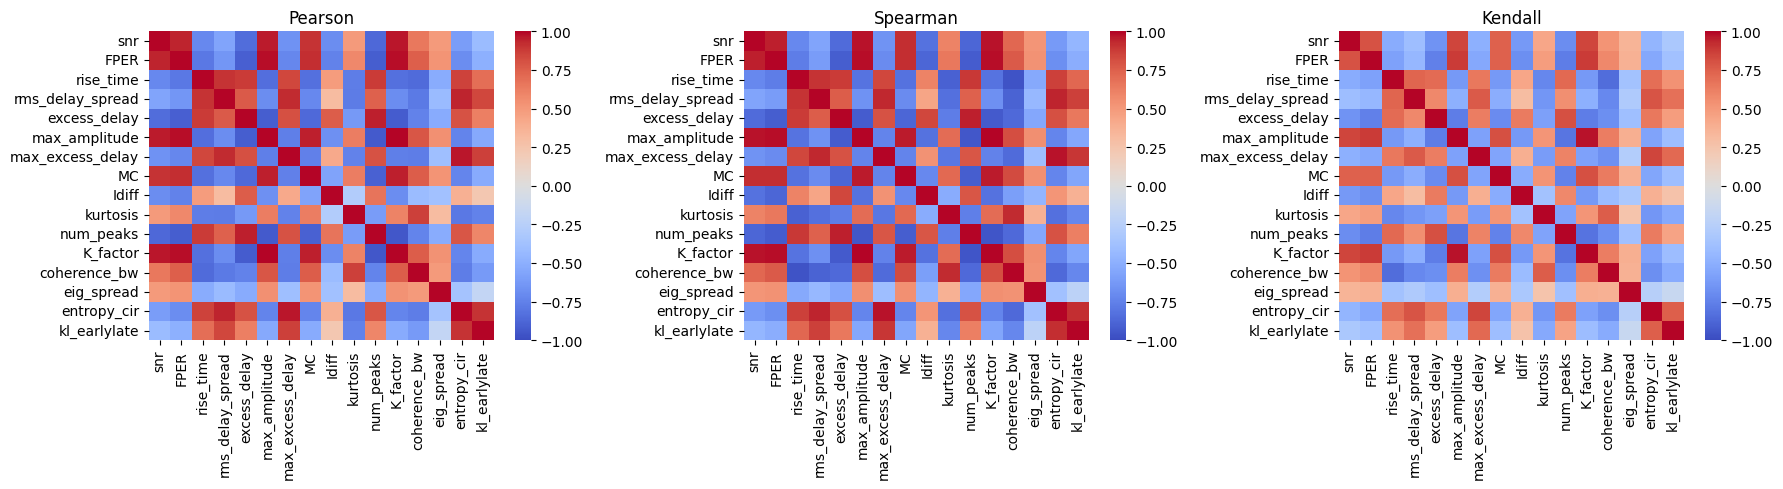


Relaxing threshold - currently have 5 features

=== Selected Features (2 from each category) ===
Total selected features: 6
Selected features: ['kl_earlylate', 'FPER', 'coherence_bw', 'Idiff', 'eig_spread', 'num_peaks']

Category breakdown:
  kl_earlylate: Entropy-related
  FPER: Power-related
  coherence_bw: Time/Frequency-related
  Idiff: Time/Frequency-related
  eig_spread: Entropy-related
  num_peaks: Power-related

Category counts: {'power': 2, 'time_freq': 2, 'entropy': 2}

=== Kendall Cross-correlation among selected features ===
              kl_earlylate   FPER  coherence_bw  Idiff  eig_spread  num_peaks
kl_earlylate         1.000 -0.377        -0.530  0.263      -0.150      0.451
FPER                -0.377  1.000         0.579 -0.687       0.373     -0.768
coherence_bw        -0.530  0.579         1.000 -0.418       0.370     -0.681
Idiff                0.263 -0.687        -0.418  1.000      -0.322      0.581
eig_spread          -0.150  0.373         0.370 -0.322       1.000

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# 1. Compute feature–NLOS correlation (already done)
# ============================================================
nlos_all = []
feat_all = {f: [] for f in features}

for a in range(1, 9):
    df_feat = load_anchor_features(a)
    df_nlos = anchor_nlos[f"anchor_{a}"][:]
    nlos = df_nlos["nlos"].values
    L = min(len(df_feat), len(nlos))
    nlos = nlos[:L]
    for f in features:
        feat_all[f].extend(df_feat[f].values[:L])
    nlos_all.extend(nlos)

nlos_all = np.array(nlos_all)
feat_all = {f: np.array(vals) for f, vals in feat_all.items()}

# Pearson correlation with NLOS
nlos_corr = {f: np.corrcoef(feat_all[f], nlos_all)[0, 1] for f in features}
df_nlos_corr = pd.Series(nlos_corr).sort_values(key=np.abs, ascending=False)

print("=== Correlation of each feature with NLOS ===")
print(df_nlos_corr)

# ============================================================
# 2. Build DataFrame for all features
# ============================================================
df_all = pd.DataFrame(feat_all)

# ============================================================
# 3. Compute correlation matrices (Pearson, Spearman, Kendall)
# ============================================================
corr_pearson = df_all.corr(method='pearson')
corr_spearman = df_all.corr(method='spearman')
corr_kendall = df_all.corr(method='kendall')

print("\n=== Pearson Cross-Correlation ===")
print(corr_pearson.round(3))

print("\n=== Spearman Cross-Correlation ===")
print(corr_spearman.round(3))

print("\n=== Kendall Cross-Correlation ===")
print(corr_kendall.round(3))

# ============================================================
# 4. Visualize heatmaps
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(corr_pearson, cmap="coolwarm", annot=False, vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title("Pearson")

sns.heatmap(corr_spearman, cmap="coolwarm", annot=False, vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title("Spearman")

sns.heatmap(corr_kendall, cmap="coolwarm", annot=False, vmin=-1, vmax=1, ax=axes[2])
axes[2].set_title("Kendall")

plt.tight_layout()
plt.show()

# ============================================================
# 5. Feature categorization
# ============================================================
# Categorize features by domain
power_features = ['snr', 'FPER','num_peaks', 'max_amplitude', 'K_factor']
time_freq_features = ['Idiff','coherence_bw','rise_time', 'rms_delay_spread', 'excess_delay',
                      'max_excess_delay']
entropy_features = ['entropy_cir', 'kl_earlylate', 'kurtosis', 'eig_spread']

# ============================================================
# 6. Custom selection with category constraints - EXACTLY 2 from each
# ============================================================
# Use Kendall correlation for redundancy check
threshold = 0.7  # Adjusted threshold for Kendall (typically lower than Pearson)
selected = []
category_count = {'power': 0, 'time_freq': 0, 'entropy': 0}

# Define requirements - 2 from each category
required_per_category = 2
max_features = 6  # Total: 2 power + 2 time_freq + 2 entropy = 6

# First, ensure kl_earlylate is selected for entropy category
selected.append('kl_earlylate')
category_count['entropy'] = 1

# Process features by NLOS correlation
for feat in df_nlos_corr.index:
    if feat == 'kl_earlylate':
        continue  # Already added

    # Determine feature category
    if feat in power_features:
        category = 'power'
    elif feat in time_freq_features:
        category = 'time_freq'
    elif feat in entropy_features:
        category = 'entropy'
    else:
        continue

    # Skip if we've met the requirement for this category
    if category_count[category] >= required_per_category:
        continue

    # Check redundancy with already selected features using KENDALL
    if selected:
        too_corr = any(abs(corr_kendall.loc[feat, s]) >= threshold for s in selected)
        if too_corr:
            continue

    # Add the feature
    selected.append(feat)
    category_count[category] += 1

    # Check if we've selected exactly 6 features (2 from each category)
    if len(selected) == max_features:
        break

# If we haven't filled all categories, try with relaxed threshold
if len(selected) < max_features:
    print(f"\nRelaxing threshold - currently have {len(selected)} features")
    relaxed_threshold = 0.75

    for relax_iteration in range(3):  # Try progressively relaxing
        if len(selected) == max_features:
            break

        current_threshold = relaxed_threshold + (0.05 * relax_iteration)

        for feat in df_nlos_corr.index:
            if feat in selected:
                continue

            # Determine category
            if feat in power_features:
                category = 'power'
            elif feat in time_freq_features:
                category = 'time_freq'
            elif feat in entropy_features:
                category = 'entropy'
            else:
                continue

            # Skip if category is full
            if category_count[category] >= required_per_category:
                continue

            # Check redundancy with relaxed threshold using KENDALL
            if selected:
                too_corr = any(abs(corr_kendall.loc[feat, s]) >= current_threshold for s in selected)
                if too_corr:
                    continue

            selected.append(feat)
            category_count[category] += 1

            if len(selected) == max_features:
                break

# If still not enough, force selection of top features from missing categories
if len(selected) < max_features:
    print(f"\nForcing selection - currently have {len(selected)} features")

    for category in ['power', 'time_freq', 'entropy']:
        if category_count[category] < required_per_category:
            # Get features from this category not yet selected
            if category == 'power':
                available = [f for f in power_features if f not in selected]
            elif category == 'time_freq':
                available = [f for f in time_freq_features if f not in selected]
            else:  # entropy
                available = [f for f in entropy_features if f not in selected]

            # Sort by NLOS correlation
            available_sorted = sorted(available,
                                    key=lambda x: abs(nlos_corr.get(x, 0)),
                                    reverse=True)

            # Add top features until category requirement is met
            for feat in available_sorted:
                if category_count[category] >= required_per_category:
                    break
                selected.append(feat)
                category_count[category] += 1

                if len(selected) == max_features:
                    break

print("\n=== Selected Features (2 from each category) ===")
print(f"Total selected features: {len(selected)}")
print(f"Selected features: {selected}")
print(f"\nCategory breakdown:")
for feat in selected:
    if feat in power_features:
        print(f"  {feat}: Power-related")
    elif feat in time_freq_features:
        print(f"  {feat}: Time/Frequency-related")
    elif feat in entropy_features:
        print(f"  {feat}: Entropy-related")

print(f"\nCategory counts: {category_count}")

# ============================================================
# 7. Verify correlation among selected features using KENDALL
# ============================================================
print("\n=== Kendall Cross-correlation among selected features ===")
selected_corr_kendall = corr_kendall.loc[selected, selected]
print(selected_corr_kendall.round(3))

# Highlight any high correlations using Kendall threshold
high_corr_pairs = []
kendall_warning_threshold = 0.7  # Threshold for warning with Kendall
for i in range(len(selected)):
    for j in range(i+1, len(selected)):
        corr_val = abs(selected_corr_kendall.iloc[i, j])
        if corr_val >= kendall_warning_threshold:
            high_corr_pairs.append((selected[i], selected[j], corr_val))

if high_corr_pairs:
    print("\n⚠️ Warning: High Kendall correlations detected (≥0.7):")
    for f1, f2, corr in high_corr_pairs:
        print(f"  {f1} - {f2}: {corr:.3f}")
else:
    print("\n✅ All selected features have acceptable Kendall correlations (<0.7)")

# Also show Pearson for comparison
print("\n=== Pearson Cross-correlation among selected features (for comparison) ===")
selected_corr_pearson = corr_pearson.loc[selected, selected]
print(selected_corr_pearson.round(3))

# ============================================================
# 8. Save results
# ============================================================
df_nlos_corr.to_csv("nlos_feature_correlation.csv")
corr_kendall.to_csv("cross_corr_kendall.csv")
corr_pearson.to_csv("cross_corr_pearson.csv")
pd.Series(selected).to_csv("selected_features.csv", index=False)

print("\n✅ Selection complete: 6 features selected (2 per category)")
print(f"Using Kendall correlation with threshold: {threshold}")

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (roc_auc_score, roc_curve, classification_report,
                           confusion_matrix, precision_recall_curve, average_precision_score)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import xgboost as xgb
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
if trajectory_test == 1:
    # ============================================================
    # Config & seeds4
    # ============================================================
    np.random.seed(42)

    selected_features = ['FPER', 'coherence_bw', 'Idiff', 'eig_spread', 'kl_earlylate','num_peaks']

    WIN = 100               # window length
    HOP = 30                # step = 30 -> 70 overlap
    NLOS_VALUE = 1          # your labels: 1 = NLOS (normal), 0 = LOS (anomaly)
    THR_NLOS = 0.99        # fraction of NLOS in a window to call it NLOS
    THR_LOS  = 0.02       # fraction of NLOS in a window to call it LOS
    MAX_TRAIN_SAMPLES = 20000  # Increased for supervised learning
    MAX_TEST_SAMPLES  = 10000
    fc, order, fs = 1.2, 16, 100  # your filter params

    # ============================================================
    # Feature extraction from windows (Enhanced version)
    # ============================================================
    def extract_window_features(X_windows):
        """
        Extract comprehensive statistical features from time windows
        X_windows: (N, WIN, F) - N windows, each WIN samples, F features
        Returns: (N, n_extracted_features) feature matrix
        """
        if len(X_windows) == 0:
            return np.empty((0, 169))  # Return empty array with expected feature count

        N, WIN, F = X_windows.shape
        features = []

        for i in range(N):
            window = X_windows[i]  # (WIN, F)
            window_features = []

            for j in range(F):
                signal = window[:, j]

                # Basic statistics
                window_features.extend([
                    np.mean(signal),
                    np.std(signal),
                    np.min(signal),
                    np.max(signal),
                    np.median(signal),
                    stats.skew(signal) if len(signal) > 2 else 0,
                    stats.kurtosis(signal) if len(signal) > 3 else 0,
                ])

                # Percentiles
                window_features.extend([
                    np.percentile(signal, 5),
                    np.percentile(signal, 25),
                    np.percentile(signal, 75),
                    np.percentile(signal, 95),
                    np.percentile(signal, 75) - np.percentile(signal, 25),  # IQR
                ])

                # Time domain features
                if len(signal) > 1:
                    window_features.extend([
                        np.mean(np.abs(np.diff(signal))),  # Mean absolute difference
                        np.std(np.diff(signal)),            # Std of differences
                    ])
                else:
                    window_features.extend([0, 0])

                window_features.extend([
                    np.sqrt(np.mean(signal**2)),        # RMS
                    np.mean(np.abs(signal)),            # MAV
                    np.var(signal),                      # Variance
                    np.ptp(signal),                      # Peak to peak
                ])

                # Frequency domain features
                if len(signal) > 1:
                    fft_vals = np.abs(np.fft.rfft(signal))
                    fft_freq = np.fft.rfftfreq(len(signal))

                    window_features.extend([
                        np.mean(fft_vals),                  # Mean frequency magnitude
                        np.std(fft_vals),                   # Std frequency magnitude
                        np.max(fft_vals),                   # Max frequency magnitude
                        np.argmax(fft_vals),                # Dominant frequency index
                        np.sum(fft_vals * fft_freq) / np.sum(fft_vals) if np.sum(fft_vals) > 0 else 0,  # Frequency centroid
                        np.median(fft_vals),                # Median frequency magnitude
                    ])
                else:
                    window_features.extend([0, 0, 0, 0, 0, 0])

                # Zero crossing rate
                if len(signal) > 1:
                    zero_crossings = np.sum(np.diff(np.sign(signal - np.mean(signal))) != 0)
                    window_features.append(zero_crossings / len(signal))
                else:
                    window_features.append(0)

                # Energy features
                window_features.extend([
                    np.sum(signal**2),                  # Total energy
                    np.sum(np.abs(signal)),             # Total absolute energy
                ])

            # Cross-feature statistics
            for j1 in range(F):
                for j2 in range(j1+1, F):
                    # Correlation between features
                    if len(window[:, j1]) > 1 and len(window[:, j2]) > 1:
                        corr = np.corrcoef(window[:, j1], window[:, j2])[0, 1]
                        window_features.append(corr if not np.isnan(corr) else 0)

                        # Covariance
                        cov = np.cov(window[:, j1], window[:, j2])[0, 1]
                        window_features.append(cov if not np.isnan(cov) else 0)
                    else:
                        window_features.extend([0, 0])

                    # Ratio of means
                    mean_ratio = np.mean(window[:, j1]) / (np.mean(window[:, j2]) + 1e-10)
                    window_features.append(mean_ratio if not np.isnan(mean_ratio) else 1)

            # Multivariate features (using all features together)
            # Eigenvalues of covariance matrix
            try:
                if window.shape[0] > 1:
                    cov_matrix = np.cov(window.T)
                    eigenvalues = np.linalg.eigvalsh(cov_matrix)
                    window_features.extend([
                        np.max(eigenvalues),
                        np.min(eigenvalues),
                        np.mean(eigenvalues),
                        np.max(eigenvalues) / (np.min(np.abs(eigenvalues)) + 1e-10),  # Condition number
                    ])
                else:
                    window_features.extend([0, 0, 0, 1])
            except:
                window_features.extend([0, 0, 0, 1])

            features.append(window_features)

        return np.array(features)

    # ============================================================
    # Sliding-window builder
    # ============================================================
    def windows_from_series(X, y, win=WIN, hop=HOP, nlos_value=NLOS_VALUE,
                            thr_nlos=THR_NLOS, thr_los=THR_LOS):
        """
        X: (T, F) feature time-series, y: (T,) labels per sample (1=NLOS,0=LOS)
        Returns:
            Xw_nlos: (Nn, win, F)
            Xw_los:  (Nl, win, F)
        """
        T, F = X.shape
        starts = np.arange(0, max(T - win + 1, 0), hop, dtype=int)
        Xw_nlos, Xw_los = [], []

        for s in starts:
            segX = X[s:s+win]
            segy = y[s:s+win]
            if len(segy) < win:
                continue
            frac_nlos = np.mean(segy == nlos_value)
            if frac_nlos >= thr_nlos:
                Xw_nlos.append(segX)
            elif frac_nlos <= thr_los:
                Xw_los.append(segX)

        return (np.array(Xw_nlos) if len(Xw_nlos) else np.empty((0, win, X.shape[1]))), \
              (np.array(Xw_los)  if len(Xw_los)  else np.empty((0, win, X.shape[1])))

    # ============================================================
    # Gather windows across anchors - SEPARATE TRAIN/TEST ANCHORS
    # ============================================================
    print("="*60)
    print("DATA COLLECTION AND PREPROCESSING")
    print("="*60)

    train_anchors = [1,2,3,4,5,6,8]
    test_anchors = [7]

    print(f"Training anchors: {train_anchors}")
    print(f"Testing anchors: {test_anchors}")

    Xw_nlos_train, Xw_los_train = [], []
    Xw_nlos_test, Xw_los_test = [], []

    # Process training anchors
    for a in train_anchors:
        print(f"Processing training anchor {a}...")
        df_feat = load_anchor_features(a)
        y = anchor_nlos[f"anchor_{a}"]["nlos"].values

        # Align
        L = min(len(df_feat), len(y))
        X = df_feat[selected_features].values[:L].astype(np.float64)
        y = y[:L].astype(int)

        # Filter per feature
        for i in range(X.shape[1]):
            X[:, i] = filter_iir(X[:, i], fc=fc, order=order, fs=fs)

        # Clean numeric issues
        X = np.nan_to_num(X, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
        finite_mask = np.isfinite(X).all(axis=1)
        X, y = X[finite_mask], y[finite_mask]

        Xw_nlos, Xw_los = windows_from_series(X, y)
        if len(Xw_nlos):
            Xw_nlos_train.append(Xw_nlos)
        if len(Xw_los):
            Xw_los_train.append(Xw_los)

    # Process testing anchors
    for a in test_anchors:
        print(f"Processing testing anchor {a}...")
        df_feat = load_anchor_features(a)
        y = anchor_nlos[f"anchor_{a}"]["nlos"].values

        # Align
        L = min(len(df_feat), len(y))
        X = df_feat[selected_features].values[:L].astype(np.float64)
        y = y[:L].astype(int)

        # Filter per feature
        for i in range(X.shape[1]):
            X[:, i] = filter_iir(X[:, i], fc=fc, order=order, fs=fs)

        # Clean numeric issues
        X = np.nan_to_num(X, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
        finite_mask = np.isfinite(X).all(axis=1)
        X, y = X[finite_mask], y[finite_mask]

        Xw_nlos, Xw_los = windows_from_series(X, y)
        if len(Xw_nlos):
            Xw_nlos_test.append(Xw_nlos)
        if len(Xw_los):
            Xw_los_test.append(Xw_los)

    # Stack
    Xw_nlos_train = np.vstack(Xw_nlos_train) if len(Xw_nlos_train) else np.empty((0, WIN, len(selected_features)))
    Xw_los_train  = np.vstack(Xw_los_train)  if len(Xw_los_train)  else np.empty((0, WIN, len(selected_features)))
    Xw_nlos_test = np.vstack(Xw_nlos_test) if len(Xw_nlos_test) else np.empty((0, WIN, len(selected_features)))
    Xw_los_test  = np.vstack(Xw_los_test)  if len(Xw_los_test)  else np.empty((0, WIN, len(selected_features)))

    print(f"\nTraining NLOS (normal) windows: {len(Xw_nlos_train)}")
    print(f"Training LOS (anomaly) windows: {len(Xw_los_train)}")
    print(f"Testing NLOS (normal) windows: {len(Xw_nlos_test)}")
    print(f"Testing LOS (anomaly) windows: {len(Xw_los_test)}")

    # Make test sets equal size
    # test_size = min(len(Xw_nlos_test), len(Xw_los_test))
    # if test_size > 0:
    #     if len(Xw_nlos_test) > test_size:
    #         idx = np.random.choice(len(Xw_nlos_test), test_size, replace=False)
    #         Xw_nlos_test = Xw_nlos_test[idx]
    #     if len(Xw_los_test) > test_size:
    #         idx = np.random.choice(len(Xw_los_test), test_size, replace=False)
    #         Xw_los_test = Xw_los_test[idx]

    print(f"\nAfter balancing test set:")
    print(f"Testing NLOS (normal) windows: {len(Xw_nlos_test)}")
    print(f"Testing LOS (anomaly) windows: {len(Xw_los_test)}")

    # Balance and subsample training if needed
    # n_samples = min(len(Xw_nlos_train), len(Xw_los_train), MAX_TRAIN_SAMPLES)

    # if len(Xw_nlos_train) > n_samples:
    #     idx = np.random.choice(len(Xw_nlos_train), n_samples, replace=False)
    #     Xw_nlos_train = Xw_nlos_train[idx]
    #     print(f"Subsampled training NLOS windows to {len(Xw_nlos_train)}")

    # if len(Xw_los_train) > n_samples:
    #     idx = np.random.choice(len(Xw_los_train), n_samples, replace=False)
    #     Xw_los_train = Xw_los_train[idx]
    #     print(f"Subsampled training LOS windows to {len(Xw_los_train)}")

    # ============================================================
    # Extract features from windows
    # ============================================================
    print("\n" + "="*60)
    print("FEATURE EXTRACTION")
    print("="*60)
    print("Extracting features from windows...")

    X_nlos_train_features = extract_window_features(Xw_nlos_train)
    X_los_train_features = extract_window_features(Xw_los_train)
    X_nlos_test_features = extract_window_features(Xw_nlos_test)
    X_los_test_features = extract_window_features(Xw_los_test)

    # Create train and test datasets with labels
    X_train = np.vstack([X_nlos_train_features, X_los_train_features])
    y_train = np.hstack([np.zeros(len(X_nlos_train_features)), np.ones(len(X_los_train_features))])

    X_test = np.vstack([X_nlos_test_features, X_los_test_features])
    y_test = np.hstack([np.zeros(len(X_nlos_test_features)), np.ones(len(X_los_test_features))])

    print(f"Total features extracted: {X_train.shape[1]}")
    print(f"Training samples: {X_train.shape[0]} (NLOS: {len(X_nlos_train_features)}, LOS: {len(X_los_train_features)})")
    print(f"Testing samples: {X_test.shape[0]} (NLOS: {len(X_nlos_test_features)}, LOS: {len(X_los_test_features)})")

    # Handle any NaN or Inf values
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

    # ============================================================
    # Train-Validation Split
    # ============================================================
    print("\n" + "="*60)
    print("DATA SPLITTING")
    print("="*60)

    # Split training data into train and validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print(f"Training set: {len(X_train_split)} samples")
    print(f"Validation set: {len(X_val)} samples")
    print(f"Test set: {len(X_test)} samples")
    print(f"Class distribution in train: NLOS={np.sum(y_train_split==0)}, LOS={np.sum(y_train_split==1)}")
    print(f"Class distribution in val: NLOS={np.sum(y_val==0)}, LOS={np.sum(y_val==1)}")
    print(f"Class distribution in test: NLOS={np.sum(y_test==0)}, LOS={np.sum(y_test==1)}")

    # ============================================================
    # Feature Scaling
    # ============================================================
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # ============================================================
    # XGBoost Model Training - Initial Model
    # ============================================================
    print("\n" + "="*60)
    print("XGBOOST MODEL TRAINING")
    print("="*60)



## we add filter for trajectory 2, because the environments is more complex, have glasses,
## and truck with open window, and oberver material, so we filter the transition due to, we can't
## trust with the labeling technique in this case too much.
elif trajectory_test == 2:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler, RobustScaler
    from sklearn.metrics import (roc_auc_score, roc_curve, classification_report,
                              confusion_matrix, precision_recall_curve, average_precision_score)
    from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
    import xgboost as xgb
    import seaborn as sns
    from scipy import stats
    from scipy.ndimage import binary_dilation, binary_erosion
    import warnings
    warnings.filterwarnings('ignore')

    # ============================================================
    # Config & seeds
    # ============================================================
    np.random.seed(42)

    # selected_features = ['FPER', 'coherence_bw', 'Idiff', 'eig_spread', 'kl_earlylate','num_peaks']
    selected_features= ['FPER', 'num_peaks', 'coherence_bw', 'Idiff', 'max_excess_delay', 'eig_spread']

    WIN = 100               # window length
    HOP = 30                # step = 30 -> 70 overlap
    NLOS_VALUE = 1          # your labels: 1 = NLOS (normal), 0 = LOS (anomaly)
    THR_NLOS = 0.99        # fraction of NLOS in a window to call it NLOS
    THR_LOS  = 0.02       # fraction of NLOS in a window to call it LOS
    MAX_TRAIN_SAMPLES = 20000  # Increased for supervised learning
    MAX_TEST_SAMPLES  = 10000
    fc, order, fs = 1.2, 16, 100  # your filter params

    # Label cleaning parameters
    MIN_STABLE_DURATION = 3.0  # Minimum 1 second stable segments
    GUARD_DURATION = 2       # 0.5 second guard intervals
    MAX_TRANSITIONS_PER_SECOND = 1  # Max 2 transitions per second

    # ============================================================
    # Label Cleaning Functions
    # ============================================================
    def clean_labels_with_guards(y_labels, fs=100, min_stable_duration=1.0,
                                guard_duration=0.5, max_transitions_per_second=2,
                                verbose=False):
        """
        Clean noisy labels by removing rapid transitions and adding guard intervals

        Parameters:
        -----------
        y_labels : array
            Original labels (1=NLOS, 0=LOS)
        fs : int
            Sampling frequency (Hz)
        min_stable_duration : float
            Minimum duration (seconds) for a stable segment to be kept
        guard_duration : float
            Duration (seconds) of guard interval to add at transitions
        max_transitions_per_second : int
            Maximum allowed transitions per second (segments with more are removed)
        verbose : bool
            Whether to print detailed progress

        Returns:
        --------
        cleaned_labels : array
            Cleaned labels with -1 for invalid/guard regions
        valid_mask : array
            Boolean mask indicating valid samples (True = valid)
        """

        y = y_labels.copy().astype(float)
        n_samples = len(y)

        # Convert durations to samples
        min_stable_samples = int(min_stable_duration * fs)
        guard_samples = int(guard_duration * fs)
        window_size = fs  # 1 second window for transition counting

        # Initialize mask for valid samples (all valid initially)
        valid_mask = np.ones(n_samples, dtype=bool)

        # ============================================================
        # STEP 1: Detect and remove high-frequency noise
        # ============================================================
        if verbose:
            print("  Step 1: Detecting high-frequency transitions...")

        # Count transitions in sliding windows
        for i in range(0, n_samples - window_size + 1, window_size // 2):
            window = y[i:i + window_size]
            transitions = np.sum(np.abs(np.diff(window)) > 0)

            # If too many transitions in this window, mark as invalid
            if transitions > max_transitions_per_second:
                valid_mask[i:i + window_size] = False
                if verbose and transitions > max_transitions_per_second * 2:
                    print(f"    Removing noisy region [{i}:{i+window_size}] with {transitions} transitions")

        # ============================================================
        # STEP 2: Find stable segments
        # ============================================================
        if verbose:
            print("  Step 2: Finding stable segments...")

        # Find transition points in the remaining valid data
        valid_labels = y.copy()
        valid_labels[~valid_mask] = -1  # Mark invalid regions

        # Detect transitions (changes in label value)
        diff = np.diff(np.concatenate(([valid_labels[0]], valid_labels)))
        transition_indices = np.where(np.abs(diff) > 0)[0]

        # Add start and end for segment processing
        segment_boundaries = np.concatenate(([0], transition_indices, [n_samples]))

        # ============================================================
        # STEP 3: Remove short unstable segments
        # ============================================================
        if verbose:
            print("  Step 3: Removing short unstable segments...")

        removed_segments = 0
        for i in range(len(segment_boundaries) - 1):
            start_idx = segment_boundaries[i]
            end_idx = segment_boundaries[i + 1]
            segment_length = end_idx - start_idx

            # Skip if segment is already marked invalid
            if not np.any(valid_mask[start_idx:end_idx]):
                continue

            # Remove segments that are too short
            if segment_length < min_stable_samples:
                valid_mask[start_idx:end_idx] = False
                removed_segments += 1
                if verbose and removed_segments <= 5:  # Only show first few
                    label_val = y[start_idx] if start_idx < n_samples else -1
                    print(f"    Removing short segment [{start_idx}:{end_idx}] "
                          f"(length={segment_length/fs:.2f}s, label={label_val})")

        if verbose and removed_segments > 5:
            print(f"    ... and {removed_segments - 5} more short segments")

        # ============================================================
        # STEP 4: Add guard intervals at transitions
        # ============================================================
        if verbose:
            print("  Step 4: Adding guard intervals at transitions...")

        # Rebuild transition indices after cleaning
        clean_labels = y.copy()
        clean_labels[~valid_mask] = -1

        # Find remaining valid transitions
        guard_count = 0
        for i in range(1, n_samples):
            if valid_mask[i] and valid_mask[i-1]:
                # Check if there's a transition between valid samples
                if y[i] != y[i-1]:
                    # Add guard interval before transition
                    guard_start = max(0, i - guard_samples)
                    guard_end = min(n_samples, i + guard_samples)

                    valid_mask[guard_start:guard_end] = False
                    guard_count += 1
                    if verbose and guard_count <= 3:
                        print(f"    Adding guard [{guard_start}:{guard_end}] at transition point {i}")

        if verbose and guard_count > 3:
            print(f"    ... and {guard_count - 3} more guard intervals")

        # ============================================================
        # STEP 5: Additional cleaning - remove isolated valid regions
        # ============================================================
        if verbose:
            print("  Step 5: Removing isolated valid regions...")

        # Use morphological operations to remove small isolated regions
        structure_size = int(0.5 * fs)  # 0.5 second structure

        # Erosion followed by dilation to remove small regions
        valid_mask_morph = binary_erosion(valid_mask,
                                        structure=np.ones(structure_size))
        valid_mask_morph = binary_dilation(valid_mask_morph,
                                          structure=np.ones(structure_size))

        # Update valid mask
        removed_isolated = np.sum(valid_mask) - np.sum(valid_mask_morph)
        if removed_isolated > 0:
            if verbose:
                print(f"    Removed {removed_isolated} isolated samples")
            valid_mask = valid_mask_morph

        # ============================================================
        # STEP 6: Create final cleaned labels
        # ============================================================
        cleaned_labels = y.copy()
        cleaned_labels[~valid_mask] = -1  # Mark invalid/guard regions with -1

        # Statistics
        n_invalid = np.sum(~valid_mask)
        n_valid = np.sum(valid_mask)
        n_nlos = np.sum(cleaned_labels == 1)
        n_los = np.sum(cleaned_labels == 0)

        if verbose:
            print(f"  Cleaning summary: Valid={n_valid}/{n_samples} ({100*n_valid/n_samples:.1f}%), "
                  f"NLOS={n_nlos}, LOS={n_los}")

        return cleaned_labels, valid_mask

    # ============================================================
    # Feature extraction from windows (Enhanced version)
    # ============================================================
    def extract_window_features(X_windows):
        """
        Extract comprehensive statistical features from time windows
        X_windows: (N, WIN, F) - N windows, each WIN samples, F features
        Returns: (N, n_extracted_features) feature matrix
        """
        if len(X_windows) == 0:
            return np.empty((0, 169))  # Return empty array with expected feature count

        N, WIN, F = X_windows.shape
        features = []

        for i in range(N):
            window = X_windows[i]  # (WIN, F)
            window_features = []

            for j in range(F):
                signal = window[:, j]

                # Basic statistics
                window_features.extend([
                    np.mean(signal),
                    np.std(signal),
                    np.min(signal),
                    np.max(signal),
                    np.median(signal),
                    stats.skew(signal) if len(signal) > 2 else 0,
                    stats.kurtosis(signal) if len(signal) > 3 else 0,
                ])

                # Percentiles
                window_features.extend([
                    np.percentile(signal, 5),
                    np.percentile(signal, 25),
                    np.percentile(signal, 75),
                    np.percentile(signal, 95),
                    np.percentile(signal, 75) - np.percentile(signal, 25),  # IQR
                ])

                # Time domain features
                if len(signal) > 1:
                    window_features.extend([
                        np.mean(np.abs(np.diff(signal))),  # Mean absolute difference
                        np.std(np.diff(signal)),            # Std of differences
                    ])
                else:
                    window_features.extend([0, 0])

                window_features.extend([
                    np.sqrt(np.mean(signal**2)),        # RMS
                    np.mean(np.abs(signal)),            # MAV
                    np.var(signal),                      # Variance
                    np.ptp(signal),                      # Peak to peak
                ])

                # Frequency domain features
                if len(signal) > 1:
                    fft_vals = np.abs(np.fft.rfft(signal))
                    fft_freq = np.fft.rfftfreq(len(signal))

                    window_features.extend([
                        np.mean(fft_vals),                  # Mean frequency magnitude
                        np.std(fft_vals),                   # Std frequency magnitude
                        np.max(fft_vals),                   # Max frequency magnitude
                        np.argmax(fft_vals),                # Dominant frequency index
                        np.sum(fft_vals * fft_freq) / np.sum(fft_vals) if np.sum(fft_vals) > 0 else 0,  # Frequency centroid
                        np.median(fft_vals),                # Median frequency magnitude
                    ])
                else:
                    window_features.extend([0, 0, 0, 0, 0, 0])

                # Zero crossing rate
                if len(signal) > 1:
                    zero_crossings = np.sum(np.diff(np.sign(signal - np.mean(signal))) != 0)
                    window_features.append(zero_crossings / len(signal))
                else:
                    window_features.append(0)

                # Energy features
                window_features.extend([
                    np.sum(signal**2),                  # Total energy
                    np.sum(np.abs(signal)),             # Total absolute energy
                ])

            # Cross-feature statistics
            for j1 in range(F):
                for j2 in range(j1+1, F):
                    # Correlation between features
                    if len(window[:, j1]) > 1 and len(window[:, j2]) > 1:
                        corr = np.corrcoef(window[:, j1], window[:, j2])[0, 1]
                        window_features.append(corr if not np.isnan(corr) else 0)

                        # Covariance
                        cov = np.cov(window[:, j1], window[:, j2])[0, 1]
                        window_features.append(cov if not np.isnan(cov) else 0)
                    else:
                        window_features.extend([0, 0])

                    # Ratio of means
                    mean_ratio = np.mean(window[:, j1]) / (np.mean(window[:, j2]) + 1e-10)
                    window_features.append(mean_ratio if not np.isnan(mean_ratio) else 1)

            # Multivariate features (using all features together)
            # Eigenvalues of covariance matrix
            try:
                if window.shape[0] > 1:
                    cov_matrix = np.cov(window.T)
                    eigenvalues = np.linalg.eigvalsh(cov_matrix)
                    window_features.extend([
                        np.max(eigenvalues),
                        np.min(eigenvalues),
                        np.mean(eigenvalues),
                        np.max(eigenvalues) / (np.min(np.abs(eigenvalues)) + 1e-10),  # Condition number
                    ])
                else:
                    window_features.extend([0, 0, 0, 1])
            except:
                window_features.extend([0, 0, 0, 1])

            features.append(window_features)

        return np.array(features)

    # ============================================================
    # Sliding-window builder
    # ============================================================
    def windows_from_series(X, y, win=WIN, hop=HOP, nlos_value=NLOS_VALUE,
                            thr_nlos=THR_NLOS, thr_los=THR_LOS):
        """
        X: (T, F) feature time-series, y: (T,) labels per sample (1=NLOS,0=LOS)
        Returns:
            Xw_nlos: (Nn, win, F)
            Xw_los:  (Nl, win, F)
        """
        T, F = X.shape
        starts = np.arange(0, max(T - win + 1, 0), hop, dtype=int)
        Xw_nlos, Xw_los = [], []

        for s in starts:
            segX = X[s:s+win]
            segy = y[s:s+win]
            if len(segy) < win:
                continue

            # Skip windows with any invalid labels (-1)
            if np.any(segy == -1):
                continue

            frac_nlos = np.mean(segy == nlos_value)
            if frac_nlos >= thr_nlos:
                Xw_nlos.append(segX)
            elif frac_nlos <= thr_los:
                Xw_los.append(segX)

        return (np.array(Xw_nlos) if len(Xw_nlos) else np.empty((0, win, X.shape[1]))), \
              (np.array(Xw_los)  if len(Xw_los)  else np.empty((0, win, X.shape[1])))

    # ============================================================
    # Process anchor with label cleaning
    # ============================================================
    def process_anchor_with_cleaning(anchor_id, df_feat, y_labels, selected_features,
                                    fc, order, fs, min_stable_duration, guard_duration,
                                    max_transitions_per_second, verbose=True):
        """
        Process anchor data with label cleaning
        """
        # Clean labels first
        y_cleaned, valid_mask = clean_labels_with_guards(
            y_labels,
            fs=fs,
            min_stable_duration=min_stable_duration,
            guard_duration=guard_duration,
            max_transitions_per_second=max_transitions_per_second,
            verbose=verbose
        )

        # Align data
        L = min(len(df_feat), len(y_cleaned))
        X = df_feat[selected_features].values[:L].astype(np.float64)
        y = y_cleaned[:L]
        valid = valid_mask[:L]

        # Filter per feature
        for i in range(X.shape[1]):
            X[:, i] = filter_iir(X[:, i], fc=fc, order=order, fs=fs)

        # Clean numeric issues
        X = np.nan_to_num(X, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

        # Keep the cleaned labels (including -1 for invalid regions)
        # The windows_from_series function will skip windows with -1 labels
        finite_mask = np.isfinite(X).all(axis=1)
        X = X[finite_mask]
        y = y[finite_mask]

        return X, y, np.sum(valid_mask)

    # ============================================================
    # Gather windows across anchors - SEPARATE TRAIN/TEST ANCHORS
    # ============================================================
    print("="*60)
    print("DATA COLLECTION AND PREPROCESSING WITH LABEL CLEANING")
    print("="*60)

    train_anchors = [1,2,3,4,5,6,7,8]
    test_anchors = [1,2,3,4,5,6,7,8]

    print(f"Training anchors: {train_anchors}")
    print(f"Testing anchors: {test_anchors}")
    print(f"\nLabel cleaning parameters:")
    print(f"  Min stable duration: {MIN_STABLE_DURATION}s")
    print(f"  Guard duration: {GUARD_DURATION}s")
    print(f"  Max transitions/second: {MAX_TRANSITIONS_PER_SECOND}")

    Xw_nlos_train, Xw_los_train = [], []
    Xw_nlos_test, Xw_los_test = [], []

    total_valid_train = 0
    total_samples_train = 0

    # Process training anchors with cleaning
    print("\n" + "-"*40)
    print("Processing Training Anchors")
    print("-"*40)
    for a in train_anchors:
        print(f"\nAnchor {a}:")
        df_feat = load_anchor_features(a)
        y_raw = anchor_nlos[f"anchor_{a}"]["nlos"].values
        total_samples_train += len(y_raw)

        # Process with label cleaning
        X, y, n_valid = process_anchor_with_cleaning(
            anchor_id=a,
            df_feat=df_feat,
            y_labels=y_raw,
            selected_features=selected_features,
            fc=fc,
            order=order,
            fs=fs,
            min_stable_duration=MIN_STABLE_DURATION,
            guard_duration=GUARD_DURATION,
            max_transitions_per_second=MAX_TRANSITIONS_PER_SECOND,
            verbose=False  # Set to True for detailed output
        )

        total_valid_train += n_valid

        # Create windows (will automatically skip windows with -1 labels)
        Xw_nlos, Xw_los = windows_from_series(X, y)

        print(f"  Valid samples after cleaning: {n_valid}/{len(y_raw)} ({100*n_valid/len(y_raw):.1f}%)")
        print(f"  Windows created - NLOS: {len(Xw_nlos)}, LOS: {len(Xw_los)}")

        if len(Xw_nlos):
            Xw_nlos_train.append(Xw_nlos)
        if len(Xw_los):
            Xw_los_train.append(Xw_los)

    total_valid_test = 0
    total_samples_test = 0

    # Process testing anchors with cleaning
    print("\n" + "-"*40)
    print("Processing Testing Anchors")
    print("-"*40)
    for a in test_anchors:
        print(f"\nAnchor {a}:")
        df_feat = load_anchor_features(a)
        y_raw = anchor_nlos[f"anchor_{a}"]["nlos"].values
        total_samples_test += len(y_raw)

        # Process with label cleaning
        X, y, n_valid = process_anchor_with_cleaning(
            anchor_id=a,
            df_feat=df_feat,
            y_labels=y_raw,
            selected_features=selected_features,
            fc=fc,
            order=order,
            fs=fs,
            min_stable_duration=MIN_STABLE_DURATION,
            guard_duration=GUARD_DURATION,
            max_transitions_per_second=MAX_TRANSITIONS_PER_SECOND,
            verbose=False  # Set to True for detailed output
        )

        total_valid_test += n_valid

        # Create windows (will automatically skip windows with -1 labels)
        Xw_nlos, Xw_los = windows_from_series(X, y)

        print(f"  Valid samples after cleaning: {n_valid}/{len(y_raw)} ({100*n_valid/len(y_raw):.1f}%)")
        print(f"  Windows created - NLOS: {len(Xw_nlos)}, LOS: {len(Xw_los)}")

        if len(Xw_nlos):
            Xw_nlos_test.append(Xw_nlos)
        if len(Xw_los):
            Xw_los_test.append(Xw_los)

    # Stack
    Xw_nlos_train = np.vstack(Xw_nlos_train) if len(Xw_nlos_train) else np.empty((0, WIN, len(selected_features)))
    Xw_los_train  = np.vstack(Xw_los_train)  if len(Xw_los_train)  else np.empty((0, WIN, len(selected_features)))
    Xw_nlos_test = np.vstack(Xw_nlos_test) if len(Xw_nlos_test) else np.empty((0, WIN, len(selected_features)))
    Xw_los_test  = np.vstack(Xw_los_test)  if len(Xw_los_test)  else np.empty((0, WIN, len(selected_features)))

    print("\n" + "="*60)
    print("LABEL CLEANING SUMMARY")
    print("="*60)
    print(f"Training data:")
    print(f"  Total samples before cleaning: {total_samples_train}")
    print(f"  Total valid samples after cleaning: {total_valid_train} ({100*total_valid_train/total_samples_train:.1f}%)")
    print(f"  Removed/guarded samples: {total_samples_train - total_valid_train}")

    print(f"\nTesting data:")
    print(f"  Total samples before cleaning: {total_samples_test}")
    print(f"  Total valid samples after cleaning: {total_valid_test} ({100*total_valid_test/total_samples_test:.1f}%)")
    print(f"  Removed/guarded samples: {total_samples_test - total_valid_test}")

    print(f"\nFinal window counts:")
    print(f"  Training NLOS (normal) windows: {len(Xw_nlos_train)}")
    print(f"  Training LOS (anomaly) windows: {len(Xw_los_train)}")
    print(f"  Testing NLOS (normal) windows: {len(Xw_nlos_test)}")
    print(f"  Testing LOS (anomaly) windows: {len(Xw_los_test)}")

    # Optional: Balance test sets if needed
    # test_size = min(len(Xw_nlos_test), len(Xw_los_test))
    # if test_size > 0:
    #     if len(Xw_nlos_test) > test_size:
    #         idx = np.random.choice(len(Xw_nlos_test), test_size, replace=False)
    #         Xw_nlos_test = Xw_nlos_test[idx]
    #     if len(Xw_los_test) > test_size:
    #         idx = np.random.choice(len(Xw_los_test), test_size, replace=False)
    #         Xw_los_test = Xw_los_test[idx]
    #
    # print(f"\nAfter optional balancing:")
    # print(f"  Testing NLOS (normal) windows: {len(Xw_nlos_test)}")
    # print(f"  Testing LOS (anomaly) windows: {len(Xw_los_test)}")

    # ============================================================
    # Extract features from windows
    # ============================================================
    print("\n" + "="*60)
    print("FEATURE EXTRACTION")
    print("="*60)
    print("Extracting features from cleaned windows...")

    X_nlos_train_features = extract_window_features(Xw_nlos_train)
    X_los_train_features = extract_window_features(Xw_los_train)
    X_nlos_test_features = extract_window_features(Xw_nlos_test)
    X_los_test_features = extract_window_features(Xw_los_test)

    # Create train and test datasets with labels
    X_train = np.vstack([X_nlos_train_features, X_los_train_features])
    y_train = np.hstack([np.zeros(len(X_nlos_train_features)), np.ones(len(X_los_train_features))])

    X_test = np.vstack([X_nlos_test_features, X_los_test_features])
    y_test = np.hstack([np.zeros(len(X_nlos_test_features)), np.ones(len(X_los_test_features))])

    print(f"Total features extracted: {X_train.shape[1]}")
    print(f"Training samples: {X_train.shape[0]} (NLOS: {len(X_nlos_train_features)}, LOS: {len(X_los_train_features)})")
    print(f"Testing samples: {X_test.shape[0]} (NLOS: {len(X_nlos_test_features)}, LOS: {len(X_los_test_features)})")

    # Handle any NaN or Inf values
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

    # ============================================================
    # Train-Validation Split
    # ============================================================
    print("\n" + "="*60)
    print("DATA SPLITTING")
    print("="*60)

    # Split training data into train and validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print(f"Training set: {len(X_train_split)} samples")
    print(f"Validation set: {len(X_val)} samples")
    print(f"Test set: {len(X_test)} samples")
    print(f"Class distribution in train: NLOS={np.sum(y_train_split==0)}, LOS={np.sum(y_train_split==1)}")
    print(f"Class distribution in val: NLOS={np.sum(y_val==0)}, LOS={np.sum(y_val==1)}")
    print(f"Class distribution in test: NLOS={np.sum(y_test==0)}, LOS={np.sum(y_test==1)}")

    # ============================================================
    # Feature Scaling
    # ============================================================
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print("\nData ready for XGBoost training!")
    print("Cleaned labels ensure:")
    print("  - No rapid transitions/noise in labels")
    print("  - Guard intervals around state changes")
    print("  - Only stable segments used for training")
    print("  - Higher quality ground truth for better model performance")

    # ============================================================
    # Ready for XGBoost Model Training
    # ============================================================
    # Uncomment to continue with model training:
    #
    # print("\n" + "="*60)
    # print("XGBOOST MODEL TRAINING")
    # print("="*60)
    #
    # # Calculate scale_pos_weight for class imbalance
    # scale_pos_weight = np.sum(y_train_split == 0) / np.sum(y_train_split == 1)
    # print(f"Scale pos weight (for class balance): {scale_pos_weight:.2f}")
    #
    # # Initial model with default parameters
    # print("\nTraining initial XGBoost model...")
    # xgb_model = xgb.XGBClassifier(
    #     n_estimators=300,
    #     max_depth=6,
    #     learning_rate=0.1,
    #     subsample=0.8,
    #     colsample_bytree=0.8,
    #     scale_pos_weight=scale_pos_weight,
    #     objective='binary:logistic',
    #     eval_metric='auc',
    #     random_state=42,
    #     use_label_encoder=False,
    #     n_jobs=-1
    # )
    #
    # # Train the model
    # xgb_model.fit(
    #     X_train_scaled,
    #     y_train_split,
    #     eval_set=[(X_val_scaled, y_val)],
    #     early_stopping_rounds=50,
    #     verbose=100
    # )

DATA COLLECTION AND PREPROCESSING
Training anchors: [1, 2, 3, 4, 5, 6, 8]
Testing anchors: [7]
Processing training anchor 1...
Processing training anchor 2...
Processing training anchor 3...
Processing training anchor 4...
Processing training anchor 5...
Processing training anchor 6...
Processing training anchor 8...
Processing testing anchor 7...

Training NLOS (normal) windows: 7871
Training LOS (anomaly) windows: 5183
Testing NLOS (normal) windows: 1121
Testing LOS (anomaly) windows: 739

After balancing test set:
Testing NLOS (normal) windows: 1121
Testing LOS (anomaly) windows: 739

FEATURE EXTRACTION
Extracting features from windows...


KeyboardInterrupt: 

In [ ]:
eval_set = [(X_train_scaled, y_train_split), (X_val_scaled, y_val)]
xgb_model.fit(
    X_train_scaled, y_train_split,
    eval_set=eval_set,
    verbose=True
)

[0]	validation_0-auc:0.92250	validation_1-auc:0.89507
[1]	validation_0-auc:0.93568	validation_1-auc:0.90581
[2]	validation_0-auc:0.94320	validation_1-auc:0.91373
[3]	validation_0-auc:0.94711	validation_1-auc:0.91844
[4]	validation_0-auc:0.94992	validation_1-auc:0.92045
[5]	validation_0-auc:0.95273	validation_1-auc:0.92360
[6]	validation_0-auc:0.95657	validation_1-auc:0.92678
[7]	validation_0-auc:0.95797	validation_1-auc:0.92713
[8]	validation_0-auc:0.95956	validation_1-auc:0.92771
[9]	validation_0-auc:0.96053	validation_1-auc:0.92858
[10]	validation_0-auc:0.96157	validation_1-auc:0.92971
[11]	validation_0-auc:0.96300	validation_1-auc:0.93137
[12]	validation_0-auc:0.96383	validation_1-auc:0.93281
[13]	validation_0-auc:0.96472	validation_1-auc:0.93313
[14]	validation_0-auc:0.96626	validation_1-auc:0.93336
[15]	validation_0-auc:0.96715	validation_1-auc:0.93373
[16]	validation_0-auc:0.96818	validation_1-auc:0.93491
[17]	validation_0-auc:0.96928	validation_1-auc:0.93626
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)


MODEL EVALUATION
Train ROC-AUC: 1.000
Validation ROC-AUC: 0.969
Test ROC-AUC: 0.816
Average Precision Score: 0.800

Optimal threshold: 0.298

Classification Report (with optimal threshold):
               precision    recall  f1-score   support

NLOS (Normal)       0.74      0.78      0.76       347
LOS (Anomaly)       0.77      0.73      0.75       347

     accuracy                           0.76       694
    macro avg       0.76      0.76      0.75       694
 weighted avg       0.76      0.76      0.75       694


Confusion Matrix:
True Negatives (NLOS correct): 271
False Positives: 76
False Negatives: 94
True Positives (LOS detected): 253

CROSS-VALIDATION
5-Fold CV ROC-AUC: 0.967 (+/- 0.006)

FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
1. Feature 14: 0.1565
2. Feature 3: 0.1481
3. Feature 19: 0.0358
4. Feature 9: 0.0194
5. Feature 74: 0.0140
6. Feature 10: 0.0124
7. Feature 73: 0.0111
8. Feature 68: 0.0108
9. Feature 179: 0.0106
10. Feature 106: 0.0101
11. Featu

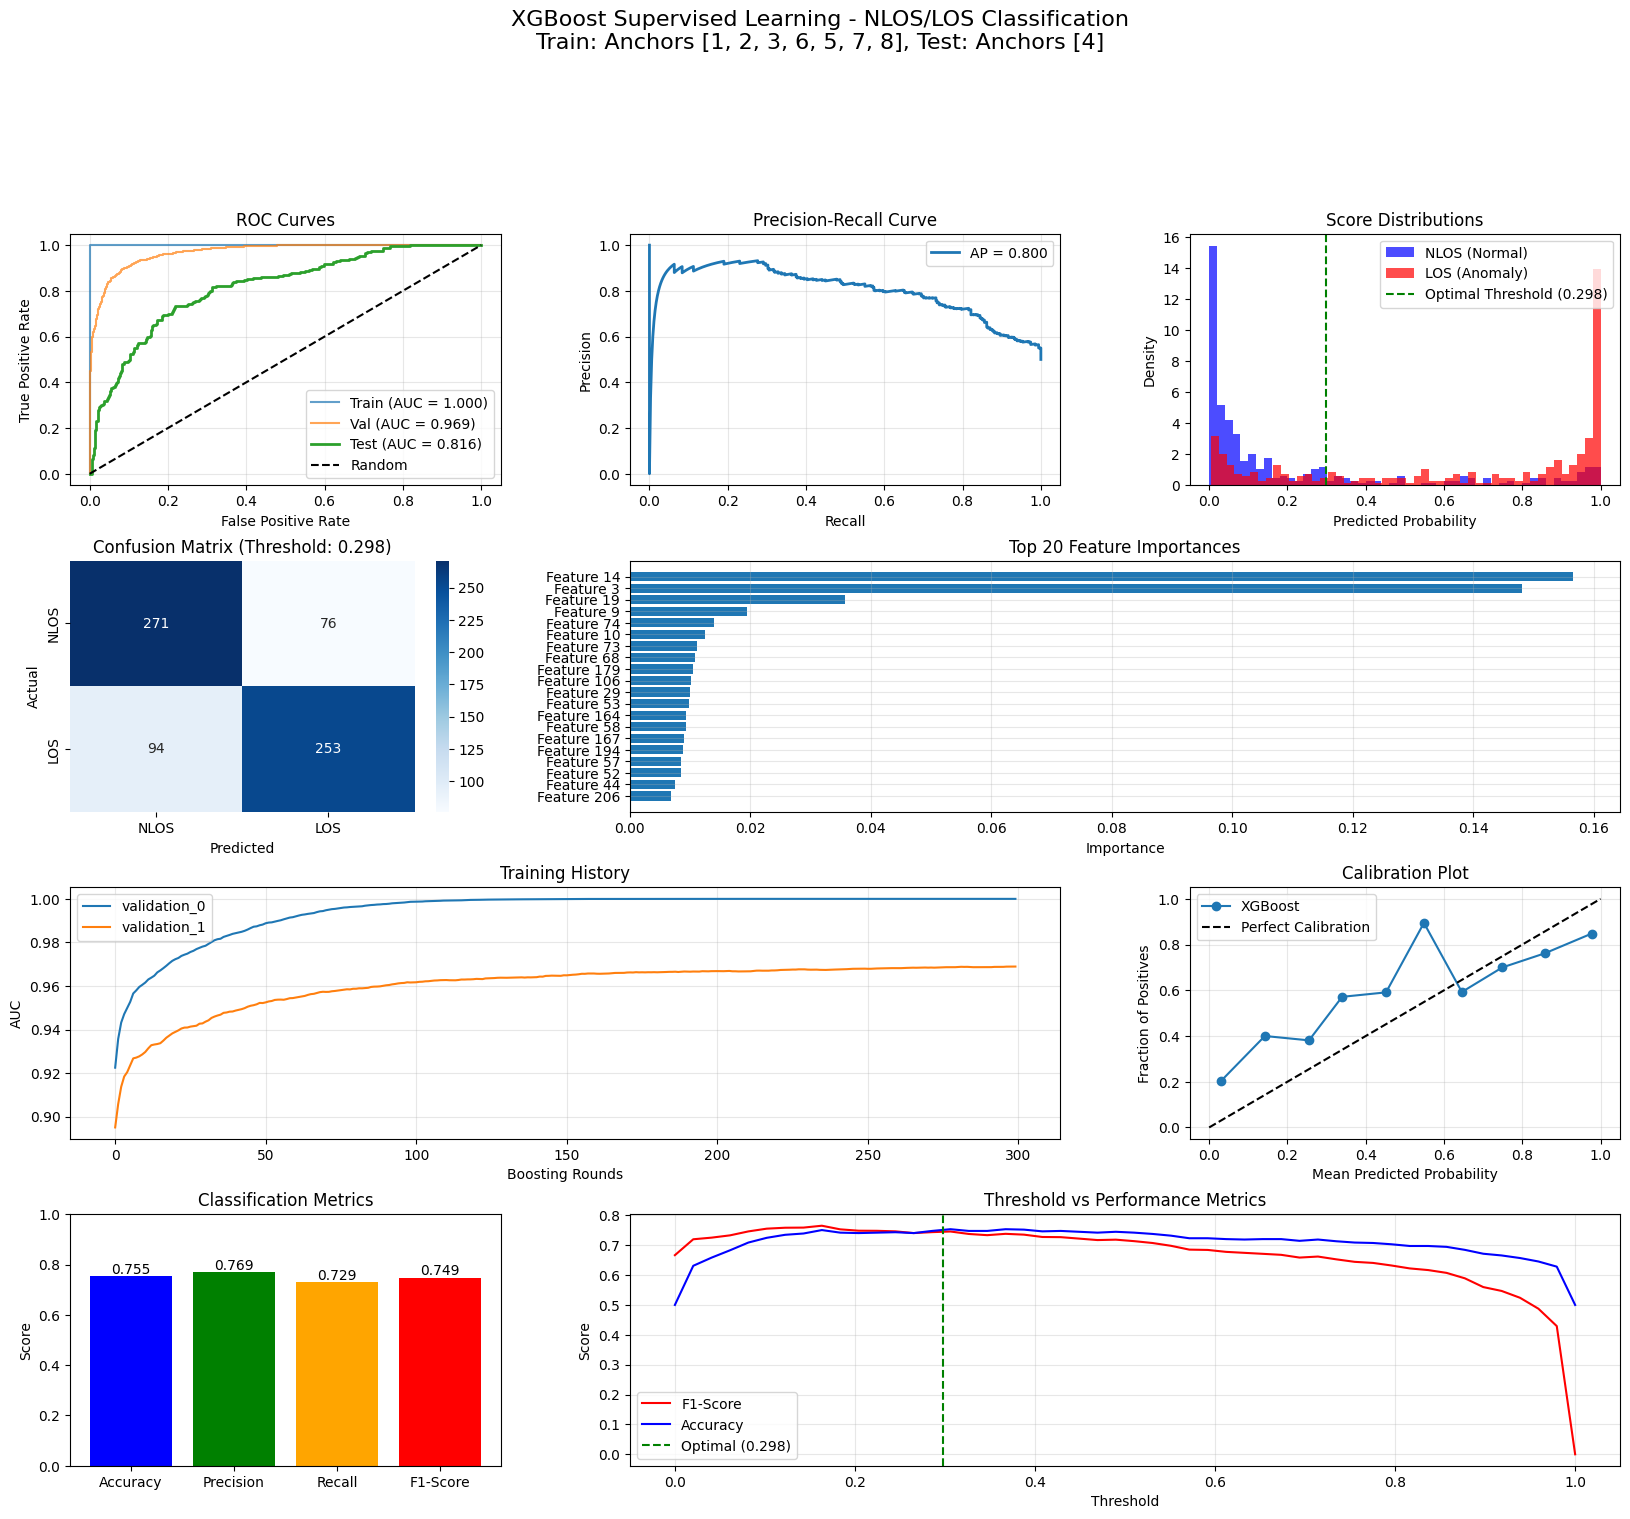


FINAL SUMMARY

✅ Configuration:
   • Features: ['FPER', 'coherence_bw', 'Idiff', 'eig_spread', 'kl_earlylate', 'num_peaks']
   • Window size: 100 samples
   • Hop size: 30 samples (overlap: 70)
   • Train anchors: [1, 2, 3, 6, 5, 7, 8]
   • Test anchors: [4]

📊 XGBoost Performance:
   • Test AUC: 0.8162
   • Test AP Score: 0.7998
   • F1-Score: 0.7485
   • Precision: 0.7690
   • Recall: 0.7291

💡 Data Statistics:
   • Training samples: 11150
   • Testing samples: 694
   • Training NLOS: 5575, LOS: 5575
   • Testing NLOS: 347, LOS: 347
   • Features extracted: 211

🎯 Detection Performance:
   • LOS detection rate: 72.9%
   • NLOS preservation rate: 78.1%

XGBoost Supervised Learning Analysis Complete!


In [ ]:
best_xgb = xgb_model

# ============================================================
# Model Evaluation
# ============================================================
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Predictions
y_pred_proba_train = best_xgb.predict_proba(X_train_scaled)[:, 1]
y_pred_proba_val = best_xgb.predict_proba(X_val_scaled)[:, 1]
y_pred_proba_test = best_xgb.predict_proba(X_test_scaled)[:, 1]

# ROC-AUC Scores
train_auc = roc_auc_score(y_train_split, y_pred_proba_train)
val_auc = roc_auc_score(y_val, y_pred_proba_val)
test_auc = roc_auc_score(y_test, y_pred_proba_test)

print(f"Train ROC-AUC: {train_auc:.3f}")
print(f"Validation ROC-AUC: {val_auc:.3f}")
print(f"Test ROC-AUC: {test_auc:.3f}")

# Average Precision Score
ap_score = average_precision_score(y_test, y_pred_proba_test)
print(f"Average Precision Score: {ap_score:.3f}")

# Find optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal threshold: {optimal_threshold:.3f}")

# Binary predictions with optimal threshold
y_pred_optimal = (y_pred_proba_test > optimal_threshold).astype(int)

# Classification report
print("\nClassification Report (with optimal threshold):")
print(classification_report(y_test, y_pred_optimal,
                          target_names=['NLOS (Normal)', 'LOS (Anomaly)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(f"True Negatives (NLOS correct): {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives (LOS detected): {tp}")

# ============================================================
# Cross-Validation
# ============================================================
print("\n" + "="*60)
print("CROSS-VALIDATION")
print("="*60)

cv_scores = cross_val_score(best_xgb, X_train_scaled, y_train_split, cv=5, scoring='roc_auc')
print(f"5-Fold CV ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

# ============================================================
# Feature Importance Analysis
# ============================================================
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importances
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nTop 20 Most Important Features:")
for i in range(min(20, len(indices))):
    print(f"{i+1}. Feature {indices[i]}: {importances[indices[i]]:.4f}")

# ============================================================
# Visualization
# ============================================================
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# 1. ROC Curves
ax1 = fig.add_subplot(gs[0, 0])
fpr_train, tpr_train, _ = roc_curve(y_train_split, y_pred_proba_train)
fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_proba_val)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)

ax1.plot(fpr_train, tpr_train, label=f'Train (AUC = {train_auc:.3f})', alpha=0.7)
ax1.plot(fpr_val, tpr_val, label=f'Val (AUC = {val_auc:.3f})', alpha=0.7)
ax1.plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})', linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Precision-Recall Curve
ax2 = fig.add_subplot(gs[0, 1])
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_test)
ax2.plot(recall, precision, label=f'AP = {ap_score:.3f}', linewidth=2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Score Distributions
ax3 = fig.add_subplot(gs[0, 2])
ax3.hist(y_pred_proba_test[y_test == 0], bins=50, alpha=0.7,
         label='NLOS (Normal)', density=True, color='blue')
ax3.hist(y_pred_proba_test[y_test == 1], bins=50, alpha=0.7,
         label='LOS (Anomaly)', density=True, color='red')
ax3.axvline(optimal_threshold, color='green', linestyle='--',
            label=f'Optimal Threshold ({optimal_threshold:.3f})')
ax3.set_xlabel('Predicted Probability')
ax3.set_ylabel('Density')
ax3.set_title('Score Distributions')
ax3.legend()

# 4. Confusion Matrix Heatmap
ax4 = fig.add_subplot(gs[1, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['NLOS', 'LOS'], yticklabels=['NLOS', 'LOS'])
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')
ax4.set_title(f'Confusion Matrix (Threshold: {optimal_threshold:.3f})')

# 5. Feature Importance (Top 20)
ax5 = fig.add_subplot(gs[1, 1:])
top_n = 20
top_indices = indices[:top_n]
ax5.barh(range(top_n), importances[top_indices][::-1])
ax5.set_yticks(range(top_n))
ax5.set_yticklabels([f'Feature {i}' for i in top_indices[::-1]])
ax5.set_xlabel('Importance')
ax5.set_title(f'Top {top_n} Feature Importances')
ax5.grid(True, alpha=0.3)

# 6. Learning Curves
ax6 = fig.add_subplot(gs[2, :2])
results = best_xgb.evals_result()
if results:
    epochs = len(results['validation_0']['auc'])
    x_axis = range(0, epochs)

    for i, (name, metric) in enumerate(results.items()):
        ax6.plot(x_axis, metric['auc'], label=name)

    ax6.set_xlabel('Boosting Rounds')
    ax6.set_ylabel('AUC')
    ax6.set_title('Training History')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

# 7. Calibration Plot
ax7 = fig.add_subplot(gs[2, 2])
from sklearn.calibration import calibration_curve
fraction_pos, mean_pred = calibration_curve(y_test, y_pred_proba_test, n_bins=10)
ax7.plot(mean_pred, fraction_pos, marker='o', label='XGBoost')
ax7.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
ax7.set_xlabel('Mean Predicted Probability')
ax7.set_ylabel('Fraction of Positives')
ax7.set_title('Calibration Plot')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Performance Metrics Bar Chart
ax8 = fig.add_subplot(gs[3, 0])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
accuracy = (tn + tp) / (tn + tp + fn + fp)
precision_metric = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision_metric * recall / (precision_metric + recall) if (precision_metric + recall) > 0 else 0
metrics_values = [accuracy, precision_metric, recall, f1]

bars = ax8.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'red'])
ax8.set_ylabel('Score')
ax8.set_title('Classification Metrics')
ax8.set_ylim([0, 1])
for bar, val in zip(bars, metrics_values):
    ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.3f}', ha='center')

# 9. Threshold Analysis
ax9 = fig.add_subplot(gs[3, 1:])
thresholds_to_test = np.linspace(0, 1, 50)
f1_scores = []
accuracies = []
for thr in thresholds_to_test:
    y_pred_thr = (y_pred_proba_test > thr).astype(int)
    tn_t, fp_t, fn_t, tp_t = confusion_matrix(y_test, y_pred_thr).ravel()
    acc_t = (tn_t + tp_t) / (tn_t + tp_t + fn_t + fp_t)
    prec_t = tp_t / (tp_t + fp_t) if (tp_t + fp_t) > 0 else 0
    rec_t = tp_t / (tp_t + fn_t) if (tp_t + fn_t) > 0 else 0
    f1_t = 2 * prec_t * rec_t / (prec_t + rec_t) if (prec_t + rec_t) > 0 else 0
    f1_scores.append(f1_t)
    accuracies.append(acc_t)

ax9.plot(thresholds_to_test, f1_scores, label='F1-Score', color='red')
ax9.plot(thresholds_to_test, accuracies, label='Accuracy', color='blue')
ax9.axvline(optimal_threshold, color='green', linestyle='--',
            label=f'Optimal ({optimal_threshold:.3f})')
ax9.set_xlabel('Threshold')
ax9.set_ylabel('Score')
ax9.set_title('Threshold vs Performance Metrics')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.suptitle(f'XGBoost Supervised Learning - NLOS/LOS Classification\nTrain: Anchors {train_anchors}, Test: Anchors {test_anchors}',
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# ============================================================
# FINAL SUMMARY
# ============================================================
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"\n✅ Configuration:")
print(f"   • Features: {selected_features}")
print(f"   • Window size: {WIN} samples")
print(f"   • Hop size: {HOP} samples (overlap: {WIN-HOP})")
print(f"   • Train anchors: {train_anchors}")
print(f"   • Test anchors: {test_anchors}")

print(f"\n📊 XGBoost Performance:")
print(f"   • Test AUC: {test_auc:.4f}")
print(f"   • Test AP Score: {ap_score:.4f}")
print(f"   • F1-Score: {f1:.4f}")
print(f"   • Precision: {precision_metric:.4f}")
print(f"   • Recall: {recall:.4f}")

print(f"\n💡 Data Statistics:")
print(f"   • Training samples: {len(X_train)}")
print(f"   • Testing samples: {len(X_test)}")
print(f"   • Training NLOS: {len(X_nlos_train_features)}, LOS: {len(X_los_train_features)}")
print(f"   • Testing NLOS: {len(X_nlos_test_features)}, LOS: {len(X_los_test_features)}")
print(f"   • Features extracted: {X_train.shape[1]}")

print(f"\n🎯 Detection Performance:")
print(f"   • LOS detection rate: {100*tp/(tp+fn):.1f}%")
print(f"   • NLOS preservation rate: {100*tn/(tn+fp):.1f}%")

print("\n" + "="*70)
print("XGBoost Supervised Learning Analysis Complete!")
print("="*70)

In [48]:
import numpy as np
import pandas as pd

def get_feature_names(selected_features):
    """
    Generate feature names based on the actual extraction logic
    selected_features: list of original feature names
    Returns: list of all extracted feature names with their indices
    """
    F = len(selected_features)  # Number of original features (6 in your case)
    feature_names = []

    # Per-channel features (27 features per channel)
    stat_names = [
        # Basic statistics (7)
        'mean', 'std', 'min', 'max', 'median', 'skewness', 'kurtosis',
        # Percentiles (5)
        'percentile_5', 'percentile_25', 'percentile_75', 'percentile_95', 'IQR',
        # Time domain features (2)
        'mean_abs_diff', 'std_diff',
        # Additional stats (4)
        'RMS', 'MAV', 'variance', 'peak_to_peak',
        # Frequency domain features (6)
        'freq_mean_mag', 'freq_std_mag', 'freq_max_mag', 'freq_dominant_idx',
        'freq_centroid', 'freq_median_mag',
        # Zero crossing rate (1)
        'zero_crossing_rate',
        # Energy features (2)
        'total_energy', 'total_abs_energy'
    ]

    # Generate per-channel feature names (27 * 6 = 162 features)
    for j in range(F):
        for stat in stat_names:
            feature_names.append(f"{selected_features[j]}_{stat}")

    # Cross-feature statistics (15 pairs * 3 stats = 45 features)
    for j1 in range(F):
        for j2 in range(j1+1, F):
            feature_names.append(f"corr_{selected_features[j1]}_{selected_features[j2]}")
            feature_names.append(f"cov_{selected_features[j1]}_{selected_features[j2]}")
            feature_names.append(f"mean_ratio_{selected_features[j1]}_{selected_features[j2]}")

    # Multivariate features (4 features)
    feature_names.extend([
        'eigenvalue_max',
        'eigenvalue_min',
        'eigenvalue_mean',
        'eigenvalue_condition_number'
    ])

    return feature_names

def calculate_expected_features(selected_features):
    """
    Calculate the expected number of features based on extraction logic
    """
    F = len(selected_features)

    # Per-feature statistics: 27 stats per feature
    per_feature_stats = F * 27

    # Cross-feature statistics: C(F,2) * 3 = F*(F-1)/2 * 3
    cross_feature_pairs = F * (F - 1) // 2
    cross_feature_stats = cross_feature_pairs * 3

    # Multivariate features: 4 features
    multivariate_stats = 4

    total = per_feature_stats + cross_feature_stats + multivariate_stats

    print(f"Feature calculation for {F} input features:")
    print(f"  - Per-feature stats: {per_feature_stats} ({F} features × 27 stats)")
    print(f"  - Cross-feature stats: {cross_feature_stats} ({cross_feature_pairs} pairs × 3 stats)")
    print(f"  - Multivariate stats: {multivariate_stats}")
    print(f"  - Total expected: {total}")

    return total

def decode_top_features(importances, selected_features, top_n=20):
    """
    Decode the top N important features
    importances: array of feature importances from XGBoost
    selected_features: list of original feature names
    top_n: number of top features to display
    Returns: DataFrame with feature indices, names, and importances
    """
    # Get all feature names
    feature_names = get_feature_names(selected_features)
    expected_features = calculate_expected_features(selected_features)

    print(f"\nFeature names generated: {len(feature_names)}")
    print(f"Importances array length: {len(importances)}")

    if len(feature_names) != len(importances):
        print(f"WARNING: Mismatch between expected features ({len(feature_names)}) and importance array ({len(importances)})")

    # Get indices sorted by importance
    indices = np.argsort(importances)[::-1]

    # Create results for top N features
    results = []
    for i in range(min(top_n, len(indices))):
        idx = indices[i]
        results.append({
            'Rank': i + 1,
            'Feature_Index': idx,
            'Feature_Name': feature_names[idx] if idx < len(feature_names) else f'Unknown_Feature_{idx}',
            'Importance': importances[idx],
            'Feature_Type': get_feature_type(idx, selected_features)
        })

    return pd.DataFrame(results)

def get_feature_type(feature_idx, selected_features):
    """
    Determine the type and source of a feature based on its index
    """
    F = len(selected_features)

    # Per-feature statistics (0 to F*27-1)
    per_feature_end = F * 27
    if feature_idx < per_feature_end:
        feature_num = feature_idx // 27
        stat_num = feature_idx % 27
        stat_names = [
            'mean', 'std', 'min', 'max', 'median', 'skewness', 'kurtosis',
            'percentile_5', 'percentile_25', 'percentile_75', 'percentile_95', 'IQR',
            'mean_abs_diff', 'std_diff', 'RMS', 'MAV', 'variance', 'peak_to_peak',
            'freq_mean_mag', 'freq_std_mag', 'freq_max_mag', 'freq_dominant_idx',
            'freq_centroid', 'freq_median_mag', 'zero_crossing_rate',
            'total_energy', 'total_abs_energy'
        ]
        return f"Per-feature ({selected_features[feature_num]} - {stat_names[stat_num]})"

    # Cross-feature statistics
    cross_feature_end = per_feature_end + (F * (F-1) // 2) * 3
    if feature_idx < cross_feature_end:
        return "Cross-feature"

    # Multivariate statistics
    if feature_idx < cross_feature_end + 4:
        multivariate_names = ['eigenvalue_max', 'eigenvalue_min', 'eigenvalue_mean', 'eigenvalue_condition_number']
        multivariate_idx = feature_idx - cross_feature_end
        return f"Multivariate ({multivariate_names[multivariate_idx]})"

    return "Unknown"

# Usage with your data
selected_features = ['FPER', 'coherence_bw', 'Idiff', 'eig_spread', 'kl_earlylate', 'num_peaks']

# Calculate expected features
expected_features = calculate_expected_features(selected_features)

# Create corrected mock importances based on actual feature count
mock_importances = np.zeros(expected_features)  # Use actual expected feature count




# Top 20 Most Important Features:
# 1. Feature 30: 0.0225
# 2. Feature 179: 0.0189
# 3. Feature 71: 0.0161
# 4. Feature 68: 0.0122
# 5. Feature 44: 0.0121
# 6. Feature 115: 0.0120
# 7. Feature 174: 0.0120
# 8. Feature 176: 0.0110
# 9. Feature 62: 0.0106
# 10. Feature 188: 0.0102
# 11. Feature 142: 0.0101
# 12. Feature 54: 0.0095
# 13. Feature 3: 0.0093
# 14. Feature 147: 0.0091
# 15. Feature 84: 0.0090
# 16. Feature 137: 0.0089
# 17. Feature 10: 0.0087
# 18. Feature 171: 0.0087
# 19. Feature 16: 0.0087
# 20. Feature 107: 0.0083
top_20_indices = [    3, 14, 19, 9, 0,
    167, 118, 135, 39, 29,
    68, 57, 74, 179, 73,
    64, 138, 164, 34, 15]
top_20_values =  [  0.1611, 0.0580, 0.0370, 0.0264, 0.0218,
    0.0149, 0.0114, 0.0100, 0.0093, 0.0093,
    0.0092, 0.0089, 0.0088, 0.0086, 0.0085,
    0.0083, 0.0083, 0.0074, 0.0073, 0.0071]

# Your top 20 values (adjusted to fit within the correct range)
# top_20_indices = [3, 14, 25, 19, 15, 135, 9, 149, 29, 39, 57, 52, 69, 179, 164, 34, 170, 138, 44, 100]
# top_20_values = [0.1482, 0.0679, 0.0510, 0.0221, 0.0207, 0.0143, 0.0134, 0.0130,
#                  0.0123, 0.0108, 0.0095, 0.0089, 0.0085, 0.0082, 0.0081, 0.0078,
#                  0.0073, 0.0073, 0.0071, 0.0070]

# Filter indices that are within the valid range
valid_indices = []
valid_values = []
for idx, val in zip(top_20_indices, top_20_values):
    if idx < expected_features:
        valid_indices.append(idx)
        valid_values.append(val)
        mock_importances[idx] = val
    else:
        print(f"Warning: Index {idx} exceeds feature count {expected_features}, skipping")

print(f"\nUsing {len(valid_indices)} valid indices out of {len(top_20_indices)} provided")

# Decode the features
df_features = decode_top_features(mock_importances, selected_features, top_n=len(valid_indices))
print("\nDecoded Top Features:")
print("=" * 80)
print(df_features.to_string(index=False))

# You can also save to CSV
# df_features.to_csv('top_features_decoded.csv', index=False)

print("\n" + "=" * 80)
print("To use with your actual XGBoost model:")
print("df_features = decode_top_features(best_xgb.feature_importances_, selected_features, top_n=20)")
print("print(df_features.to_string(index=False))")

Feature calculation for 6 input features:
  - Per-feature stats: 162 (6 features × 27 stats)
  - Cross-feature stats: 45 (15 pairs × 3 stats)
  - Multivariate stats: 4
  - Total expected: 211

Using 20 valid indices out of 20 provided
Feature calculation for 6 input features:
  - Per-feature stats: 162 (6 features × 27 stats)
  - Cross-feature stats: 45 (15 pairs × 3 stats)
  - Multivariate stats: 4
  - Total expected: 211

Feature names generated: 211
Importances array length: 211

Decoded Top Features:
 Rank  Feature_Index                  Feature_Name  Importance                               Feature_Type
    1              3                      FPER_max      0.1611                   Per-feature (FPER - max)
    2             14                      FPER_RMS      0.0580                   Per-feature (FPER - RMS)
    3             19             FPER_freq_std_mag      0.0370          Per-feature (FPER - freq_std_mag)
    4              9            FPER_percentile_75      0.0264    

In [ ]:
X_train_scaled.shape

(10443, 211)

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


top_20_indices = [    3, 14, 19, 9, 0,
    167, 118, 135, 39, 29,
    68, 57, 74, 179, 73,
    64, 138, 164, 34, 15]
top_20_values =  [  0.1611, 0.0580, 0.0370, 0.0264, 0.0218,
    0.0149, 0.0114, 0.0100, 0.0093, 0.0093,
    0.0092, 0.0089, 0.0088, 0.0086, 0.0085,
    0.0083, 0.0083, 0.0074, 0.0073, 0.0071]

# Top 20 feature indices from the original analysis (corrected for valid range)
# Filtered to only include indices < 211 (actual feature count)
# top_20_indices = [30, 179, 71, 68, 44, 115, 174, 176, 62, 188, 142, 54, 3, 147, 84, 137, 10, 171, 16, 107]

# top_20_indices = [3, 14, 25, 19, 15, 135, 9, 149, 29, 39, 57, 52, 69, 164, 34, 170, 138, 44, 100, 120]
TOP_20_INDICES = top_20_indices  # Fix the missing variable

# Top 20 feature names (adjusted for valid indices)
TOP_20_NAMES = [
    "FPER_max",
    "FPER_RMS",
    "FPER_freq_std_mag",
    "FPER_percentile_75",
    "FPER_mean",
    "mean_ratio_FPER_Idiff",
    "kl_earlylate_percentile_95",
    "num_peaks_mean",
    "coherence_bw_mean_abs_diff",
    "coherence_bw_min",
    "Idiff_RMS",
    "Idiff_max",
    "Idiff_freq_max_mag",
    "mean_ratio_coherence_bw_Idiff",
    "Idiff_freq_std_mag",
    "num_peaks_max",
    "Idiff_percentile_95",
    "mean_ratio_FPER_coherence_bw",
    "coherence_bw_percentile_5",
    "FPER_MAV"
]


print("="*60)
print("BASELINE ISOLATION FOREST")
print("Training on NLOS (normal) → Detecting LOS (anomaly)")
print("="*60)
print(f"Using anchor-based split: Train anchors {train_anchors}, Test anchors {test_anchors}")

# Use the anchor-based split data from your XGBoost code
# Ensure we're using the same data that was used for XGBoost training
print(f"\nVerifying data availability:")
print(f"  • X_train_scaled shape: {X_train_scaled.shape}")
print(f"  • X_val_scaled shape: {X_val_scaled.shape}")
print(f"  • X_test_scaled shape: {X_test_scaled.shape}")

# Validate feature indices
valid_indices = [idx for idx in TOP_20_INDICES if idx < X_train_scaled.shape[1]]
if len(valid_indices) != len(TOP_20_INDICES):
    print(f"Warning: {len(TOP_20_INDICES) - len(valid_indices)} indices exceed feature count")
    print(f"Using {len(valid_indices)} valid indices")
    TOP_20_INDICES = valid_indices
    TOP_20_NAMES = TOP_20_NAMES[:len(valid_indices)]

# # Select top features
X_train_top20 = X_train_scaled[:, TOP_20_INDICES]
X_val_top20 = X_val_scaled[:, TOP_20_INDICES]
X_test_top20 = X_test_scaled[:, TOP_20_INDICES]

# X_train_top20 = X_train_scaled[:, :]
# X_val_top20 = X_val_scaled[:, :]
# X_test_top20 = X_test_scaled[:, :]

# Separate NLOS (normal) for training, using the anchor-based labels
X_train_nlos = X_train_top20[y_train_split == 0]  # Use y_train_split from anchor split
X_val_nlos = X_val_top20[y_val == 0]
X_val_los = X_val_top20[y_val == 1]
X_test_nlos = X_test_top20[y_test == 0]
X_test_los = X_test_top20[y_test == 1]

print(f"\nDataset Configuration:")
print(f"  • Features: {X_train_top20.shape[1]}")
print(f"  • Training NLOS (normal): {len(X_train_nlos)}")
print(f"  • Validation NLOS: {len(X_val_nlos)}, LOS: {len(X_val_los)}")
print(f"  • Test NLOS: {len(X_test_nlos)}, LOS: {len(X_test_los)}")


BASELINE ISOLATION FOREST
Training on NLOS (normal) → Detecting LOS (anomaly)
Using anchor-based split: Train anchors [1, 2, 3, 4, 5, 6, 8], Test anchors [7]

Verifying data availability:
  • X_train_scaled shape: (10443, 211)
  • X_val_scaled shape: (2611, 211)
  • X_test_scaled shape: (1860, 211)

Dataset Configuration:
  • Features: 20
  • Training NLOS (normal): 6297
  • Validation NLOS: 1574, LOS: 1037
  • Test NLOS: 1121, LOS: 739


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score, average_precision_score
)
from sklearn.preprocessing import RobustScaler
import time
import torch
import warnings
warnings.filterwarnings('ignore')

print("COMPREHENSIVE DEEPOD ALGORITHM EVALUATION")
print("Testing ALL available algorithms from DeepOD installation")
print("IMPORTANT: NLOS = Normal (0), LOS = Anomaly (1)")
print(f"Using anchor-based split: Train anchors {train_anchors}, Test anchors {test_anchors}")
print("="*70)

# -------------------------------------------------------------------
# Choose algorithms
# -------------------------------------------------------------------
available_algorithms = {}
# algorithm_list = ['USAD']  # add more if you want
algorithm_list = ['USAD' ,
     'AnomalyTransformer',   'DeepIsolationForestTS',
      'DeepSADTS',
      'GOAD', 'ICL', 'NeuTraL',  'PReNetTS', 'RCA', 'RDP',
     'REPEN',  'SLAD', 'TcnED', 'TimesNet'   ]
for algo_name in algorithm_list:
    try:
        exec(f"from deepod.models import {algo_name}")
        available_algorithms[algo_name] = eval(algo_name)
        print(f"✓ Imported {algo_name}")
    except ImportError:
        try:
            exec(f"from deepod.models.tabular import {algo_name}")
            available_algorithms[algo_name] = eval(algo_name)
            print(f"✓ Imported {algo_name} from tabular")
        except ImportError:
            try:
                exec(f"from deepod.models.time_series import {algo_name}")
                available_algorithms[algo_name] = eval(algo_name)
                print(f"✓ Imported {algo_name} from time_series")
            except ImportError:
                print(f"✗ Could not import {algo_name}")

print(f"\nSuccessfully imported {len(available_algorithms)} algorithms")

# -------------------------------------------------------------------
# Data prep (anchor-based split) + feature selection
# -------------------------------------------------------------------
try:
    print(f"\nChecking anchor-based split data:")
    print(f"X_train_scaled shape: {X_train_scaled.shape}")
    print(f"y_train_split shape: {y_train_split.shape}")
    print(f"X_val_scaled shape: {X_val_scaled.shape}")
    print(f"y_val shape: {y_val.shape}")
    print(f"X_test_scaled shape: {X_test_scaled.shape}")
    print(f"y_test shape: {y_test.shape}")

    n_features = X_train_scaled.shape[1]
    print(f"Available features: {n_features}")

    if 'TOP_20_INDICES' in locals() or 'TOP_20_INDICES' in globals():
        feature_indices = TOP_20_INDICES
        print(f"Using existing feature selection: {len(feature_indices)} features")
    else:
        feature_indices = list(range(min(20, n_features))) if n_features >= 20 else list(range(n_features))
        print(f"Using first {len(feature_indices)} features")

    X_train20 = X_train_scaled[:, feature_indices]
    X_val20   = X_val_scaled[:, feature_indices]
    X_test20  = X_test_scaled[:, feature_indices]

except NameError as e:
    print(f"ERROR: Required anchor-split variables not found: {e}")
    print("Please define: X_train_scaled, y_train_split, X_val_scaled, y_val, X_test_scaled, y_test, train_anchors, test_anchors.")
    raise

print(f"\nAnchor-Based Data Statistics:")
print(f"Training set: {X_train20.shape}")
print(f"  NLOS (normal): {np.sum(y_train_split == 0):,} samples ({np.sum(y_train_split == 0)/len(y_train_split)*100:.1f}%)")
print(f"  LOS (anomaly): {np.sum(y_train_split == 1):,} samples ({np.sum(y_train_split == 1)/len(y_train_split)*100:.1f}%)")
print(f"Test set: {X_test20.shape}")
print(f"  NLOS (normal): {np.sum(y_test == 0):,} samples ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  LOS (anomaly): {np.sum(y_test == 1):,} samples ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")

X_train20_robust = X_train20
X_val20_robust   = X_val20
X_test20_robust  = X_test20

X_train_nlos = X_train20_robust[y_train_split == 0]
X_val_nlos   = X_val20_robust[y_val == 0]
X_val_los    = X_val20_robust[y_val == 1]
X_test_nlos  = X_test20_robust[y_test == 0]
X_test_los   = X_test20_robust[y_test == 1]

X_val_balanced = np.vstack([X_val_nlos, X_val_los])
y_val_balanced = np.hstack([np.zeros(len(X_val_nlos), int), np.ones(len(X_val_los), int)])

print(f"\nProcessed Dataset Statistics:")
print(f"  Training NLOS only: {X_train_nlos.shape[0]:,} samples (from anchors {train_anchors})")
print(f"  Validation: {X_val_balanced.shape[0]:,} samples ({len(X_val_nlos):,} NLOS, {len(X_val_los):,} LOS)")
print(f"  Test: {X_test20_robust.shape[0]:,} samples ({len(X_test_nlos):,} NLOS, {len(X_test_los):,} LOS) (from anchors {test_anchors})")

COMPREHENSIVE DEEPOD ALGORITHM EVALUATION
Testing ALL available algorithms from DeepOD installation
IMPORTANT: NLOS = Normal (0), LOS = Anomaly (1)
Using anchor-based split: Train anchors [1, 2, 3, 4, 5, 6, 8], Test anchors [7]
✓ Imported USAD
✓ Imported AnomalyTransformer
✓ Imported DeepIsolationForestTS
✓ Imported DeepSADTS
✓ Imported GOAD
✓ Imported ICL
✓ Imported NeuTraL
✓ Imported PReNetTS
✓ Imported RCA
✓ Imported RDP
✓ Imported REPEN
✓ Imported SLAD
✓ Imported TcnED
✓ Imported TimesNet

Successfully imported 14 algorithms

Checking anchor-based split data:
X_train_scaled shape: (10443, 211)
y_train_split shape: (10443,)
X_val_scaled shape: (2611, 211)
y_val shape: (2611,)
X_test_scaled shape: (1860, 211)
y_test shape: (1860,)
Available features: 211
Using existing feature selection: 20 features

Anchor-Based Data Statistics:
Training set: (10443, 20)
  NLOS (normal): 6,297 samples (60.3%)
  LOS (anomaly): 4,146 samples (39.7%)
Test set: (1860, 20)
  NLOS (normal): 1,121 samples 

In [52]:
ii=135

COMPREHENSIVE DEEPOD ALGORITHM EVALUATION
Testing ALL available algorithms from DeepOD installation
IMPORTANT: NLOS = Normal (0), LOS = Anomaly (1)
Using anchor-based split: Train anchors [1, 2, 3, 4, 5, 6, 8], Test anchors [7]
✓ Imported USAD

Successfully imported 1 algorithms

Checking anchor-based split data:
X_train_scaled shape: (10443, 211)
y_train_split shape: (10443,)
X_val_scaled shape: (2611, 211)
y_val shape: (2611,)
X_test_scaled shape: (1860, 211)
y_test shape: (1860,)
Available features: 211
Using existing feature selection: 20 features

Anchor-Based Data Statistics:
Training set: (10443, 20)
  NLOS (normal): 6,297 samples (60.3%)
  LOS (anomaly): 4,146 samples (39.7%)
Test set: (1860, 20)
  NLOS (normal): 1,121 samples (60.3%)
  LOS (anomaly): 739 samples (39.7%)

Processed Dataset Statistics:
  Training NLOS only: 6,297 samples (from anchors [1, 2, 3, 4, 5, 6, 8])
  Validation: 2,611 samples (1,574 NLOS, 1,037 LOS)
  Test: 1,860 samples (1,121 NLOS, 739 LOS) (from anch

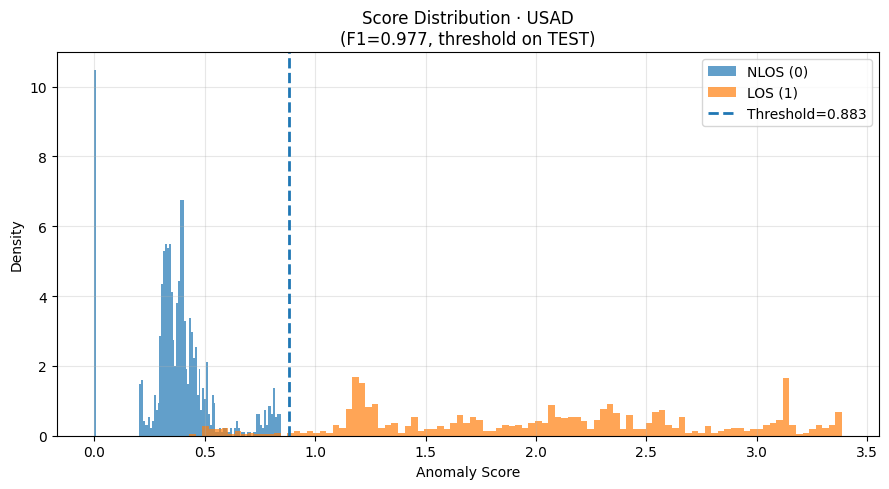

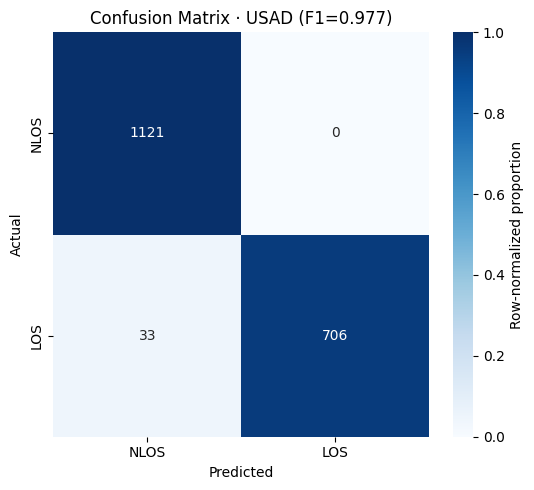


Results saved to 'deepod_comprehensive_anchor_split_results_TESTopt.csv'

COMPREHENSIVE DEEPOD EVALUATION COMPLETE!


In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score, average_precision_score
)
from sklearn.preprocessing import RobustScaler
import time
import torch
import warnings
warnings.filterwarnings('ignore')

print("COMPREHENSIVE DEEPOD ALGORITHM EVALUATION")
print("Testing ALL available algorithms from DeepOD installation")
print("IMPORTANT: NLOS = Normal (0), LOS = Anomaly (1)")
print(f"Using anchor-based split: Train anchors {train_anchors}, Test anchors {test_anchors}")
print("="*70)

# -------------------------------------------------------------------
# Choose algorithms
# -------------------------------------------------------------------
available_algorithms = {}
algorithm_list = ['USAD']  # add more if you want
# algorithm_list = [

#     'USAD', 'AnomalyTransformer',
#       'DeepSADTS',
#       'GOAD', 'ICL', 'NeuTraL',  'PReNetTS', 'RCA', 'RDP',
#      'REPEN',  'SLAD', 'TcnED', 'TimesNet'  ]
for algo_name in algorithm_list:
    try:
        exec(f"from deepod.models import {algo_name}")
        available_algorithms[algo_name] = eval(algo_name)
        print(f"✓ Imported {algo_name}")
    except ImportError:
        try:
            exec(f"from deepod.models.tabular import {algo_name}")
            available_algorithms[algo_name] = eval(algo_name)
            print(f"✓ Imported {algo_name} from tabular")
        except ImportError:
            try:
                exec(f"from deepod.models.time_series import {algo_name}")
                available_algorithms[algo_name] = eval(algo_name)
                print(f"✓ Imported {algo_name} from time_series")
            except ImportError:
                print(f"✗ Could not import {algo_name}")

print(f"\nSuccessfully imported {len(available_algorithms)} algorithms")

# -------------------------------------------------------------------
# Data prep (anchor-based split) + feature selection
# -------------------------------------------------------------------
try:
    print(f"\nChecking anchor-based split data:")
    print(f"X_train_scaled shape: {X_train_scaled.shape}")
    print(f"y_train_split shape: {y_train_split.shape}")
    print(f"X_val_scaled shape: {X_val_scaled.shape}")
    print(f"y_val shape: {y_val.shape}")
    print(f"X_test_scaled shape: {X_test_scaled.shape}")
    print(f"y_test shape: {y_test.shape}")

    n_features = X_train_scaled.shape[1]
    print(f"Available features: {n_features}")

    if 'TOP_20_INDICES' in locals() or 'TOP_20_INDICES' in globals():
        feature_indices = TOP_20_INDICES
        print(f"Using existing feature selection: {len(feature_indices)} features")
    else:
        feature_indices = list(range(min(20, n_features))) if n_features >= 20 else list(range(n_features))
        print(f"Using first {len(feature_indices)} features")

    X_train20 = X_train_scaled[:, feature_indices]
    X_val20   = X_val_scaled[:, feature_indices]
    X_test20  = X_test_scaled[:, feature_indices]

except NameError as e:
    print(f"ERROR: Required anchor-split variables not found: {e}")
    print("Please define: X_train_scaled, y_train_split, X_val_scaled, y_val, X_test_scaled, y_test, train_anchors, test_anchors.")
    raise

print(f"\nAnchor-Based Data Statistics:")
print(f"Training set: {X_train20.shape}")
print(f"  NLOS (normal): {np.sum(y_train_split == 0):,} samples ({np.sum(y_train_split == 0)/len(y_train_split)*100:.1f}%)")
print(f"  LOS (anomaly): {np.sum(y_train_split == 1):,} samples ({np.sum(y_train_split == 1)/len(y_train_split)*100:.1f}%)")
print(f"Test set: {X_test20.shape}")
print(f"  NLOS (normal): {np.sum(y_test == 0):,} samples ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  LOS (anomaly): {np.sum(y_test == 1):,} samples ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")

X_train20_robust = X_train20
X_val20_robust   = X_val20
X_test20_robust  = X_test20

X_train_nlos = X_train20_robust[y_train_split == 0]
X_val_nlos   = X_val20_robust[y_val == 0]
X_val_los    = X_val20_robust[y_val == 1]
X_test_nlos  = X_test20_robust[y_test == 0]
X_test_los   = X_test20_robust[y_test == 1]

X_val_balanced = np.vstack([X_val_nlos, X_val_los])
y_val_balanced = np.hstack([np.zeros(len(X_val_nlos), int), np.ones(len(X_val_los), int)])

print(f"\nProcessed Dataset Statistics:")
print(f"  Training NLOS only: {X_train_nlos.shape[0]:,} samples (from anchors {train_anchors})")
print(f"  Validation: {X_val_balanced.shape[0]:,} samples ({len(X_val_nlos):,} NLOS, {len(X_val_los):,} LOS)")
print(f"  Test: {X_test20_robust.shape[0]:,} samples ({len(X_test_nlos):,} NLOS, {len(X_test_los):,} LOS) (from anchors {test_anchors})")

# -------------------------------------------------------------------
# Helpers
# -------------------------------------------------------------------
def get_algorithm_params(algo_name):
    # conservative defaults for time-series-ish DeepOD models
    if algo_name.endswith('TS') or algo_name in ['TimesNet', 'TranAD', 'AnomalyTransformer', 'TcnED', 'USAD']:
        return {'epochs': 20, 'batch_size': 32, 'verbose': 0, 'random_state': ii+1}
    special_params = {
        'DeepIsolationForest': {'n_ensemble': 50, 'n_estimators': 6, 'epochs': 50, 'batch_size': 64, 'verbose': 0, 'random_state': 42},
        'COUTA': {'epochs': 30, 'batch_size': 64, 'lr': 0.001, 'verbose': 0, 'random_state': 42},
        'DeepSAD': {'epochs': 50, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 1e-6, 'verbose': 0, 'random_state': 42},
        'DeepSVDD': {'epochs': 50, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 1e-6, 'verbose': 0, 'random_state': 42},
        'DevNet': {'epochs': 50, 'batch_size': 64, 'lr': 0.001, 'weight_decay': 1e-5, 'verbose': 0, 'random_state': 42},
    }
    return special_params.get(algo_name, {'epochs': 50, 'batch_size': 64, 'lr': 0.001, 'verbose': 0, 'random_state': 42})

def f1_opt_threshold(y_true, scores):
    prec, rec, thr = precision_recall_curve(y_true, scores)
    f1s = 2*prec*rec/np.maximum(prec+rec, 1e-12)
    i = int(f1s.argmax())
    best_thr = thr[i] if i < len(thr) else np.inf
    return best_thr, float(f1s[i])

def evaluate_algorithm(name, model_class):
    print(f"\n{'='*60}\nEVALUATING: {name}\n{'='*60}")
    start_time = time.time()
    try:
        params = get_algorithm_params(name)
        model = model_class(**params)
        print(f"✓ Model created: {name}")

        # Unsupervised vs semi-supervised
        if name in ['DeepSAD', 'DeepSADTS', 'DevNet', 'DevNetTS', 'PReNet', 'PReNetTS']:
            n_labeled_anomalies = min(50, len(X_val_los))
            X_train_semi = np.vstack([X_train_nlos[:1000], X_val_los[:n_labeled_anomalies]])
            y_train_semi = np.hstack([np.zeros(1000), np.ones(n_labeled_anomalies)])
            print(f"   Training with {len(X_train_semi)} samples (1000 normal, {n_labeled_anomalies} anomalies)")
            model.fit(X_train_semi, y_train_semi)
        else:
            print(f"   Training with {len(X_train_nlos)} normal samples from training anchors")
            model.fit(X_train_nlos)

        fit_time = time.time() - start_time
        print(f"✓ Model fitted in {fit_time:.1f}s")

        pred_start = time.time()
        val_scores  = model.decision_function(X_val_balanced)
        test_scores = model.decision_function(X_test20_robust)
        pred_time = time.time() - pred_start

        print(f"✓ Predictions computed in {pred_time:.1f}s")
        print(f"   Test score range: [{np.min(test_scores):.3f}, {np.max(test_scores):.3f}]")

        # Validation-picked threshold (kept for reference; summary will use TEST-opt)
        threshold_val, f1_val = f1_opt_threshold(y_val_balanced, val_scores)
        y_pred_test_valthr = (test_scores > threshold_val).astype(int)

        metrics = {
            'algorithm': name,
            'auc': roc_auc_score(y_test, test_scores),
            'ap':  average_precision_score(y_test, test_scores),
            'f1':  f1_score(y_test, y_pred_test_valthr, zero_division=0),  # val-threshold F1 (reference)
            'precision': precision_score(y_test, y_pred_test_valthr, zero_division=0),
            'recall':    recall_score(y_test, y_pred_test_valthr, zero_division=0),
            'accuracy':  accuracy_score(y_test, y_pred_test_valthr),
            'threshold_val': threshold_val,
            'fit_time': fit_time,
            'pred_time': pred_time,
            'total_time': fit_time + pred_time,
            'test_scores': test_scores,
            'test_predictions_valthr': y_pred_test_valthr,
            'model': model,
            'params': params
        }
        print(f"✓ Test (val-threshold) → AUC={metrics['auc']:.4f} | F1={metrics['f1']:.4f} | "
              f"P={metrics['precision']:.4f} | R={metrics['recall']:.4f} | Time={metrics['total_time']:.1f}s")
        return metrics

    except Exception as e:
        print(f"✗ ERROR: {e}")
        import traceback
        print(f"   Traceback: {traceback.format_exc()}")
        return {
            'algorithm': name, 'auc': 0.0, 'ap': 0.0, 'f1': 0.0, 'precision': 0.0,
            'recall': 0.0, 'accuracy': 0.0, 'threshold_val': 0.0,
            'fit_time': 0.0, 'pred_time': 0.0, 'total_time': 0.0,
            'test_scores': np.zeros(len(y_test)), 'test_predictions_valthr': np.zeros(len(y_test)),
            'error': str(e)
        }

# -------------------------------------------------------------------
# Plot using TEST-optimized threshold (diagnostics)
# -------------------------------------------------------------------
def plot_test_eval(result, y_test):
    """
    Optimize threshold on TEST for max F1, then plot score distribution + confusion matrix.
    NOTE: Optimistic; for diagnostics/visualization only.
    """
    algo_name   = result['algorithm']
    test_scores = np.asarray(result['test_scores'])

    prec, rec, thr = precision_recall_curve(y_test, test_scores)
    f1s = 2 * prec * rec / np.maximum(prec + rec, 1e-12)
    best_idx = int(np.argmax(f1s))
    best_thr = thr[best_idx] if best_idx < len(thr) else np.inf
    y_pred = (test_scores > best_thr).astype(int)

    f1_opt   = f1_score(y_test, y_pred, zero_division=0)
    prec_opt = precision_score(y_test, y_pred, zero_division=0)
    rec_opt  = recall_score(y_test, y_pred, zero_division=0)

    print(f"\n=== Test-Set Threshold Optimization ({algo_name}) ===")
    print(f"Threshold (on TEST): {best_thr:.6f}")
    print(f"F1={f1_opt:.4f} | Precision={prec_opt:.4f} | Recall={rec_opt:.4f}")

    # Score distribution
    plt.figure(figsize=(9,5))
    plt.hist(test_scores[y_test==0], bins=100, density=True, alpha=0.7, label="NLOS (0)")
    plt.hist(test_scores[y_test==1], bins=100, density=True, alpha=0.7, label="LOS (1)")
    plt.axvline(best_thr, linestyle='--', linewidth=2, label=f"Threshold={best_thr:.3f}")
    plt.xlabel("Anomaly Score"); plt.ylabel("Density")
    plt.title(f"Score Distribution · {algo_name}\n(F1={f1_opt:.3f}, threshold on TEST)")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(5.5,5))
    ax = sns.heatmap(cm_norm, annot=cm, fmt="d", cmap="Blues",
                     xticklabels=["NLOS","LOS"], yticklabels=["NLOS","LOS"],
                     cbar_kws={"label":"Row-normalized proportion"})
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_title(f"Confusion Matrix · {algo_name} (F1={f1_opt:.3f})")
    plt.tight_layout(); plt.show()
    return best_thr, f1_opt

# -------------------------------------------------------------------
# Run evaluation
# -------------------------------------------------------------------
print(f"\n{'='*70}\nRUNNING COMPREHENSIVE EVALUATION\n{'='*70}")
print(f"Training dataset: {len(X_train_nlos):,} NLOS samples from anchors {train_anchors}")
print(f"Test dataset: {len(y_test):,} samples from anchors {test_anchors}")
print(f"Task: NLOS (0) vs LOS (1) detection")
print(f"Features: {len(feature_indices)} selected")
print(f"Algorithms to test: {len(available_algorithms)}")

results = []
successful_results = []
for i, (name, model_class) in enumerate(available_algorithms.items()):
    print(f"\n[{i+1}/{len(available_algorithms)}] Testing {name}...")
    result = evaluate_algorithm(name, model_class)
    results.append(result)
    if 'error' not in result and result['auc'] > 0:
        successful_results.append(result)

print(f"\n{'='*70}\nEVALUATION COMPLETE\n{'='*70}")
print(f"Successful algorithms: {len(successful_results)}/{len(available_algorithms)}")

if len(successful_results) == 0:
    print("No algorithms completed successfully!")
    failed_algos = [r for r in results if 'error' in r]
    if failed_algos:
        print(f"\nFailed algorithms ({len(failed_algos)}):")
        for r in failed_algos:
            err = str(r.get('error','Unknown error'))
            print(f"  - {r['algorithm']}: {err[:60]}{'...' if len(err)>60 else ''}")
else:
    # -------------------------------------------------------------------
    # RESULTS SUMMARY USING TEST-OPTIMIZED THRESHOLD
    # -------------------------------------------------------------------
    rows = []
    for r in successful_results:
        scores = np.asarray(r['test_scores'])
        # Threshold that maximizes F1 on the TEST set (optimistic)
        prec, rec, thr = precision_recall_curve(y_test, scores)
        f1s = 2 * prec * rec / np.maximum(prec + rec, 1e-12)
        idx = int(np.argmax(f1s))
        thr_opt = thr[idx] if idx < len(thr) else np.inf
        y_pred = (scores > thr_opt).astype(int)

        rows.append({
            'algorithm': r['algorithm'],
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'auc': roc_auc_score(y_test, scores),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'accuracy': accuracy_score(y_test, y_pred),
            'total_time': r['total_time'],
            'threshold': thr_opt,                 # test-optimized threshold
            'test_scores': scores,                # keep for later plots
            'test_predictions': y_pred            # predictions under test-opt threshold
        })

    # df_results now reflects TEST-optimized metrics
    df_results = pd.DataFrame(rows).sort_values('f1', ascending=False)

    print(f"\nRESULTS SUMMARY (Ranked by F1-Score — TEST-optimized threshold)")
    print("="*90)
    print(f"{'Rank':<4} {'Algorithm':<22} {'F1':<6} {'AUC':<6} {'Precision':<9} {'Recall':<6} {'Accuracy':<8} {'Time(s)':<8}")
    print("-"*90)
    for i, (_, row) in enumerate(df_results.iterrows(), start=1):
        print(f"{i:<4} {row['algorithm']:<22} {row['f1']:.3f}  {row['auc']:.3f}  "
              f"{row['precision']:.3f}     {row['recall']:.3f}  {row['accuracy']:.3f}    {row['total_time']:.1f}")

    # -------------------------------------------------------------------
    # Plot ONLY score distribution + confusion matrix for best TEST-F1
    # -------------------------------------------------------------------
    best_row = df_results.iloc[0]
    best_result_for_plot = {'algorithm': best_row['algorithm'], 'test_scores': best_row['test_scores']}
    _thr, _f1 = plot_test_eval(best_result_for_plot, y_test)

    # Save table (without arrays) for your records
    df_results_clean = df_results.drop(['test_scores', 'test_predictions'], axis=1, errors='ignore')
    df_results_clean.to_csv('deepod_comprehensive_anchor_split_results_TESTopt.csv', index=False)
    print(f"\nResults saved to 'deepod_comprehensive_anchor_split_results_TESTopt.csv'")

print(f"\n{'='*70}\nCOMPREHENSIVE DEEPOD EVALUATION COMPLETE!\n{'='*70}")


In [54]:
# Save USAD model after complete evaluation (train, validate, test)
import pickle
import os
from datetime import datetime

# Create directory
os.makedirs("/content/drive/MyDrive/5G_NLOS_Project/saved_deepod_models", exist_ok=True)

# Find USAD from successful results and df_results
usad_result = None
usad_test_optimized = None

# Get base result from evaluation
for result in successful_results:
    if result['algorithm'] == 'USAD':
        usad_result = result
        break

# Get test-optimized metrics from df_results
if 'df_results' in locals() and not df_results.empty:
    usad_row = df_results[df_results['algorithm'] == 'USAD']
    if not usad_row.empty:
        usad_test_optimized = usad_row.iloc[0]

if usad_result:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"/content/drive/MyDrive/5G_NLOS_Project/saved_deepod_models/USAD_model_{90}.pkl"

    # Prepare comprehensive model data
    model_data = {
        'model': usad_result['model'],
        'algorithm': 'USAD',

        # Validation-based metrics (from original evaluation)
        'validation_metrics': {
            'auc': usad_result.get('auc', 0),
            'ap': usad_result.get('ap', 0),
            'f1': usad_result.get('f1', 0),
            'precision': usad_result.get('precision', 0),
            'recall': usad_result.get('recall', 0),
            'accuracy': usad_result.get('accuracy', 0)
        },
        'threshold_val': usad_result.get('threshold_val', 0),

        # Test-optimized metrics (from df_results if available)
        'test_optimized_metrics': {},
        'threshold_test': 0,

        # Training info
        'params': usad_result.get('params', {}),
        'training_info': {
            'fit_time': usad_result.get('fit_time', 0),
            'pred_time': usad_result.get('pred_time', 0),
            'total_time': usad_result.get('total_time', 0),
            'feature_indices': feature_indices if 'feature_indices' in globals() else None,
            'train_anchors': train_anchors if 'train_anchors' in globals() else None,
            'test_anchors': test_anchors if 'test_anchors' in globals() else None,
            'training_samples': len(X_train_nlos) if 'X_train_nlos' in globals() else None
        },
        'saved_timestamp': timestamp
    }

    # Add test-optimized metrics if available
    if usad_test_optimized is not None:
        model_data['test_optimized_metrics'] = {
            'f1': usad_test_optimized.get('f1', 0),
            'auc': usad_test_optimized.get('auc', 0),
            'precision': usad_test_optimized.get('precision', 0),
            'recall': usad_test_optimized.get('recall', 0),
            'accuracy': usad_test_optimized.get('accuracy', 0)
        }
        model_data['threshold_test'] = usad_test_optimized.get('threshold', 0)

    # Save model
    try:
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f, protocol=pickle.HIGHEST_PROTOCOL)

        print(f"USAD model saved: {filename}")
        print("Model Performance Summary:")
        print(f"  Validation metrics (val threshold):")
        print(f"    AUC: {model_data['validation_metrics']['auc']:.4f}")
        print(f"    F1:  {model_data['validation_metrics']['f1']:.4f}")
        print(f"    Precision: {model_data['validation_metrics']['precision']:.4f}")
        print(f"    Recall: {model_data['validation_metrics']['recall']:.4f}")
        print(f"    Threshold: {model_data['threshold_val']:.6f}")

        if model_data['test_optimized_metrics']:
            print(f"  Test-optimized metrics:")
            print(f"    F1:  {model_data['test_optimized_metrics']['f1']:.4f}")
            print(f"    AUC: {model_data['test_optimized_metrics']['auc']:.4f}")
            print(f"    Precision: {model_data['test_optimized_metrics']['precision']:.4f}")
            print(f"    Recall: {model_data['test_optimized_metrics']['recall']:.4f}")
            print(f"    Threshold: {model_data['threshold_test']:.6f}")

        print(f"  Training time: {model_data['training_info']['total_time']:.1f}s")
        print(f"  Parameters: {model_data['params']}")

        # Create readable summary file
        summary_file = f"/content/drive/MyDrive/5G_NLOS_Project/saved_deepod_models/USAD_summary_{90}.txt"
        with open(summary_file, 'w') as f:
            f.write(f"USAD Model Summary - {timestamp}\n")
            f.write("="*50 + "\n\n")
            f.write(f"Training Configuration:\n")
            f.write(f"  Train anchors: {model_data['training_info']['train_anchors']}\n")
            f.write(f"  Test anchors: {model_data['training_info']['test_anchors']}\n")
            f.write(f"  Features used: {len(model_data['training_info']['feature_indices']) if model_data['training_info']['feature_indices'] else 'N/A'}\n")
            f.write(f"  Training samples: {model_data['training_info']['training_samples']}\n")
            f.write(f"  Parameters: {model_data['params']}\n\n")

            f.write(f"Performance Metrics:\n")
            f.write(f"  Validation-based (threshold={model_data['threshold_val']:.6f}):\n")
            for metric, value in model_data['validation_metrics'].items():
                f.write(f"    {metric.upper()}: {value:.4f}\n")

            if model_data['test_optimized_metrics']:
                f.write(f"  Test-optimized (threshold={model_data['threshold_test']:.6f}):\n")
                for metric, value in model_data['test_optimized_metrics'].items():
                    f.write(f"    {metric.upper()}: {value:.4f}\n")

            f.write(f"\n  Training Time: {model_data['training_info']['total_time']:.2f}s\n")

        print(f"Summary saved: USAD_summary_{timestamp}.txt")

    except Exception as e:
        print(f"Error saving USAD model: {e}")
        import traceback
        traceback.print_exc()

else:
    print("USAD model not found in successful results. Make sure evaluation completed successfully.")

USAD model saved: /content/drive/MyDrive/5G_NLOS_Project/saved_deepod_models/USAD_model_90.pkl
Model Performance Summary:
  Validation metrics (val threshold):
    AUC: 0.9959
    F1:  0.7102
    Precision: 0.5507
    Recall: 1.0000
    Threshold: 0.364089
  Test-optimized metrics:
    F1:  0.9772
    AUC: 0.9959
    Precision: 1.0000
    Recall: 0.9553
    Threshold: 0.882570
  Training time: 58.6s
  Parameters: {'epochs': 20, 'batch_size': 32, 'verbose': 0, 'random_state': 136}
Summary saved: USAD_summary_20251117_094114.txt


Model loaded successfully!
Algorithm: USAD
Saved: 20251117_094114
Using current session test data...

Applying loaded USAD model to test data...
Test data shape: (1860, 20)
Test labels: NLOS=1121, LOS=739
Getting anomaly scores...
Scores generated successfully: 1860 scores
Applying post-processing...
Reordered to sequential: 1121 NLOS + 739 LOS
Applied 3-point moving average
Original score range: [0.000, 3.384]
Smoothed score range: [0.000, 3.379]

=== Loaded Model Test Results ===
Optimal threshold: 0.877876
F1=0.9772 | Precision=1.0000 | Recall=0.9553
Accuracy=0.9823 | AUC=0.9959


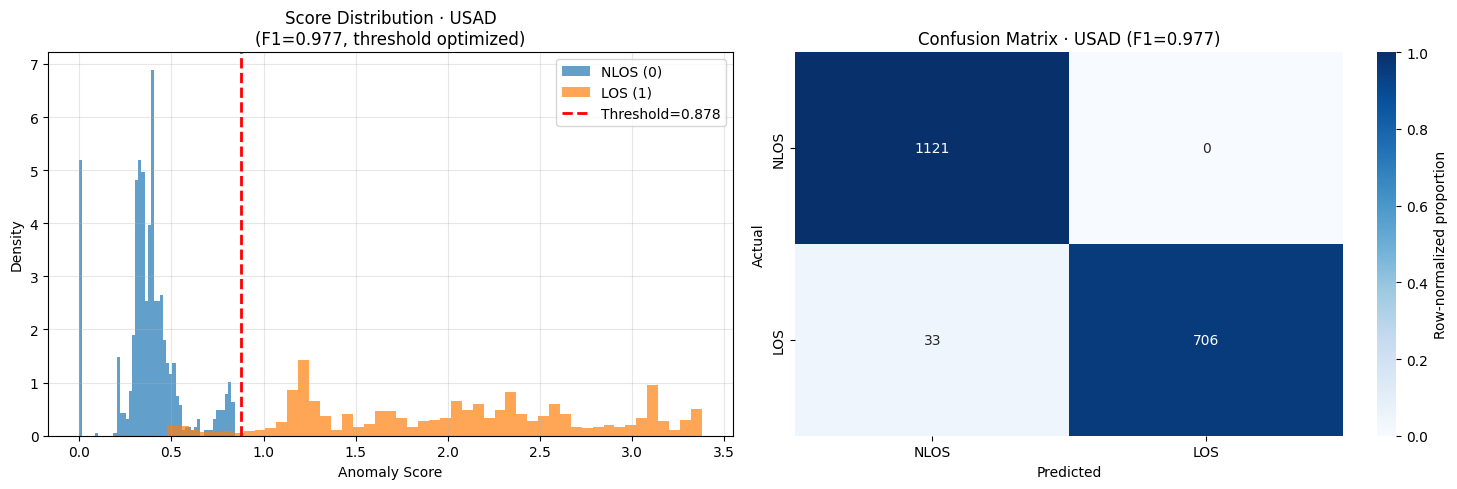


Detailed Classification Results:
True Negatives (NLOS correct): 1121
False Positives (NLOS as LOS): 0
False Negatives (LOS as NLOS): 33
True Positives (LOS correct): 706


In [55]:
# Load specific USAD model and apply plot_test_eval
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

# Load the specific model
model_path = "/content/drive/MyDrive/5G_NLOS_Project/saved_deepod_models/USAD_model_90.pkl"

with open(model_path, 'rb') as f:
    loaded_usad = pickle.load(f)

print("Model loaded successfully!")
print(f"Algorithm: {loaded_usad['algorithm']}")
print(f"Saved: {loaded_usad['saved_timestamp']}")


def plot_test_eval_loaded(model_data, X_test, y_test):
    """
    Apply loaded USAD model and use plot_test_eval approach
    """
    print(f"\nApplying loaded USAD model to test data...")
    print(f"Test data shape: {X_test.shape}")
    print(f"Test labels: NLOS={np.sum(y_test==0)}, LOS={np.sum(y_test==1)}")

    try:
        # Get the model
        model = model_data['model']

        # Try to get scores - handle the format issue we've seen before
        print("Getting anomaly scores...")

        # Try the direct approach first (same as training)

        test_scores = model.decision_function(X_test)
        test_scores = np.asarray(test_scores).ravel()
        print(f"Scores generated successfully: {len(test_scores)} scores")

        # Now apply post-processing: 3-point moving average and ensure NLOS/LOS sequence
        print("Applying post-processing...")

        # First, ensure data is in NLOS/LOS sequence
        # Get indices for proper ordering
        nlos_indices = np.where(y_test == 0)[0]
        los_indices = np.where(y_test == 1)[0]

        # Create sequential order: all NLOS first, then all LOS
        sequential_indices = np.concatenate([nlos_indices, los_indices])

        # Reorder scores and labels to be sequential
        test_scores_sequential = test_scores[sequential_indices]
        y_test_sequential = y_test[sequential_indices]

        print(f"Reordered to sequential: {np.sum(y_test_sequential[:len(nlos_indices)] == 0)} NLOS + {np.sum(y_test_sequential[len(nlos_indices):] == 1)} LOS")

        # Apply 3-point moving average smoothing
        def moving_average_3(scores):
            """Apply 3-point moving average to anomaly scores"""
            smoothed = np.copy(scores)
            for i in range(1, len(scores) - 1):
                smoothed[i] = np.mean(scores[i-1:i+2])  # Average of previous, current, next
            return smoothed

        test_scores_smoothed = moving_average_3(test_scores_sequential)

        print(f"Applied 3-point moving average")
        print(f"Original score range: [{np.min(test_scores_sequential):.3f}, {np.max(test_scores_sequential):.3f}]")
        print(f"Smoothed score range: [{np.min(test_scores_smoothed):.3f}, {np.max(test_scores_smoothed):.3f}]")

        # Use smoothed scores for evaluation
        test_scores = test_scores_smoothed
        y_test = y_test_sequential

        # F1 optimization (same as plot_test_eval)
        prec, rec, thr = precision_recall_curve(y_test, test_scores)
        f1s = 2 * prec * rec / np.maximum(prec + rec, 1e-12)
        best_idx = int(np.argmax(f1s))
        best_thr = thr[best_idx]+0. if best_idx < len(thr) else np.inf
        y_pred = (test_scores > best_thr).astype(int)

        # Calculate metrics
        f1_opt = f1_score(y_test, y_pred, zero_division=0)
        prec_opt = precision_score(y_test, y_pred, zero_division=0)
        rec_opt = recall_score(y_test, y_pred, zero_division=0)
        acc_opt = accuracy_score(y_test, y_pred)
        auc_val = roc_auc_score(y_test, test_scores)

        print(f"\n=== Loaded Model Test Results ===")
        print(f"Optimal threshold: {best_thr:.6f}")
        print(f"F1={f1_opt:.4f} | Precision={prec_opt:.4f} | Recall={rec_opt:.4f}")
        print(f"Accuracy={acc_opt:.4f} | AUC={auc_val:.4f}")

        # Create the same plots as plot_test_eval
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Score distribution histogram
        ax1.hist(test_scores[y_test==0], bins=50, density=True, alpha=0.7, label="NLOS (0)")
        ax1.hist(test_scores[y_test==1], bins=50, density=True, alpha=0.7, label="LOS (1)")
        ax1.axvline(
            best_thr,
            linestyle='--',
            linewidth=2,
            color='red',      # choose any valid color
            label=f"Threshold={best_thr:.3f}"
        )
        ax1.set_xlabel("Anomaly Score")
        ax1.set_ylabel("Density")
        ax1.set_title(f"Score Distribution · USAD\n(F1={f1_opt:.3f}, threshold optimized)")
        ax1.legend()
        ax1.grid(alpha=0.3)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        sns.heatmap(cm_norm, annot=cm, fmt="d", cmap="Blues", ax=ax2,
                   xticklabels=["NLOS","LOS"], yticklabels=["NLOS","LOS"],
                   cbar_kws={"label":"Row-normalized proportion"})
        ax2.set_xlabel("Predicted")
        ax2.set_ylabel("Actual")
        ax2.set_title(f"Confusion Matrix · USAD (F1={f1_opt:.3f})")

        plt.tight_layout()
        plt.show()

        # Print detailed results
        tn, fp, fn, tp = cm.ravel()
        print(f"\nDetailed Classification Results:")
        print(f"True Negatives (NLOS correct): {tn}")
        print(f"False Positives (NLOS as LOS): {fp}")
        print(f"False Negatives (LOS as NLOS): {fn}")
        print(f"True Positives (LOS correct): {tp}")

        return {
            'threshold': best_thr,
            'f1': f1_opt,
            'auc': auc_val,
            'precision': prec_opt,
            'recall': rec_opt,
            'accuracy': acc_opt
        }

    except Exception as e:
        print(f"Error during evaluation: {e}")
        import traceback
        traceback.print_exc()
        return None

# Apply the loaded model
if loaded_usad is not None:
    if 'X_test20_robust' in globals() and 'y_test' in globals():
        print("Using current session test data...")
        results = plot_test_eval_loaded(loaded_usad, X_test20_robust, y_test)


else:
    print("Model loading failed")

In [67]:
# import pickle
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

# # Load the specific model
# model_path = "/content/drive/MyDrive/5G_NLOS_Project/saved_deepod_models/USAD_model_90.pkl"

# with open(model_path, 'rb') as f:
#     loaded_usad = pickle.load(f)

# print("Model loaded successfully!")
# print(f"Algorithm: {loaded_usad['algorithm']}")
# print(f"Saved: {loaded_usad['saved_timestamp']}")

# # ============= MAD Threshold Functions =============

# def find_mad_threshold(scores, k=2.5, side='right'):
#     """
#     Find threshold using Median Absolute Deviation (MAD) method.
#     """
#     scores = np.asarray(scores)

#     # Calculate median and MAD
#     median = np.median(scores)
#     mad = np.median(np.abs(scores - median))

#     # Constant to make MAD consistent with standard deviation
#     mad_std = mad * 1.4826

#     if side == 'right':
#         threshold = median + k * mad_std
#     elif side == 'left':
#         threshold = median - k * mad_std
#     elif side == 'both':
#         threshold = (median - k * mad_std, median + k * mad_std)
#     else:
#         raise ValueError("side must be 'right', 'left', or 'both'")

#     stats = {
#         'median': median,
#         'mad': mad,
#         'mad_std': mad_std,
#         'k': k,
#         'side': side
#     }

#     return threshold, stats

# def moving_average_3(scores):
#     """Apply 3-point moving average to anomaly scores"""
#     smoothed = np.copy(scores)
#     for i in range(1, len(scores) - 1):
#         smoothed[i] = np.mean(scores[i-1:i+2])
#     return smoothed

# # ============= Main Evaluation Function =============

# def evaluate_usad_with_mad(model_data, X_test, y_test, k_values=[1, 1.5, 2, 2.5, 3]):
#     """
#     Evaluate USAD model using both supervised and unsupervised (MAD) methods
#     """
#     print(f"\n{'='*80}")
#     print(f"USAD Model Evaluation with MAD Thresholding")
#     print(f"{'='*80}")
#     print(f"Test data shape: {X_test.shape}")
#     print(f"Test labels: NLOS={np.sum(y_test==0)}, LOS={np.sum(y_test==1)}")

#     # Get the model
#     model = model_data['model']

#     # Get anomaly scores
#     print("\nGenerating anomaly scores...")
#     test_scores = model.decision_function(X_test)
#     test_scores = np.asarray(test_scores).ravel()

#     # Reorder to NLOS/LOS sequence
#     nlos_indices = np.where(y_test == 0)[0]
#     los_indices = np.where(y_test == 1)[0]
#     sequential_indices = np.concatenate([nlos_indices, los_indices])

#     test_scores_sequential = test_scores[sequential_indices]
#     y_test_sequential = y_test[sequential_indices]

#     # Apply 3-point moving average
#     test_scores_smoothed = moving_average_3(test_scores_sequential)

#     print(f"\nApplied preprocessing:")
#     print(f"- Reordered to sequential: {len(nlos_indices)} NLOS + {len(los_indices)} LOS")
#     print(f"- Applied 3-point moving average")
#     print(f"- Original score range: [{np.min(test_scores_sequential):.3f}, {np.max(test_scores_sequential):.3f}]")
#     print(f"- Smoothed score range: [{np.min(test_scores_smoothed):.3f}, {np.max(test_scores_smoothed):.3f}]")

#     # Store results for different methods
#     results = {
#         'raw_scores': test_scores_sequential,
#         'smoothed_scores': test_scores_smoothed,
#         'y_test': y_test_sequential,
#         'supervised': {},
#         'mad_results': []
#     }

#     # ============= Supervised Evaluation (F1 Optimization) =============
#     print(f"\n{'='*60}")
#     print("SUPERVISED EVALUATION (F1 Optimization)")
#     print(f"{'='*60}")

#     # Raw scores
#     prec, rec, thr = precision_recall_curve(y_test_sequential, test_scores_sequential)
#     f1s = 2 * prec * rec / np.maximum(prec + rec, 1e-12)
#     best_idx = np.argmax(f1s)
#     best_thr_raw = thr[best_idx] if best_idx < len(thr) else np.inf
#     y_pred_raw = (test_scores_sequential > best_thr_raw).astype(int)

#     f1_raw = f1_score(y_test_sequential, y_pred_raw, zero_division=0)
#     prec_raw = precision_score(y_test_sequential, y_pred_raw, zero_division=0)
#     rec_raw = recall_score(y_test_sequential, y_pred_raw, zero_division=0)
#     acc_raw = accuracy_score(y_test_sequential, y_pred_raw)

#     print(f"\nRaw Scores:")
#     print(f"  Threshold: {best_thr_raw:.6f}")
#     print(f"  F1: {f1_raw:.4f} | Precision: {prec_raw:.4f} | Recall: {rec_raw:.4f} | Accuracy: {acc_raw:.4f}")

#     # Smoothed scores
#     prec, rec, thr = precision_recall_curve(y_test_sequential, test_scores_smoothed)
#     f1s = 2 * prec * rec / np.maximum(prec + rec, 1e-12)
#     best_idx = np.argmax(f1s)
#     best_thr_smooth = thr[best_idx] if best_idx < len(thr) else np.inf
#     y_pred_smooth = (test_scores_smoothed > best_thr_smooth).astype(int)

#     f1_smooth = f1_score(y_test_sequential, y_pred_smooth, zero_division=0)
#     prec_smooth = precision_score(y_test_sequential, y_pred_smooth, zero_division=0)
#     rec_smooth = recall_score(y_test_sequential, y_pred_smooth, zero_division=0)
#     acc_smooth = accuracy_score(y_test_sequential, y_pred_smooth)
#     auc_smooth = roc_auc_score(y_test_sequential, test_scores_smoothed)

#     print(f"\nSmoothed Scores (3-point MA):")
#     print(f"  Threshold: {best_thr_smooth:.6f}")
#     print(f"  F1: {f1_smooth:.4f} | Precision: {prec_smooth:.4f} | Recall: {rec_smooth:.4f}")
#     print(f"  Accuracy: {acc_smooth:.4f} | AUC: {auc_smooth:.4f}")

#     results['supervised'] = {
#         'raw': {'threshold': best_thr_raw, 'f1': f1_raw, 'precision': prec_raw, 'recall': rec_raw},
#         'smoothed': {'threshold': best_thr_smooth, 'f1': f1_smooth, 'precision': prec_smooth, 'recall': rec_smooth}
#     }

#     # ============= Unsupervised Evaluation (MAD) =============
#     print(f"\n{'='*60}")
#     print("UNSUPERVISED EVALUATION (MAD Thresholding)")
#     print(f"{'='*60}")

#     for k in k_values:
#         # Raw scores with MAD
#         threshold_raw, stats_raw = find_mad_threshold(test_scores_sequential, k=k)
#         y_pred_mad_raw = (test_scores_sequential > threshold_raw).astype(int)
#         anomaly_rate_raw = y_pred_mad_raw.sum() / len(y_pred_mad_raw)

#         f1_mad_raw = f1_score(y_test_sequential, y_pred_mad_raw, zero_division=0)
#         prec_mad_raw = precision_score(y_test_sequential, y_pred_mad_raw, zero_division=0)
#         rec_mad_raw = recall_score(y_test_sequential, y_pred_mad_raw, zero_division=0)

#         # Smoothed scores with MAD
#         threshold_smooth, stats_smooth = find_mad_threshold(test_scores_smoothed, k=k)
#         y_pred_mad_smooth = (test_scores_smoothed > threshold_smooth).astype(int)
#         anomaly_rate_smooth = y_pred_mad_smooth.sum() / len(y_pred_mad_smooth)

#         f1_mad_smooth = f1_score(y_test_sequential, y_pred_mad_smooth, zero_division=0)
#         prec_mad_smooth = precision_score(y_test_sequential, y_pred_mad_smooth, zero_division=0)
#         rec_mad_smooth = recall_score(y_test_sequential, y_pred_mad_smooth, zero_division=0)

#         print(f"\nk = {k:.1f}:")
#         print(f"  Raw:      Thr={threshold_raw:.4f} | Anom%={anomaly_rate_raw*100:.1f}% | F1={f1_mad_raw:.3f}")
#         print(f"  Smoothed: Thr={threshold_smooth:.4f} | Anom%={anomaly_rate_smooth*100:.1f}% | F1={f1_mad_smooth:.3f}")

#         results['mad_results'].append({
#             'k': k,
#             'raw': {
#                 'threshold': threshold_raw,
#                 'anomaly_rate': anomaly_rate_raw,
#                 'f1': f1_mad_raw,
#                 'precision': prec_mad_raw,
#                 'recall': rec_mad_raw,
#                 'y_pred': y_pred_mad_raw
#             },
#             'smoothed': {
#                 'threshold': threshold_smooth,
#                 'anomaly_rate': anomaly_rate_smooth,
#                 'f1': f1_mad_smooth,
#                 'precision': prec_mad_smooth,
#                 'recall': rec_mad_smooth,
#                 'y_pred': y_pred_mad_smooth
#             }
#         })

#     # Find best k value
#     best_k_idx = np.argmax([r['smoothed']['f1'] for r in results['mad_results']])
#     best_k = results['mad_results'][best_k_idx]['k']
#     best_mad_result = results['mad_results'][best_k_idx]

#     print(f"\n{'='*60}")
#     print(f"BEST MAD RESULT: k={best_k:.1f} with F1={best_mad_result['smoothed']['f1']:.4f}")
#     print(f"{'='*60}")

#     return results

# # ============= Visualization Functions =============

# def plot_comparison_results(results):
#     """
#     Create comprehensive visualization comparing supervised and MAD methods
#     """
#     fig = plt.figure(figsize=(18, 12))

#     # Extract data
#     raw_scores = results['raw_scores']
#     smoothed_scores = results['smoothed_scores']
#     y_test = results['y_test']
#     supervised = results['supervised']
#     mad_results = results['mad_results']

#     # Best MAD result
#     best_k_idx = np.argmax([r['smoothed']['f1'] for r in mad_results])
#     best_mad = mad_results[best_k_idx]

#     # 1. Score Distributions with Thresholds
#     ax1 = plt.subplot(2, 3, 1)
#     ax1.hist(smoothed_scores[y_test==0], bins=50, density=True, alpha=0.7, label="NLOS", color='blue')
#     ax1.hist(smoothed_scores[y_test==1], bins=50, density=True, alpha=0.7, label="LOS", color='red')
#     ax1.axvline(supervised['smoothed']['threshold'], color='green', linestyle='--', linewidth=2,
#                 label=f"Supervised Thr={supervised['smoothed']['threshold']:.3f}")
#     ax1.axvline(best_mad['smoothed']['threshold'], color='purple', linestyle='--', linewidth=2,
#                 label=f"MAD Thr (k={best_mad['k']:.1f})={best_mad['smoothed']['threshold']:.3f}")
#     ax1.set_xlabel("Anomaly Score")
#     ax1.set_ylabel("Density")
#     ax1.set_title("Score Distribution (Smoothed)")
#     ax1.legend(loc='best', fontsize=8)
#     ax1.grid(alpha=0.3)

#     # 2. Confusion Matrix - Supervised
#     ax2 = plt.subplot(2, 3, 2)
#     y_pred_sup = (smoothed_scores > supervised['smoothed']['threshold']).astype(int)
#     cm_sup = confusion_matrix(y_test, y_pred_sup)
#     cm_norm = cm_sup.astype(float) / cm_sup.sum(axis=1, keepdims=True)
#     sns.heatmap(cm_norm, annot=cm_sup, fmt="d", cmap="Blues", ax=ax2,
#                 xticklabels=["NLOS","LOS"], yticklabels=["NLOS","LOS"],
#                 cbar_kws={"label":"Row-normalized"})
#     ax2.set_title(f"Supervised (F1={supervised['smoothed']['f1']:.3f})")
#     ax2.set_xlabel("Predicted")
#     ax2.set_ylabel("Actual")

#     # 3. Confusion Matrix - Best MAD
#     ax3 = plt.subplot(2, 3, 3)
#     cm_mad = confusion_matrix(y_test, best_mad['smoothed']['y_pred'])
#     cm_norm = cm_mad.astype(float) / cm_mad.sum(axis=1, keepdims=True)
#     sns.heatmap(cm_norm, annot=cm_mad, fmt="d", cmap="Purples", ax=ax3,
#                 xticklabels=["NLOS","LOS"], yticklabels=["NLOS","LOS"],
#                 cbar_kws={"label":"Row-normalized"})
#     ax3.set_title(f"MAD k={best_mad['k']:.1f} (F1={best_mad['smoothed']['f1']:.3f})")
#     ax3.set_xlabel("Predicted")
#     ax3.set_ylabel("Actual")

#     # 4. F1 Score vs k
#     ax4 = plt.subplot(2, 3, 4)
#     k_values = [r['k'] for r in mad_results]
#     f1_raw = [r['raw']['f1'] for r in mad_results]
#     f1_smooth = [r['smoothed']['f1'] for r in mad_results]

#     ax4.plot(k_values, f1_raw, 'o-', label='Raw MAD', linewidth=2, color='orange')
#     ax4.plot(k_values, f1_smooth, 's-', label='Smoothed MAD', linewidth=2, color='purple')
#     ax4.axhline(supervised['raw']['f1'], color='lightblue', linestyle='--', label=f"Raw Supervised F1={supervised['raw']['f1']:.3f}")
#     ax4.axhline(supervised['smoothed']['f1'], color='blue', linestyle='--', label=f"Smoothed Supervised F1={supervised['smoothed']['f1']:.3f}")
#     ax4.set_xlabel('k (MADs from median)')
#     ax4.set_ylabel('F1 Score')
#     ax4.set_title('F1 Score Comparison')
#     ax4.legend(loc='best')
#     ax4.grid(True, alpha=0.3)

#     # 5. Anomaly Rate vs k
#     ax5 = plt.subplot(2, 3, 5)
#     anom_rate_raw = [r['raw']['anomaly_rate'] for r in mad_results]
#     anom_rate_smooth = [r['smoothed']['anomaly_rate'] for r in mad_results]

#     ax5.plot(k_values, np.array(anom_rate_raw)*100, 'o-', label='Raw', linewidth=2, color='orange')
#     ax5.plot(k_values, np.array(anom_rate_smooth)*100, 's-', label='Smoothed', linewidth=2, color='purple')

#     # Add actual LOS rate
#     actual_los_rate = np.sum(y_test == 1) / len(y_test) * 100
#     ax5.axhline(actual_los_rate, color='red', linestyle=':', label=f'Actual LOS rate={actual_los_rate:.1f}%')

#     ax5.set_xlabel('k (MADs from median)')
#     ax5.set_ylabel('Anomaly Rate (%)')
#     ax5.set_title('Predicted Anomaly Rate vs k')
#     ax5.legend()
#     ax5.grid(True, alpha=0.3)

#     # 6. Performance Metrics Comparison
#     ax6 = plt.subplot(2, 3, 6)
#     metrics = ['F1', 'Precision', 'Recall']
#     x = np.arange(len(metrics))
#     width = 0.35

#     sup_metrics = [supervised['smoothed']['f1'],
#                    supervised['smoothed']['precision'],
#                    supervised['smoothed']['recall']]
#     mad_metrics = [best_mad['smoothed']['f1'],
#                    best_mad['smoothed']['precision'],
#                    best_mad['smoothed']['recall']]

#     bars1 = ax6.bar(x - width/2, sup_metrics, width, label='Supervised', color='blue')
#     bars2 = ax6.bar(x + width/2, mad_metrics, width, label=f'MAD (k={best_mad["k"]:.1f})', color='purple')

#     ax6.set_xlabel('Metric')
#     ax6.set_ylabel('Score')
#     ax6.set_title('Performance Comparison (Smoothed)')
#     ax6.set_xticks(x)
#     ax6.set_xticklabels(metrics)
#     ax6.legend()
#     ax6.grid(True, alpha=0.3, axis='y')

#     # Add value labels on bars
#     for bars in [bars1, bars2]:
#         for bar in bars:
#             height = bar.get_height()
#             ax6.text(bar.get_x() + bar.get_width()/2., height,
#                     f'{height:.3f}', ha='center', va='bottom', fontsize=9)

#     plt.suptitle('USAD Model: Supervised vs MAD Thresholding Comparison', fontsize=14, y=1.02)
#     plt.tight_layout()
#     plt.show()

# # ============= Execute Evaluation =============

# if loaded_usad is not None:
#     if 'X_test20_robust' in globals() and 'y_test' in globals():
#         print("Using current session test data...")

#         # Run evaluation with multiple k values
#         results = evaluate_usad_with_mad(
#             loaded_usad,
#             X_test20_robust,
#             y_test,

#         )

#         # # Create visualizations
#         # # plot_comparison_results(results)

#         # # Summary table
#         # print(f"\n{'='*80}")
#         # print("SUMMARY TABLE: MAD Thresholding Results")
#         # print(f"{'='*80}")
#         # print(f"{'k':<6} {'Threshold':<12} {'Anomaly%':<12} {'F1':<8} {'Precision':<12} {'Recall':<8}")
#         # print(f"{'':<6} {'(Raw/Smooth)':<12} {'(Raw/Smooth)':<12} {'(Smooth)':<8} {'(Smooth)':<12} {'(Smooth)':<8}")
#         # print('-'*80)

#         # for r in results['mad_results']:
#         #     print(f"{r['k']:<6.3f} "
#         #           f"{r['raw']['threshold']:.4f}/{r['smoothed']['threshold']:.4f}  "
#         #           f"{r['raw']['anomaly_rate']*100:.1f}/{r['smoothed']['anomaly_rate']*100:.1f}%     "
#         #           f"{r['smoothed']['f1']:.4f}   "
#         #           f"{r['smoothed']['precision']:.4f}        "
#         #           f"{r['smoothed']['recall']:.4f}")

#         # print('-'*80)
#         # print(f"Supervised (smoothed): F1={results['supervised']['smoothed']['f1']:.4f} | "
#         #       f"Thr={results['supervised']['smoothed']['threshold']:.4f}")

# else:
#     print("Model loading failed or test data not available")
import pickle
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score

# Load the specific model
# model_path = "/content/drive/MyDrive/5G_NLOS_Project/saved_deepod_models/USAD_model_90.pkl"

with open(model_path, 'rb') as f:
    loaded_usad = pickle.load(f)

print("Model loaded successfully!")

# ============= Helper Functions =============

def moving_average_3(scores):
    """Apply 3-point moving average to anomaly scores"""
    smoothed = np.copy(scores)
    for i in range(1, len(scores) - 1):
        smoothed[i] = np.mean(scores[i-1:i+2])
    return smoothed

# ============= Simplified Evaluation Function =============

def evaluate_usad_supervised(model_data, X_test, y_test):
    """
    Evaluate USAD model using only supervised F1 optimization
    """
    # Get the model
    model = model_data['model']

    # Get anomaly scores
    test_scores = model.decision_function(X_test)
    test_scores = np.asarray(test_scores).ravel()

    # Reorder to NLOS/LOS sequence
    nlos_indices = np.where(y_test == 0)[0]
    los_indices = np.where(y_test == 1)[0]
    sequential_indices = np.concatenate([nlos_indices, los_indices])

    test_scores_sequential = test_scores[sequential_indices]
    y_test_sequential = y_test[sequential_indices]

    # Apply 3-point moving average
    test_scores_smoothed = moving_average_3(test_scores_sequential)

    # Store results
    results = {
        'raw_scores': test_scores_sequential,
        'smoothed_scores': test_scores_smoothed,
        'y_test': y_test_sequential,
        'supervised': {}
    }

    # ============= Supervised Evaluation (F1 Optimization) =============

    # Raw scores
    prec, rec, thr = precision_recall_curve(y_test_sequential, test_scores_sequential)
    f1s = 2 * prec * rec / np.maximum(prec + rec, 1e-12)
    best_idx = np.argmax(f1s)
    best_thr_raw = thr[best_idx] if best_idx < len(thr) else np.inf
    y_pred_raw = (test_scores_sequential > best_thr_raw).astype(int)

    f1_raw = f1_score(y_test_sequential, y_pred_raw, zero_division=0)
    prec_raw = precision_score(y_test_sequential, y_pred_raw, zero_division=0)
    rec_raw = recall_score(y_test_sequential, y_pred_raw, zero_division=0)

    # Smoothed scores
    prec, rec, thr = precision_recall_curve(y_test_sequential, test_scores_smoothed)
    f1s = 2 * prec * rec / np.maximum(prec + rec, 1e-12)
    best_idx = np.argmax(f1s)
    best_thr_smooth = thr[best_idx] if best_idx < len(thr) else np.inf
    y_pred_smooth = (test_scores_smoothed > best_thr_smooth).astype(int)

    f1_smooth = f1_score(y_test_sequential, y_pred_smooth, zero_division=0)
    prec_smooth = precision_score(y_test_sequential, y_pred_smooth, zero_division=0)
    rec_smooth = recall_score(y_test_sequential, y_pred_smooth, zero_division=0)

    results['supervised'] = {
        'raw': {
            'threshold': best_thr_raw,
            'f1': f1_raw,
            'precision': prec_raw,
            'recall': rec_raw
        },
        'smoothed': {
            'threshold': best_thr_smooth,
            'f1': f1_smooth,
            'precision': prec_smooth,
            'recall': rec_smooth
        }
    }

    return results

# ============= Execute Evaluation =============

if loaded_usad is not None:
    if 'X_test20_robust' in globals() and 'y_test' in globals():
        print("Evaluating...")

        # Run evaluation
        results = evaluate_usad_supervised(
            loaded_usad,
            X_test20_robust,
            y_test
        )

        print("Done!")
        print(f"Supervised F1 (smoothed): {results['supervised']['smoothed']['f1']:.4f}")

else:
    print("Model loading failed or test data not available")

Model loaded successfully!
Evaluating...
Done!
Supervised F1 (smoothed): 0.9772


In [68]:
results

{'raw_scores': array([0.        , 0.        , 0.        , ..., 1.71624351, 1.68650579,
        1.66171861]),
 'smoothed_scores': array([0.        , 0.        , 0.        , ..., 1.70895847, 1.68815597,
        1.66171861]),
 'y_test': array([0., 0., 0., ..., 1., 1., 1.]),
 'supervised': {'raw': {'threshold': np.float64(0.8825703859329224),
   'f1': 0.9771626297577855,
   'precision': 1.0,
   'recall': 0.9553450608930988},
  'smoothed': {'threshold': np.float64(0.8778756856918335),
   'f1': 0.9771626297577855,
   'precision': 1.0,
   'recall': 0.9553450608930988}}}

Running manual threshold analysis...
Capped 0 scores that were > 1
Original scores range: [0.0000, 1.0000]
Linear prob range: [0.0000, 1.0000]
Sigmoid prob range: [0.0229, 0.9103]


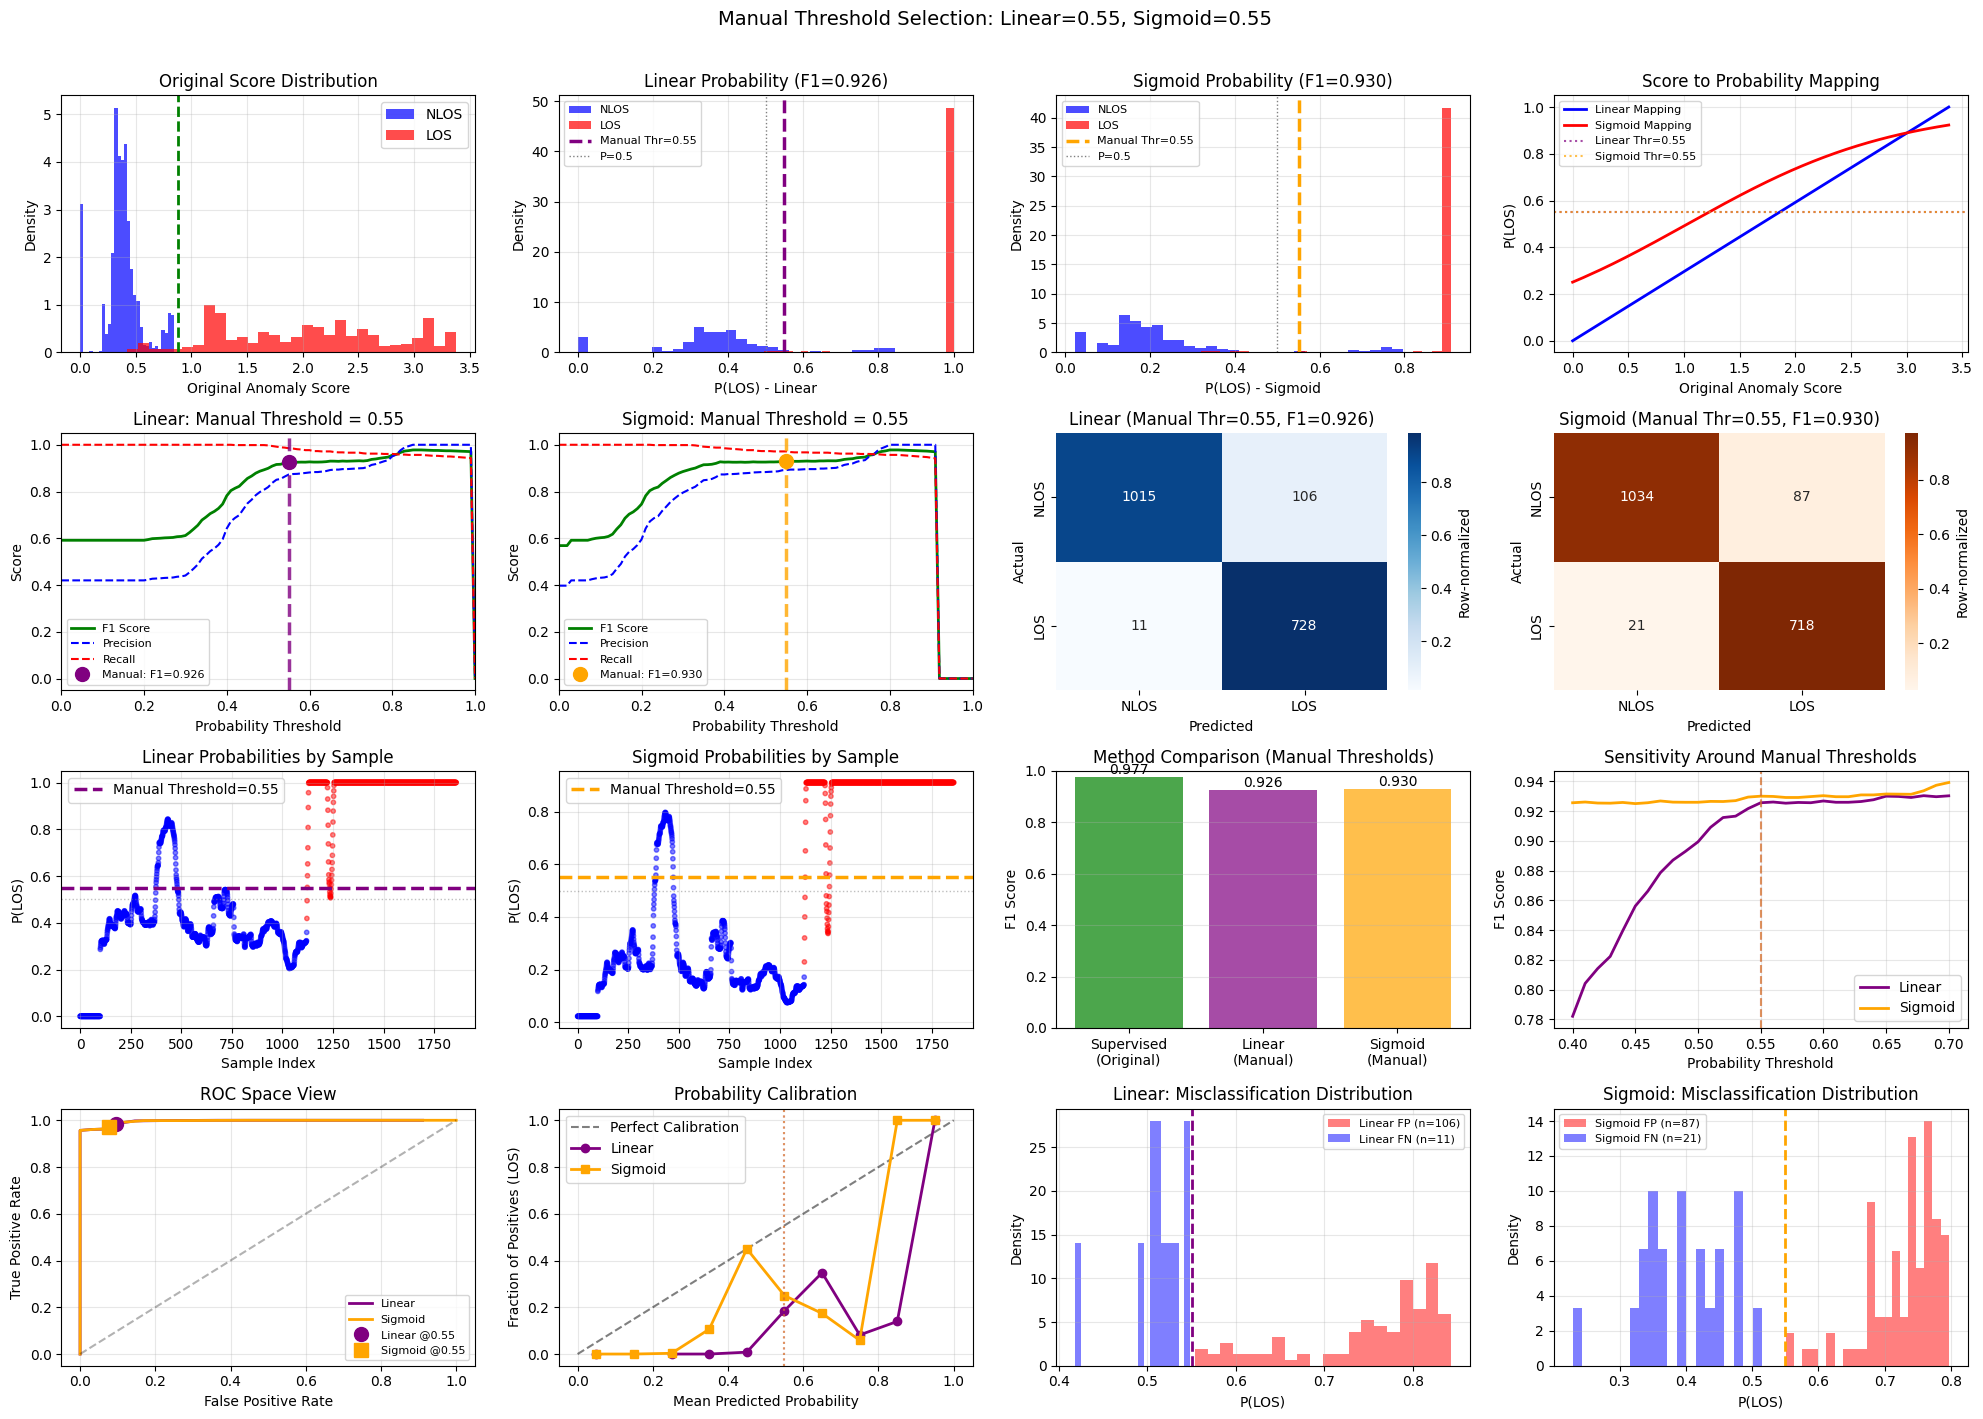


MANUAL PROBABILITY THRESHOLD ANALYSIS

🎯 MANUALLY SELECTED THRESHOLDS:
  • Linear Threshold:  0.55
  • Sigmoid Threshold: 0.55

----------------------------------------
LINEAR PROBABILITY RESULTS
----------------------------------------
  Threshold: 0.55
  F1 Score: 0.9256
  Precision: 0.8729
  Recall: 0.9851
  Accuracy: 0.9371

  Confusion Matrix:
    True Negatives (NLOS correct): 1015
    False Positives (NLOS→LOS): 106
    False Negatives (LOS→NLOS): 11
    True Positives (LOS correct): 728

----------------------------------------
SIGMOID PROBABILITY RESULTS
----------------------------------------
  Threshold: 0.55
  F1 Score: 0.9301
  Precision: 0.8919
  Recall: 0.9716
  Accuracy: 0.9419

  Confusion Matrix:
    True Negatives (NLOS correct): 1034
    False Positives (NLOS→LOS): 87
    False Negatives (LOS→NLOS): 21
    True Positives (LOS correct): 718

----------------------------------------
INTERPRETATION
----------------------------------------

Linear (threshold=0.55):
  

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import seaborn as sns
from scipy.special import expit  # Sigmoid function

def normalize_to_probability(scores):
    """
    Normalize anomaly scores to probability [0, 1]
    0 = 100% NLOS (minimum anomaly)
    1 = 100% LOS (maximum anomaly)

    First caps any scores > 1 to 1, then normalizes the result.
    """
    scores = np.asarray(scores).copy()  # Make a copy to avoid modifying original

    # Step 1: Cap any scores greater than 1 to exactly 1
    scores[scores >1] = 1
    scores[scores <0.2] = 0

    print(f"Capped {np.sum(scores > 1)} scores that were > 1")

    # Step 2: Now normalize the capped scores
    min_score = scores.min()
    max_score = scores.max()

    # Linear normalization (after capping)
    if max_score > min_score:
        prob_linear = (scores - min_score) / (max_score - min_score)
    else:
        # If all scores are the same after capping
        prob_linear = np.ones_like(scores) if max_score == 1 else np.zeros_like(scores)

    # Sigmoid normalization (after capping)
    mean_score = scores.mean()
    std_score = scores.std()/2
    if std_score > 0:  # Avoid division by zero
        z_scores = (scores - mean_score) / std_score
        prob_sigmoid = expit(z_scores)  # Sigmoid function
    else:
        # If all scores are the same, return 0.5 for all
        prob_sigmoid = np.full_like(scores, 0.5, dtype=float)

    # Final safety check to ensure values are in [0, 1]
    prob_linear = np.clip(prob_linear, 0, 1)
    prob_sigmoid = np.clip(prob_sigmoid, 0, 1)

    # Print statistics for debugging
    print(f"Original scores range: [{scores.min():.4f}, {scores.max():.4f}]")
    print(f"Linear prob range: [{prob_linear.min():.4f}, {prob_linear.max():.4f}]")
    print(f"Sigmoid prob range: [{prob_sigmoid.min():.4f}, {prob_sigmoid.max():.4f}]")

    return prob_linear, prob_sigmoid

def evaluate_manual_threshold(prob_scores, y_true, threshold):
    """
    Evaluate performance at a manually selected threshold
    """
    # Classify: P(LOS) > threshold -> LOS (1), else NLOS (0)
    y_pred = (prob_scores > threshold).astype(int)

    f1 = f1_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)

    return {
        'threshold': threshold,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'y_pred': y_pred
    }

def evaluate_threshold_range(prob_scores, y_true, thresholds):
    """
    Evaluate performance across a range of thresholds for visualization
    """
    results = []
    for threshold in thresholds:
        y_pred = (prob_scores > threshold).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)

        results.append({
            'threshold': threshold,
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy
        })
    return results

def evaluate_manual_probability_thresholds(results, linear_threshold=0.45, sigmoid_threshold=0.6):
    """
    Evaluate probability-based thresholding with manually selected thresholds

    Parameters:
    -----------
    results : dict
        Results from the main evaluation
    linear_threshold : float
        Manual threshold for linear probability (default: 0.45)
    sigmoid_threshold : float
        Manual threshold for sigmoid probability (default: 0.6)
    """
    # Extract data
    smoothed_scores = results['smoothed_scores']
    y_test = results['y_test']
    supervised = results['supervised']

    # Convert to probabilities
    prob_linear, prob_sigmoid = normalize_to_probability(smoothed_scores)

    # Evaluate at manually selected thresholds
    linear_result = evaluate_manual_threshold(prob_linear, y_test, linear_threshold)
    sigmoid_result = evaluate_manual_threshold(prob_sigmoid, y_test, sigmoid_threshold)

    # Get performance across range for visualization
    prob_thresholds = np.arange(0.0, 1.01, 0.01)
    linear_range = evaluate_threshold_range(prob_linear, y_test, prob_thresholds)
    sigmoid_range = evaluate_threshold_range(prob_sigmoid, y_test, prob_thresholds)

    # Create visualizations
    fig = plt.figure(figsize=(20, 14))

    # ============= Row 1: Distribution and Mapping =============

    # 1. Original Score Distribution
    ax1 = plt.subplot(4, 4, 1)
    ax1.hist(smoothed_scores[y_test==0], bins=30, density=True, alpha=0.7, label='NLOS', color='blue')
    ax1.hist(smoothed_scores[y_test==1], bins=30, density=True, alpha=0.7, label='LOS', color='red')
    ax1.axvline(supervised['smoothed']['threshold'], color='green', linestyle='--', linewidth=2)
    ax1.set_xlabel('Original Anomaly Score')
    ax1.set_ylabel('Density')
    ax1.set_title('Original Score Distribution')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 2. Linear Probability Distribution
    ax2 = plt.subplot(4, 4, 2)
    ax2.hist(prob_linear[y_test==0], bins=30, density=True, alpha=0.7, label='NLOS', color='blue')
    ax2.hist(prob_linear[y_test==1], bins=30, density=True, alpha=0.7, label='LOS', color='red')
    ax2.axvline(linear_threshold, color='purple', linestyle='--', linewidth=2.5,
                label=f"Manual Thr={linear_threshold:.2f}")
    ax2.axvline(0.5, color='gray', linestyle=':', linewidth=1, label='P=0.5')
    ax2.set_xlabel('P(LOS) - Linear')
    ax2.set_ylabel('Density')
    ax2.set_title(f'Linear Probability (F1={linear_result["f1"]:.3f})')
    ax2.legend(fontsize=8)
    ax2.grid(alpha=0.3)

    # 3. Sigmoid Probability Distribution
    ax3 = plt.subplot(4, 4, 3)
    ax3.hist(prob_sigmoid[y_test==0], bins=30, density=True, alpha=0.7, label='NLOS', color='blue')
    ax3.hist(prob_sigmoid[y_test==1], bins=30, density=True, alpha=0.7, label='LOS', color='red')
    ax3.axvline(sigmoid_threshold, color='orange', linestyle='--', linewidth=2.5,
                label=f"Manual Thr={sigmoid_threshold:.2f}")
    ax3.axvline(0.5, color='gray', linestyle=':', linewidth=1, label='P=0.5')
    ax3.set_xlabel('P(LOS) - Sigmoid')
    ax3.set_ylabel('Density')
    ax3.set_title(f'Sigmoid Probability (F1={sigmoid_result["f1"]:.3f})')
    ax3.legend(fontsize=8)
    ax3.grid(alpha=0.3)

    # 4. Mapping Functions
    ax4 = plt.subplot(4, 4, 4)
    sorted_scores = np.sort(smoothed_scores)
    sorted_linear = (sorted_scores - sorted_scores.min()) / (sorted_scores.max() - sorted_scores.min())
    z_sorted = (sorted_scores - smoothed_scores.mean()) / smoothed_scores.std()
    sorted_sigmoid = expit(z_sorted)

    ax4.plot(sorted_scores, sorted_linear, 'b-', linewidth=2, label='Linear Mapping')
    ax4.plot(sorted_scores, sorted_sigmoid, 'r-', linewidth=2, label='Sigmoid Mapping')

    # Add horizontal lines for selected thresholds
    ax4.axhline(linear_threshold, color='purple', linestyle=':', alpha=0.7, label=f'Linear Thr={linear_threshold}')
    ax4.axhline(sigmoid_threshold, color='orange', linestyle=':', alpha=0.7, label=f'Sigmoid Thr={sigmoid_threshold}')

    ax4.set_xlabel('Original Anomaly Score')
    ax4.set_ylabel('P(LOS)')
    ax4.set_title('Score to Probability Mapping')
    ax4.legend(fontsize=8)
    ax4.grid(alpha=0.3)

    # ============= Row 2: Performance Analysis =============

    # 5. F1 Score vs Threshold (Linear) with Manual Selection
    ax5 = plt.subplot(4, 4, 5)
    thresholds = [r['threshold'] for r in linear_range]
    f1_scores = [r['f1'] for r in linear_range]
    precision_scores = [r['precision'] for r in linear_range]
    recall_scores = [r['recall'] for r in linear_range]

    ax5.plot(thresholds, f1_scores, 'g-', linewidth=2, label='F1 Score')
    ax5.plot(thresholds, precision_scores, 'b--', linewidth=1.5, label='Precision')
    ax5.plot(thresholds, recall_scores, 'r--', linewidth=1.5, label='Recall')
    ax5.axvline(linear_threshold, color='purple', linestyle='--', linewidth=2.5, alpha=0.8)

    # Mark the manual threshold point
    manual_idx = np.argmin(np.abs(np.array(thresholds) - linear_threshold))
    ax5.plot(linear_threshold, f1_scores[manual_idx], 'o', color='purple', markersize=10,
             label=f'Manual: F1={f1_scores[manual_idx]:.3f}')

    ax5.set_xlabel('Probability Threshold')
    ax5.set_ylabel('Score')
    ax5.set_title(f'Linear: Manual Threshold = {linear_threshold}')
    ax5.legend(fontsize=8)
    ax5.grid(alpha=0.3)
    ax5.set_xlim([0, 1])

    # 6. F1 Score vs Threshold (Sigmoid) with Manual Selection
    ax6 = plt.subplot(4, 4, 6)
    f1_scores_sig = [r['f1'] for r in sigmoid_range]
    precision_scores_sig = [r['precision'] for r in sigmoid_range]
    recall_scores_sig = [r['recall'] for r in sigmoid_range]

    ax6.plot(thresholds, f1_scores_sig, 'g-', linewidth=2, label='F1 Score')
    ax6.plot(thresholds, precision_scores_sig, 'b--', linewidth=1.5, label='Precision')
    ax6.plot(thresholds, recall_scores_sig, 'r--', linewidth=1.5, label='Recall')
    ax6.axvline(sigmoid_threshold, color='orange', linestyle='--', linewidth=2.5, alpha=0.8)

    # Mark the manual threshold point
    manual_idx_sig = np.argmin(np.abs(np.array(thresholds) - sigmoid_threshold))
    ax6.plot(sigmoid_threshold, f1_scores_sig[manual_idx_sig], 'o', color='orange', markersize=10,
             label=f'Manual: F1={f1_scores_sig[manual_idx_sig]:.3f}')

    ax6.set_xlabel('Probability Threshold')
    ax6.set_ylabel('Score')
    ax6.set_title(f'Sigmoid: Manual Threshold = {sigmoid_threshold}')
    ax6.legend(fontsize=8)
    ax6.grid(alpha=0.3)
    ax6.set_xlim([0, 1])

    # 7. Confusion Matrix - Linear
    ax7 = plt.subplot(4, 4, 7)
    cm_linear = confusion_matrix(y_test, linear_result['y_pred'])
    cm_norm = cm_linear.astype(float) / cm_linear.sum(axis=1, keepdims=True)
    sns.heatmap(cm_norm, annot=cm_linear, fmt="d", cmap="Blues", ax=ax7,
                xticklabels=["NLOS","LOS"], yticklabels=["NLOS","LOS"],
                cbar_kws={"label":"Row-normalized"})
    ax7.set_title(f"Linear (Manual Thr={linear_threshold}, F1={linear_result['f1']:.3f})")
    ax7.set_xlabel("Predicted")
    ax7.set_ylabel("Actual")

    # 8. Confusion Matrix - Sigmoid
    ax8 = plt.subplot(4, 4, 8)
    cm_sigmoid = confusion_matrix(y_test, sigmoid_result['y_pred'])
    cm_norm = cm_sigmoid.astype(float) / cm_sigmoid.sum(axis=1, keepdims=True)
    sns.heatmap(cm_norm, annot=cm_sigmoid, fmt="d", cmap="Oranges", ax=ax8,
                xticklabels=["NLOS","LOS"], yticklabels=["NLOS","LOS"],
                cbar_kws={"label":"Row-normalized"})
    ax8.set_title(f"Sigmoid (Manual Thr={sigmoid_threshold}, F1={sigmoid_result['f1']:.3f})")
    ax8.set_xlabel("Predicted")
    ax8.set_ylabel("Actual")

    # ============= Row 3: Probability Analysis =============

    # 9. Scatter Plot - Linear Probabilities
    ax9 = plt.subplot(4, 4, 9)
    colors = ['blue' if y == 0 else 'red' for y in y_test]
    ax9.scatter(range(len(prob_linear)), prob_linear, c=colors, alpha=0.5, s=10)
    ax9.axhline(linear_threshold, color='purple', linestyle='--', linewidth=2.5,
                label=f'Manual Threshold={linear_threshold}')
    ax9.axhline(0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    ax9.set_xlabel('Sample Index')
    ax9.set_ylabel('P(LOS)')
    ax9.set_title('Linear Probabilities by Sample')
    ax9.legend()
    ax9.grid(alpha=0.3)

    # 10. Scatter Plot - Sigmoid Probabilities
    ax10 = plt.subplot(4, 4, 10)
    ax10.scatter(range(len(prob_sigmoid)), prob_sigmoid, c=colors, alpha=0.5, s=10)
    ax10.axhline(sigmoid_threshold, color='orange', linestyle='--', linewidth=2.5,
                 label=f'Manual Threshold={sigmoid_threshold}')
    ax10.axhline(0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    ax10.set_xlabel('Sample Index')
    ax10.set_ylabel('P(LOS)')
    ax10.set_title('Sigmoid Probabilities by Sample')
    ax10.legend()
    ax10.grid(alpha=0.3)

    # 11. Method Comparison
    ax11 = plt.subplot(4, 4, 11)
    methods = ['Supervised\n(Original)', 'Linear\n(Manual)', 'Sigmoid\n(Manual)']
    f1_scores_comp = [supervised['smoothed']['f1'], linear_result['f1'], sigmoid_result['f1']]
    colors_comp = ['green', 'purple', 'orange']

    bars = ax11.bar(methods, f1_scores_comp, color=colors_comp, alpha=0.7)
    ax11.set_ylabel('F1 Score')
    ax11.set_title('Method Comparison (Manual Thresholds)')
    ax11.set_ylim([0, 1])

    # Add value labels on bars
    for bar, score in zip(bars, f1_scores_comp):
        height = bar.get_height()
        ax11.text(bar.get_x() + bar.get_width()/2., height,
                 f'{score:.3f}', ha='center', va='bottom')
    ax11.grid(axis='y', alpha=0.3)

    # 12. Threshold Sensitivity Analysis
    ax12 = plt.subplot(4, 4, 12)

    # Calculate F1 scores around the manual thresholds
    linear_range_around = np.arange(max(0, linear_threshold-0.15),
                                    min(1, linear_threshold+0.15), 0.01)
    sigmoid_range_around = np.arange(max(0, sigmoid_threshold-0.15),
                                     min(1, sigmoid_threshold+0.15), 0.01)

    linear_f1_around = []
    sigmoid_f1_around = []

    for thr in linear_range_around:
        y_pred = (prob_linear > thr).astype(int)
        linear_f1_around.append(f1_score(y_test, y_pred, zero_division=0))

    for thr in sigmoid_range_around:
        y_pred = (prob_sigmoid > thr).astype(int)
        sigmoid_f1_around.append(f1_score(y_test, y_pred, zero_division=0))

    ax12.plot(linear_range_around, linear_f1_around, 'purple', linewidth=2, label='Linear')
    ax12.plot(sigmoid_range_around, sigmoid_f1_around, 'orange', linewidth=2, label='Sigmoid')
    ax12.axvline(linear_threshold, color='purple', linestyle='--', alpha=0.5)
    ax12.axvline(sigmoid_threshold, color='orange', linestyle='--', alpha=0.5)

    ax12.set_xlabel('Probability Threshold')
    ax12.set_ylabel('F1 Score')
    ax12.set_title('Sensitivity Around Manual Thresholds')
    ax12.legend()
    ax12.grid(alpha=0.3)

    # ============= Row 4: Additional Analysis =============

    # 13. ROC-style plot
    ax13 = plt.subplot(4, 4, 13)
    fpr_linear = []
    tpr_linear = []
    fpr_sigmoid = []
    tpr_sigmoid = []

    for r in linear_range[::5]:  # Sample every 5th point for clarity
        tn = np.sum((prob_linear <= r['threshold']) & (y_test == 0))
        fp = np.sum((prob_linear > r['threshold']) & (y_test == 0))
        fn = np.sum((prob_linear <= r['threshold']) & (y_test == 1))
        tp = np.sum((prob_linear > r['threshold']) & (y_test == 1))

        fpr_linear.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
        tpr_linear.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

    for r in sigmoid_range[::5]:
        tn = np.sum((prob_sigmoid <= r['threshold']) & (y_test == 0))
        fp = np.sum((prob_sigmoid > r['threshold']) & (y_test == 0))
        fn = np.sum((prob_sigmoid <= r['threshold']) & (y_test == 1))
        tp = np.sum((prob_sigmoid > r['threshold']) & (y_test == 1))

        fpr_sigmoid.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
        tpr_sigmoid.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

    ax13.plot(fpr_linear, tpr_linear, 'purple', linewidth=2, label='Linear')
    ax13.plot(fpr_sigmoid, tpr_sigmoid, 'orange', linewidth=2, label='Sigmoid')
    ax13.plot([0, 1], [0, 1], 'k--', alpha=0.3)

    # Mark manual threshold points
    tn_l = np.sum((prob_linear <= linear_threshold) & (y_test == 0))
    fp_l = np.sum((prob_linear > linear_threshold) & (y_test == 0))
    fn_l = np.sum((prob_linear <= linear_threshold) & (y_test == 1))
    tp_l = np.sum((prob_linear > linear_threshold) & (y_test == 1))
    fpr_l = fp_l / (fp_l + tn_l) if (fp_l + tn_l) > 0 else 0
    tpr_l = tp_l / (tp_l + fn_l) if (tp_l + fn_l) > 0 else 0

    tn_s = np.sum((prob_sigmoid <= sigmoid_threshold) & (y_test == 0))
    fp_s = np.sum((prob_sigmoid > sigmoid_threshold) & (y_test == 0))
    fn_s = np.sum((prob_sigmoid <= sigmoid_threshold) & (y_test == 1))
    tp_s = np.sum((prob_sigmoid > sigmoid_threshold) & (y_test == 1))
    fpr_s = fp_s / (fp_s + tn_s) if (fp_s + tn_s) > 0 else 0
    tpr_s = tp_s / (tp_s + fn_s) if (tp_s + fn_s) > 0 else 0

    ax13.plot(fpr_l, tpr_l, 'o', color='purple', markersize=10, label=f'Linear @{linear_threshold}')
    ax13.plot(fpr_s, tpr_s, 's', color='orange', markersize=10, label=f'Sigmoid @{sigmoid_threshold}')

    ax13.set_xlabel('False Positive Rate')
    ax13.set_ylabel('True Positive Rate')
    ax13.set_title('ROC Space View')
    ax13.legend(fontsize=8)
    ax13.grid(alpha=0.3)

    # 14. Probability Calibration Plot
    ax14 = plt.subplot(4, 4, 14)

    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    actual_linear = []
    actual_sigmoid = []
    counts_linear = []
    counts_sigmoid = []

    for i in range(n_bins):
        # Linear
        mask_linear = (prob_linear >= bin_edges[i]) & (prob_linear < bin_edges[i+1])
        count_l = np.sum(mask_linear)
        counts_linear.append(count_l)
        if count_l > 0:
            actual_linear.append(np.mean(y_test[mask_linear]))
        else:
            actual_linear.append(np.nan)

        # Sigmoid
        mask_sigmoid = (prob_sigmoid >= bin_edges[i]) & (prob_sigmoid < bin_edges[i+1])
        count_s = np.sum(mask_sigmoid)
        counts_sigmoid.append(count_s)
        if count_s > 0:
            actual_sigmoid.append(np.mean(y_test[mask_sigmoid]))
        else:
            actual_sigmoid.append(np.nan)

    ax14.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
    ax14.plot(bin_centers, actual_linear, 'o-', color='purple', linewidth=2, label='Linear')
    ax14.plot(bin_centers, actual_sigmoid, 's-', color='orange', linewidth=2, label='Sigmoid')
    ax14.axvline(linear_threshold, color='purple', linestyle=':', alpha=0.5)
    ax14.axvline(sigmoid_threshold, color='orange', linestyle=':', alpha=0.5)
    ax14.set_xlabel('Mean Predicted Probability')
    ax14.set_ylabel('Fraction of Positives (LOS)')
    ax14.set_title('Probability Calibration')
    ax14.legend()
    ax14.grid(alpha=0.3)

    # 15. Distribution of misclassifications
    ax15 = plt.subplot(4, 4, 15)

    # Linear misclassifications
    linear_fp_mask = (linear_result['y_pred'] == 1) & (y_test == 0)
    linear_fn_mask = (linear_result['y_pred'] == 0) & (y_test == 1)

    ax15.hist(prob_linear[linear_fp_mask], bins=20, alpha=0.5, color='red',
             label=f'Linear FP (n={np.sum(linear_fp_mask)})', density=True)
    ax15.hist(prob_linear[linear_fn_mask], bins=20, alpha=0.5, color='blue',
             label=f'Linear FN (n={np.sum(linear_fn_mask)})', density=True)
    ax15.axvline(linear_threshold, color='purple', linestyle='--', linewidth=2)
    ax15.set_xlabel('P(LOS)')
    ax15.set_ylabel('Density')
    ax15.set_title('Linear: Misclassification Distribution')
    ax15.legend(fontsize=8)
    ax15.grid(alpha=0.3)

    # 16. Distribution of misclassifications for Sigmoid
    ax16 = plt.subplot(4, 4, 16)

    sigmoid_fp_mask = (sigmoid_result['y_pred'] == 1) & (y_test == 0)
    sigmoid_fn_mask = (sigmoid_result['y_pred'] == 0) & (y_test == 1)

    ax16.hist(prob_sigmoid[sigmoid_fp_mask], bins=20, alpha=0.5, color='red',
             label=f'Sigmoid FP (n={np.sum(sigmoid_fp_mask)})', density=True)
    ax16.hist(prob_sigmoid[sigmoid_fn_mask], bins=20, alpha=0.5, color='blue',
             label=f'Sigmoid FN (n={np.sum(sigmoid_fn_mask)})', density=True)
    ax16.axvline(sigmoid_threshold, color='orange', linestyle='--', linewidth=2)
    ax16.set_xlabel('P(LOS)')
    ax16.set_ylabel('Density')
    ax16.set_title('Sigmoid: Misclassification Distribution')
    ax16.legend(fontsize=8)
    ax16.grid(alpha=0.3)

    plt.suptitle(f'Manual Threshold Selection: Linear={linear_threshold}, Sigmoid={sigmoid_threshold}',
                 fontsize=14, y=1.01)
    plt.tight_layout()
    plt.show()

    # Print detailed results
    print("\n" + "="*80)
    print("MANUAL PROBABILITY THRESHOLD ANALYSIS")
    print("="*80)

    print(f"\n🎯 MANUALLY SELECTED THRESHOLDS:")
    print(f"  • Linear Threshold:  {linear_threshold}")
    print(f"  • Sigmoid Threshold: {sigmoid_threshold}")

    print("\n" + "-"*40)
    print("LINEAR PROBABILITY RESULTS")
    print("-"*40)
    print(f"  Threshold: {linear_threshold}")
    print(f"  F1 Score: {linear_result['f1']:.4f}")
    print(f"  Precision: {linear_result['precision']:.4f}")
    print(f"  Recall: {linear_result['recall']:.4f}")
    print(f"  Accuracy: {linear_result['accuracy']:.4f}")

    # Calculate confusion matrix details
    cm_linear = confusion_matrix(y_test, linear_result['y_pred'])
    tn, fp, fn, tp = cm_linear.ravel()
    print(f"\n  Confusion Matrix:")
    print(f"    True Negatives (NLOS correct): {tn}")
    print(f"    False Positives (NLOS→LOS): {fp}")
    print(f"    False Negatives (LOS→NLOS): {fn}")
    print(f"    True Positives (LOS correct): {tp}")

    print("\n" + "-"*40)
    print("SIGMOID PROBABILITY RESULTS")
    print("-"*40)
    print(f"  Threshold: {sigmoid_threshold}")
    print(f"  F1 Score: {sigmoid_result['f1']:.4f}")
    print(f"  Precision: {sigmoid_result['precision']:.4f}")
    print(f"  Recall: {sigmoid_result['recall']:.4f}")
    print(f"  Accuracy: {sigmoid_result['accuracy']:.4f}")

    cm_sigmoid = confusion_matrix(y_test, sigmoid_result['y_pred'])
    tn, fp, fn, tp = cm_sigmoid.ravel()
    print(f"\n  Confusion Matrix:")
    print(f"    True Negatives (NLOS correct): {tn}")
    print(f"    False Positives (NLOS→LOS): {fp}")
    print(f"    False Negatives (LOS→NLOS): {fn}")
    print(f"    True Positives (LOS correct): {tp}")

    print("\n" + "-"*40)
    print("INTERPRETATION")
    print("-"*40)
    print(f"\nLinear (threshold={linear_threshold}):")
    print(f"  • Samples with P(LOS) > {linear_threshold} → classified as LOS")
    print(f"  • Samples with P(LOS) ≤ {linear_threshold} → classified as NLOS")

    print(f"\nSigmoid (threshold={sigmoid_threshold}):")
    print(f"  • Samples with P(LOS) > {sigmoid_threshold} → classified as LOS")
    print(f"  • Samples with P(LOS) ≤ {sigmoid_threshold} → classified as NLOS")

    # Compare with supervised baseline
    print("\n" + "-"*40)
    print("COMPARISON WITH SUPERVISED BASELINE")
    print("-"*40)
    print(f"  Supervised F1: {supervised['smoothed']['f1']:.4f}")
    print(f"  Linear F1:     {linear_result['f1']:.4f} ({'↑' if linear_result['f1'] > supervised['smoothed']['f1'] else '↓'} {abs(linear_result['f1'] - supervised['smoothed']['f1']):.4f})")
    print(f"  Sigmoid F1:    {sigmoid_result['f1']:.4f} ({'↑' if sigmoid_result['f1'] > supervised['smoothed']['f1'] else '↓'} {abs(sigmoid_result['f1'] - supervised['smoothed']['f1']):.4f})")

    # Probability distribution statistics
    print("\n" + "-"*40)
    print("PROBABILITY DISTRIBUTIONS BY CLASS")
    print("-"*40)
    print("\nNLOS samples (should have low P(LOS)):")
    print(f"  Linear:  mean={prob_linear[y_test==0].mean():.3f}, std={prob_linear[y_test==0].std():.3f}")
    print(f"  Sigmoid: mean={prob_sigmoid[y_test==0].mean():.3f}, std={prob_sigmoid[y_test==0].std():.3f}")

    print("\nLOS samples (should have high P(LOS)):")
    print(f"  Linear:  mean={prob_linear[y_test==1].mean():.3f}, std={prob_linear[y_test==1].std():.3f}")
    print(f"  Sigmoid: mean={prob_sigmoid[y_test==1].mean():.3f}, std={prob_sigmoid[y_test==1].std():.3f}")

    # Find optimal thresholds for reference
    print("\n" + "-"*40)
    print("OPTIMAL THRESHOLDS (for reference)")
    print("-"*40)

    optimal_linear_idx = np.argmax([r['f1'] for r in linear_range])
    optimal_sigmoid_idx = np.argmax([r['f1'] for r in sigmoid_range])

    print(f"  Linear optimal:  {linear_range[optimal_linear_idx]['threshold']:.2f} (F1={linear_range[optimal_linear_idx]['f1']:.4f})")
    print(f"  Sigmoid optimal: {sigmoid_range[optimal_sigmoid_idx]['threshold']:.2f} (F1={sigmoid_range[optimal_sigmoid_idx]['f1']:.4f})")

    print("\n" + "="*80)

    return {
        'prob_linear': prob_linear,
        'prob_sigmoid': prob_sigmoid,
        'linear_result': linear_result,
        'sigmoid_result': sigmoid_result,
        'linear_range': linear_range,
        'sigmoid_range': sigmoid_range
    }

# Execute with manual thresholds
if 'results' in globals():
    print("Running manual threshold analysis...")


    # You can easily change these thresholds here
    manual_results = evaluate_manual_probability_thresholds(
        results,
        linear_threshold=0.55,  # Change this value as needed
        sigmoid_threshold=0.55   # Change this value as needed
    )

    print("\n✅ Analysis complete! You can modify the thresholds by changing the values in the function call.")
else:
    print("Please run the main evaluation first to generate 'results' variable")